# Cross Validation of ML algorithms with simple data analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import colors as mcolors
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
import pandas as pd
import sklearn as sk
from xgboost import XGBClassifier
from sklearn.preprocessing.imputation import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
%matplotlib inline

/home/amadeusz/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Load and check training dataset  

 <b>mjd</b> - the time in Modified Julian Date (MJD) of the observation. 
       Can be read as days since November 17, 1858. Can be converted to Unix epoch time with the formula 
       unix_time = (MJD−40587)×86400. Float64

 <b>passband</b> - The specific LSST passband integer, such that u, g, r, i, z, Y = 0, 1, 2, 3, 4, 5 in which it was viewed. Int8
 
 <b>flux</b> - the measured flux (brightness) in the passband of observation as listed in the passband column. 
        These values have already been corrected for dust extinction (mwebv), though heavily extincted objects 
        will have larger uncertainties (flux_err) in spite of the correction. Float32

 <b>flux_err</b> -  the uncertainty on the measurement of the flux listed above. Float32

 <b>detected</b> - If 1, the object's brightness is significantly different at the 3-sigma level 
           relative to the reference template. Only objects with at least 2 detections are included in the dataset. Boolean

***Load training dataset.***

In [6]:
dataset = pd.read_csv("/media/amadeusz/78F69DA1F69D6064/Users/Amadeusz/Downloads/all/training_set.csv")
dataset.head()

object_id         mjd  passband        flux   flux_err  detected
0        615  59750.4229         2 -544.810303   3.622952         1
1        615  59750.4306         1 -816.434326   5.553370         1
2        615  59750.4383         3 -471.385529   3.801213         1
3        615  59750.4450         4 -388.984985  11.395031         1
4        615  59752.4070         2 -681.858887   4.041204         1

In [3]:
meta_dataset = pd.read_csv("/media/amadeusz/78F69DA1F69D6064/Users/Amadeusz/Downloads/all/training_set_metadata.csv")
column_names = {6: "class_6", 15: "class_15", 16: "class_16", 42: "class_42", 52: "class_52", 53: "class_53",
                62: "class_62", 64: "class_64", 65: "class_65", 67: "class_67", 88: "class_88", 90: "class_90",
                92: "class_92", 95: "class_95"}
meta_dataset["target"] = list(map(lambda name: column_names[name], meta_dataset["target"]))
meta_dataset.head()

object_id          ra       decl       gal_l      gal_b  ddf  \
0        615  349.046051 -61.943836  320.796530 -51.753706    1   
1        713   53.085938 -27.784405  223.525509 -54.460748    1   
2        730   33.574219  -6.579593  170.455585 -61.548219    1   
3        745    0.189873 -45.586655  328.254458 -68.969298    1   
4       1124  352.711273 -63.823658  316.922299 -51.059403    1   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv    target  
0         0.0000          0.0000              0.0000      NaN  0.017  class_92  
1         1.8181          1.6267              0.2552  45.4063  0.007  class_88  
2         0.2320          0.2262              0.0157  40.2561  0.021  class_42  
3         0.3037          0.2813              1.1523  40.7951  0.007  class_90  
4         0.1934          0.2415              0.0176  40.4166  0.024  class_90

In [4]:
meta_dataset['in_our_galaxy'] = meta_dataset['distmod'].apply(np.isnan).astype(int)
meta_dataset.head()

object_id          ra       decl       gal_l      gal_b  ddf  \
0        615  349.046051 -61.943836  320.796530 -51.753706    1   
1        713   53.085938 -27.784405  223.525509 -54.460748    1   
2        730   33.574219  -6.579593  170.455585 -61.548219    1   
3        745    0.189873 -45.586655  328.254458 -68.969298    1   
4       1124  352.711273 -63.823658  316.922299 -51.059403    1   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv  \
0         0.0000          0.0000              0.0000      NaN  0.017   
1         1.8181          1.6267              0.2552  45.4063  0.007   
2         0.2320          0.2262              0.0157  40.2561  0.021   
3         0.3037          0.2813              1.1523  40.7951  0.007   
4         0.1934          0.2415              0.0176  40.4166  0.024   

     target  in_our_galaxy  
0  class_92              1  
1  class_88              0  
2  class_42              0  
3  class_90              0  
4  class_90              0

In [5]:
meta_dataset = meta_dataset.fillna(0)
meta_dataset = meta_dataset.drop(['hostgal_specz'], axis=1)
training_dataset = pd.merge(dataset, meta_dataset) # with additional computed features
training_dataset.head()

object_id         mjd  passband        flux   flux_err  detected  \
0        615  59750.4229         2 -544.810303   3.622952         1   
1        615  59750.4306         1 -816.434326   5.553370         1   
2        615  59750.4383         3 -471.385529   3.801213         1   
3        615  59750.4450         4 -388.984985  11.395031         1   
4        615  59752.4070         2 -681.858887   4.041204         1   

           ra       decl      gal_l      gal_b  ddf  hostgal_photoz  \
0  349.046051 -61.943836  320.79653 -51.753706    1             0.0   
1  349.046051 -61.943836  320.79653 -51.753706    1             0.0   
2  349.046051 -61.943836  320.79653 -51.753706    1             0.0   
3  349.046051 -61.943836  320.79653 -51.753706    1             0.0   
4  349.046051 -61.943836  320.79653 -51.753706    1             0.0   

   hostgal_photoz_err  distmod  mwebv    target  in_our_galaxy  
0                 0.0      0.0  0.017  class_92              1  
1                 0.0      0.0  0.017  class_92              1  
2                 0.0      0.0  0.017  class_92              1  
3                 0.0      0.0  0.017  class_92              1  
4                 0.0      0.0  0.017  class_92              1

***Extract particular time series per object_id***

In [6]:
gb = training_dataset.groupby('object_id')
object_id = np.linspace(1, len(set(training_dataset['object_id'])), len(set(training_dataset['object_id'])))

***Group objects by object_id and then by passband number***

In [7]:
pass_flu = dict()
for x in gb.groups:
    pass_flu[x] = dict()
    length = len(gb.get_group(x)['mjd'])
    pass_gb = gb.get_group(x)[['mjd', 'passband', 'flux', 'target', 'in_our_galaxy']].groupby('passband')
    for i in pass_gb.groups:
        pass_flu[x][i] = pass_gb.get_group(i)[['mjd', 'flux', 'target', 'in_our_galaxy']].sort_values(by=['mjd'])
        # range of particular object measurements
        pass_flu[x]['range'] = length
        # range of particular passband measurements
        pass_flu[x]['range_{}'.format(i)] = len(pass_flu[x][i])

***Find maximum sample size per passband***

In [8]:
max_n_measurement_samples = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
for i in set(training_dataset['object_id']):
    if pass_flu[i]['range_0'] > max_n_measurement_samples[0]:
        max_n_measurement_samples[0] = pass_flu[i]['range_0']
    if pass_flu[i]['range_1'] > max_n_measurement_samples[1]:
        max_n_measurement_samples[1] = pass_flu[i]['range_1']
    if pass_flu[i]['range_2'] > max_n_measurement_samples[2]:
        max_n_measurement_samples[2] = pass_flu[i]['range_2']
    if pass_flu[i]['range_3'] > max_n_measurement_samples[3]:
        max_n_measurement_samples[3] = pass_flu[i]['range_3']
    if pass_flu[i]['range_4'] > max_n_measurement_samples[4]:
        max_n_measurement_samples[4] = pass_flu[i]['range_4']
    if pass_flu[i]['range_5'] > max_n_measurement_samples[5]:
        max_n_measurement_samples[5] = pass_flu[i]['range_5']
length = sum([value for key, value in max_n_measurement_samples.items()])

In [9]:
def concatention():
    """Concatenate each passband samples to the maximum value (need to be the same length around all objects,
    simple method fills missing values with zeros.)"""
    y = pd.concat([pass_flu[i][0][['mjd', 'flux']],
                   pd.DataFrame(0, index=np.arange(max_n_measurement_samples[0]-pass_flu[i]['range_0']), 
                                columns=['mjd', 'flux']),
                   pass_flu[i][1][['mjd', 'flux']],
                   pd.DataFrame(0, index=np.arange(max_n_measurement_samples[1]-pass_flu[i]['range_1']), 
                                columns=['mjd', 'flux']),
                   pass_flu[i][2][['mjd', 'flux']],
                   pd.DataFrame(0, index=np.arange(max_n_measurement_samples[2]-pass_flu[i]['range_2']), 
                                columns=['mjd', 'flux']),
                   pass_flu[i][3][['mjd', 'flux']],
                   pd.DataFrame(0, index=np.arange(max_n_measurement_samples[3]-pass_flu[i]['range_3']), 
                                columns=['mjd', 'flux']),
                   pass_flu[i][4][['mjd', 'flux']],
                   pd.DataFrame(0, index=np.arange(max_n_measurement_samples[4]-pass_flu[i]['range_4']), 
                                columns=['mjd', 'flux']),
                   pass_flu[i][5][['mjd', 'flux']],
                   pd.DataFrame(0, index=np.arange(max_n_measurement_samples[5]-pass_flu[i]['range_5']), 
                                columns=['mjd', 'flux']),
                  ])
    return y['flux']

***Plot flux dependency for passband measurements, for each class, separation for interior and exterior galaxy type***

[Text(0,0,'passband start: 0'),
 Text(0,0,'passband end: 0\npassband start: 1'),
 Text(0,0,'passband end: 1\npassband start: 2'),
 Text(0,0,'passband end: 2\npassband start: 3'),
 Text(0,0,'passband end: 3\npassband start: 4'),
 Text(0,0,'passband end: 4\npassband start: 5'),
 Text(0,0,'passband end: 5')]

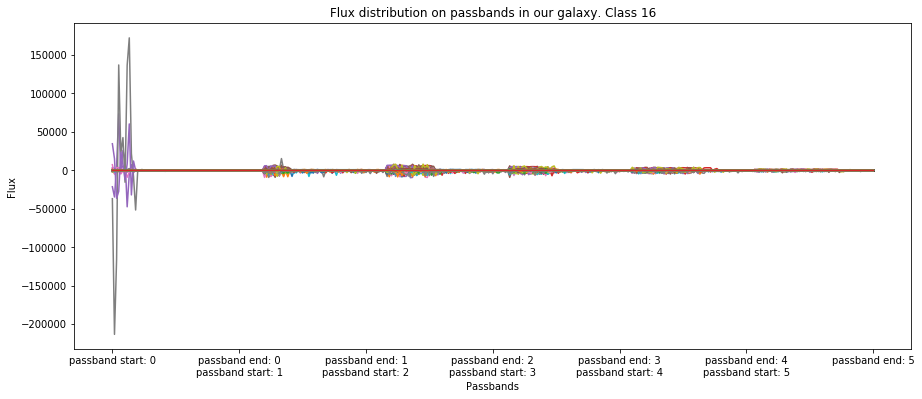

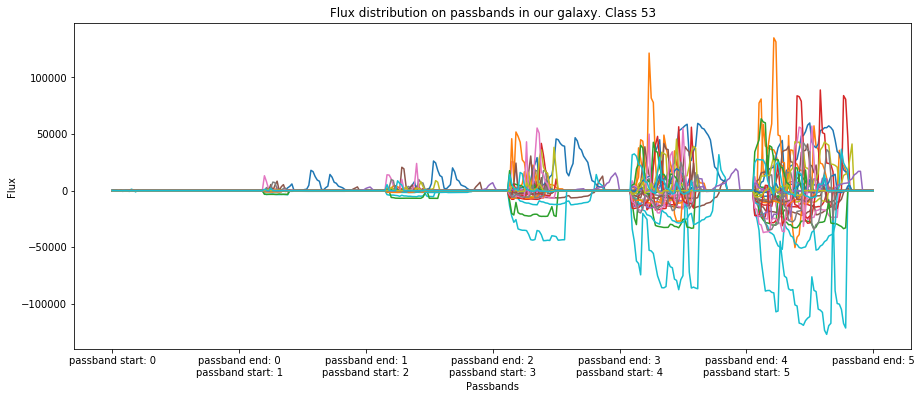

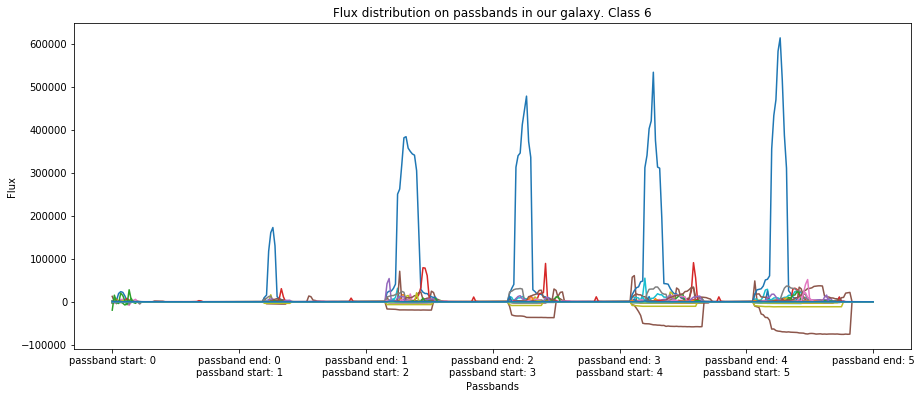

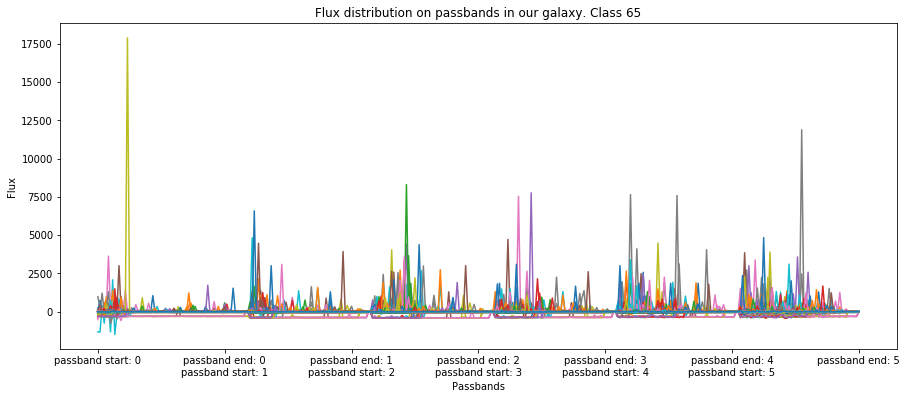

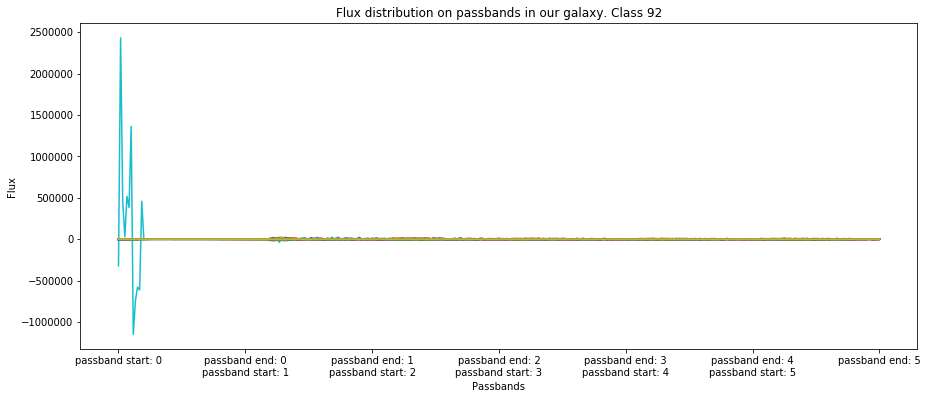

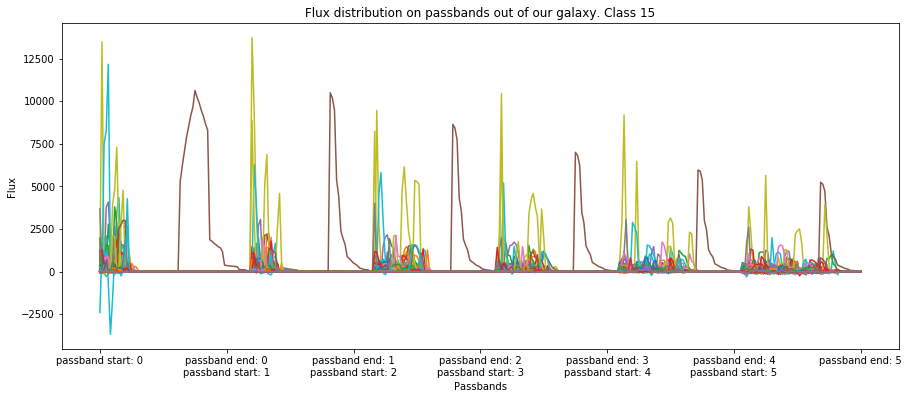

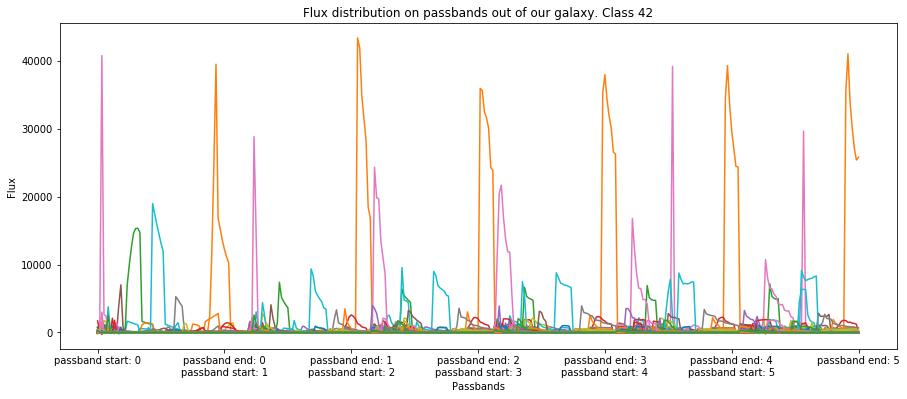

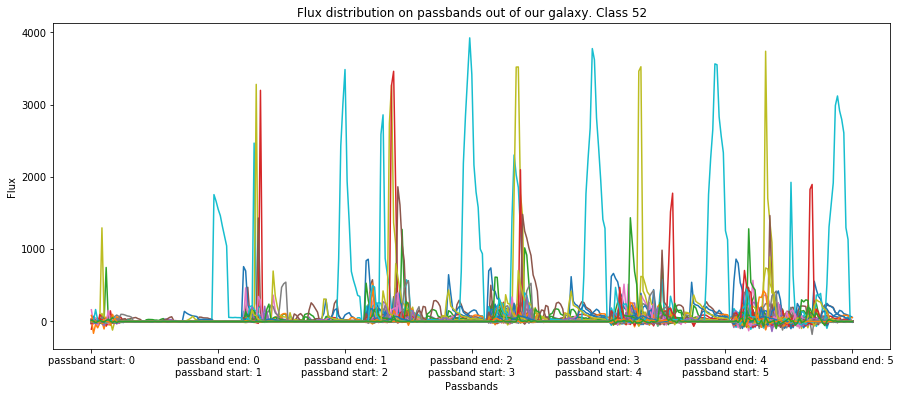

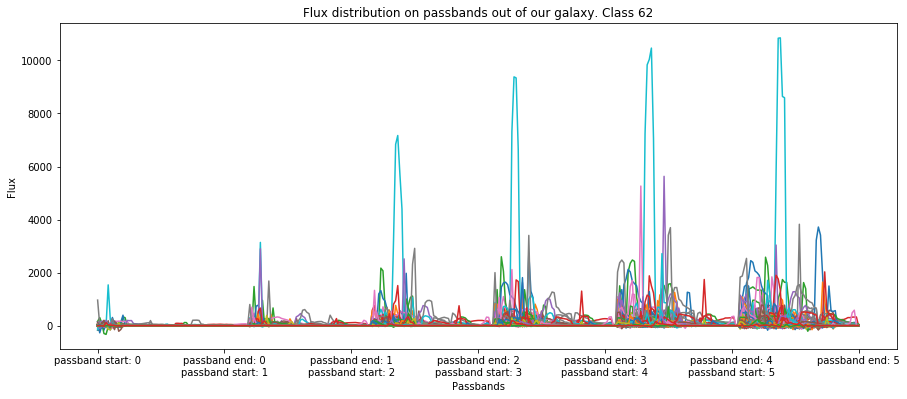

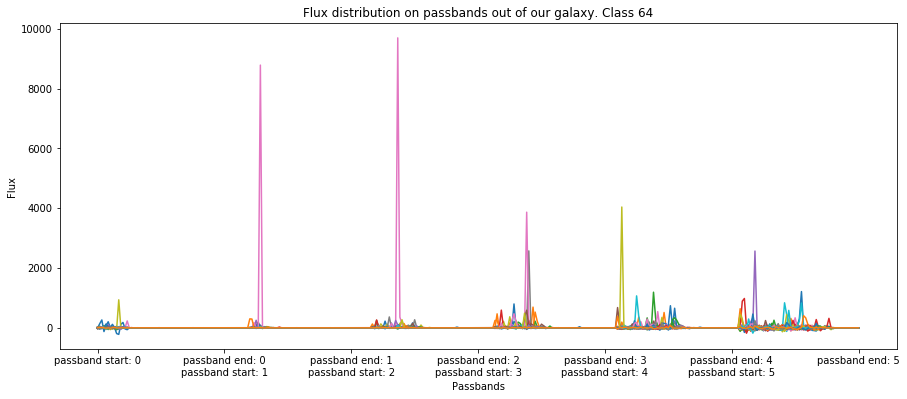

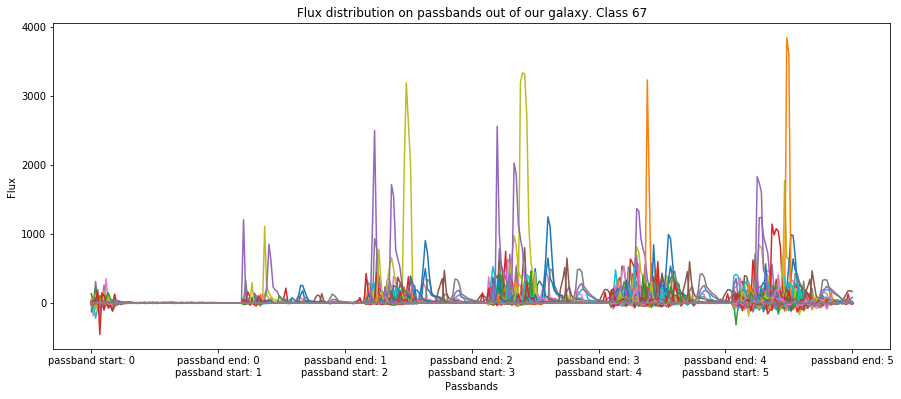

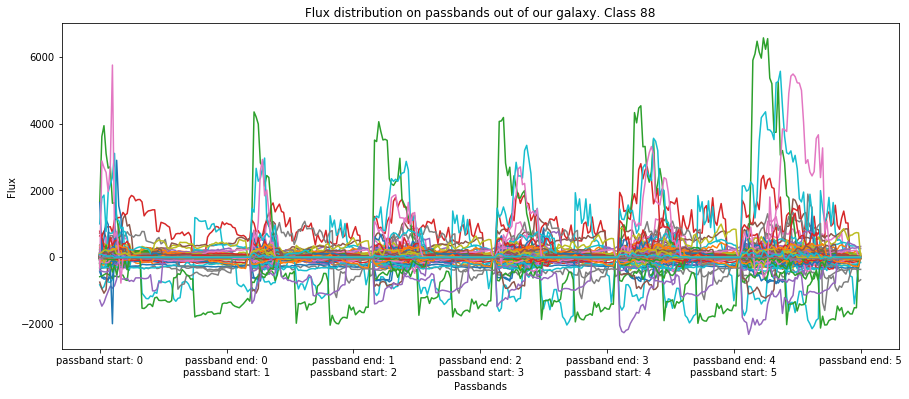

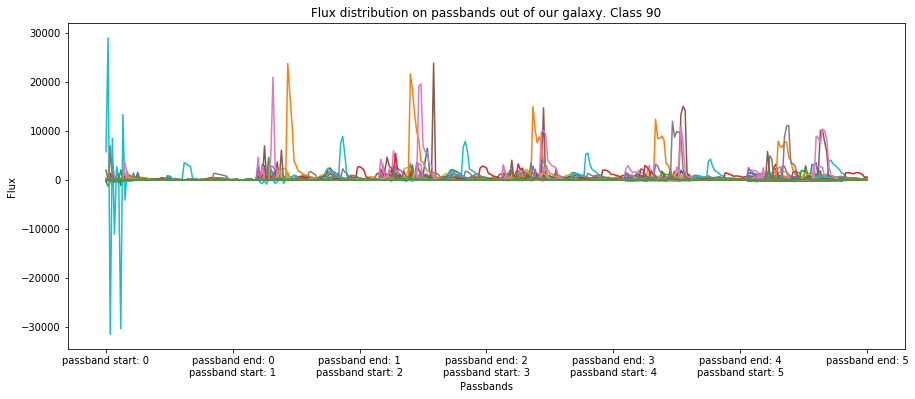

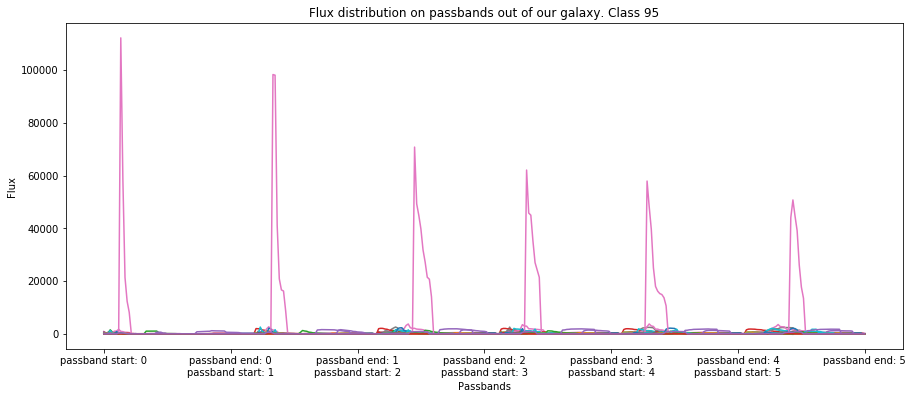

In [10]:
# should be corrected for clarity (shorted)
fig1, ax1 = plt.subplots(figsize=(15,6))
fig2, ax2 = plt.subplots(figsize=(15,6))
fig3, ax3 = plt.subplots(figsize=(15,6))
fig4, ax4 = plt.subplots(figsize=(15,6))
fig5, ax5 = plt.subplots(figsize=(15,6))
fig6, ax6 = plt.subplots(figsize=(15,6))
fig7, ax7 = plt.subplots(figsize=(15,6))
fig8, ax8 = plt.subplots(figsize=(15,6))
fig9, ax9 = plt.subplots(figsize=(15,6))
fig10, ax10 = plt.subplots(figsize=(15,6))
fig11, ax11 = plt.subplots(figsize=(15,6))
fig12, ax12 = plt.subplots(figsize=(15,6))
fig13, ax13 = plt.subplots(figsize=(15,6))
fig14, ax14 = plt.subplots(figsize=(15,6))
xlabels = ['passband start: 0', 'passband end: 0\npassband start: 1',
         'passband end: 1\npassband start: 2',
         'passband end: 2\npassband start: 3',
         'passband end: 3\npassband start: 4',
         'passband end: 4\npassband start: 5',
         'passband end: 5']

for i in set(training_dataset['object_id']):
    if pass_flu[i][0]['in_our_galaxy'].iloc[0] == 1:
        if pass_flu[i][0]['target'].iloc[0] == 'class_16':
            y = concatention()
            ax1.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_53':
            y = concatention()
            ax2.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_6':
            y = concatention()
            ax3.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_65':
            y = concatention()
            ax4.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_92':
            y = concatention()
            ax5.plot(range(length), y)
    else:
        if pass_flu[i][0]['target'].iloc[0] == 'class_15':
            y = concatention()
            ax6.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_42':
            y = concatention()
            ax7.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_52':
            y = concatention()
            ax8.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_62':
            y = concatention()
            ax9.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_64':
            y = concatention()
            ax10.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_67':
            y = concatention()
            ax11.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_88':
            y = concatention()
            ax12.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_90':
            y = concatention()
            ax13.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_95':
            y = concatention()
            ax14.plot(range(length), y)
            
ax1.set_title('Flux distribution on passbands in our galaxy. Class 16')
ax2.set_title('Flux distribution on passbands in our galaxy. Class 53')
ax3.set_title('Flux distribution on passbands in our galaxy. Class 6')
ax4.set_title('Flux distribution on passbands in our galaxy. Class 65')
ax5.set_title('Flux distribution on passbands in our galaxy. Class 92')
ax6.set_title('Flux distribution on passbands out of our galaxy. Class 15')
ax7.set_title('Flux distribution on passbands out of our galaxy. Class 42')
ax8.set_title('Flux distribution on passbands out of our galaxy. Class 52')
ax9.set_title('Flux distribution on passbands out of our galaxy. Class 62')
ax10.set_title('Flux distribution on passbands out of our galaxy. Class 64')
ax11.set_title('Flux distribution on passbands out of our galaxy. Class 67')
ax12.set_title('Flux distribution on passbands out of our galaxy. Class 88')
ax13.set_title('Flux distribution on passbands out of our galaxy. Class 90')
ax14.set_title('Flux distribution on passbands out of our galaxy. Class 95')
ax1.set_xlabel('Passbands')
ax2.set_xlabel('Passbands')
ax3.set_xlabel('Passbands')
ax4.set_xlabel('Passbands')
ax5.set_xlabel('Passbands')
ax6.set_xlabel('Passbands')
ax7.set_xlabel('Passbands')
ax8.set_xlabel('Passbands')
ax9.set_xlabel('Passbands')
ax10.set_xlabel('Passbands')
ax11.set_xlabel('Passbands')
ax12.set_xlabel('Passbands')
ax13.set_xlabel('Passbands')
ax14.set_xlabel('Passbands')
ax1.set_ylabel('Flux')
ax2.set_ylabel('Flux')
ax3.set_ylabel('Flux')
ax4.set_ylabel('Flux')
ax5.set_ylabel('Flux')
ax6.set_ylabel('Flux')
ax7.set_ylabel('Flux')
ax8.set_ylabel('Flux')
ax9.set_ylabel('Flux')
ax10.set_ylabel('Flux')
ax11.set_ylabel('Flux')
ax12.set_ylabel('Flux')
ax13.set_ylabel('Flux')
ax14.set_ylabel('Flux')
ax1.set_xticks(range(0, length, round(length/6)))
ax2.set_xticks(range(0, length, round(length/6)))
ax3.set_xticks(range(0, length, round(length/6)))
ax4.set_xticks(range(0, length, round(length/6)))
ax5.set_xticks(range(0, length, round(length/6)))
ax6.set_xticks(range(0, length, round(length/6)))
ax7.set_xticks(range(0, length, round(length/6)))
ax8.set_xticks(range(0, length, round(length/6)))
ax9.set_xticks(range(0, length, round(length/6)))
ax10.set_xticks(range(0, length, round(length/6)))
ax11.set_xticks(range(0, length, round(length/6)))
ax12.set_xticks(range(0, length, round(length/6)))
ax13.set_xticks(range(0, length, round(length/6)))
ax14.set_xticks(range(0, length, round(length/6)))
ax1.set_xticklabels(xlabels)
ax2.set_xticklabels(xlabels)
ax3.set_xticklabels(xlabels)
ax4.set_xticklabels(xlabels)
ax5.set_xticklabels(xlabels)
ax6.set_xticklabels(xlabels)
ax7.set_xticklabels(xlabels)
ax8.set_xticklabels(xlabels)
ax9.set_xticklabels(xlabels)
ax10.set_xticklabels(xlabels)
ax11.set_xticklabels(xlabels)
ax12.set_xticklabels(xlabels)
ax13.set_xticklabels(xlabels)
ax14.set_xticklabels(xlabels)

# Computing additional statistical features 
Cesium library usage

In [11]:
from cesium import featurize
features_to_use = ["amplitude",
                   "flux_percentile_ratio_mid20",
                   "flux_percentile_ratio_mid35",
                   "flux_percentile_ratio_mid50",
                   "flux_percentile_ratio_mid65",
                   "flux_percentile_ratio_mid80",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "percent_difference_flux_percentile",
                   "minimum",
                   "percent_amplitude",
                   "skew",
                   "period_fast",
                   "qso_log_chi2_qsonu",
                   "qso_log_chi2nuNULL_chi2nu",
                   "std",
                   "stetson_j",
                   "stetson_k",
                   "weighted_average",
                   "all_times_nhist_numpeaks",
                   "all_times_nhist_peak1_bin",
                   "all_times_nhist_peak2_bin",
                   "all_times_nhist_peak3_bin",
                   "all_times_nhist_peak4_bin",
                   "all_times_nhist_peak_1_to_2",
                   "all_times_nhist_peak_1_to_3",
                   "all_times_nhist_peak_1_to_4",
                   "all_times_nhist_peak_2_to_3",
                   "all_times_nhist_peak_2_to_4",
                   "all_times_nhist_peak_3_to_4",
                   "all_times_nhist_peak_val",
                   "avg_double_to_single_step",
                   "avg_err",
                   "avgt",
                   "cad_probs_1",
                   "cad_probs_10",
                   "cad_probs_20",
                   "cad_probs_30",
                   "cad_probs_40",
                   "cad_probs_50",
                   "cad_probs_100",
                   "cad_probs_500",
                   "cad_probs_1000",
                   "cad_probs_5000",
                   "cad_probs_10000",
                   "cad_probs_50000",
                   "cad_probs_100000",
                   "cad_probs_500000",
                   "cad_probs_1000000",
                   "cad_probs_5000000",
                   "cad_probs_10000000",
                   "cads_avg",
                   "cads_med",
                   "cads_std",
                   "mean",
                   "med_double_to_single_step",
                   "med_err",
                   "n_epochs",
                   "std_double_to_single_step",
                   "std_err",
                   "total_time"]

***Compute new features by cesium***

In [13]:
gb = dataset.groupby('object_id')
fset_cesium = featurize.featurize_time_series(times=[gb.get_group(x)['mjd'].values for x in gb.groups],
                                              values=[gb.get_group(x)['flux'].values for x in gb.groups],
                                              errors=[gb.get_group(x)['flux_err'].values for x in gb.groups],
                                              features_to_use=features_to_use)

In [ ]:
fset_cesium.insert(loc=0, column='object_id', value=dataset.groupby('object_id').sum().index)

In [ ]:
fset_cesium.columns = fset_cesium.columns.droplevel(1)

In [3]:
# fset_cesium.to_csv('fset_cesium.csv')
# fset_cesium = pd.read_csv('fset_cesium.csv', index_col=0)

In [17]:
fset_cesium.head()

object_id   amplitude  flux_percentile_ratio_mid20  \
0        615  880.533203                     0.000000   
1        713   14.753032                     0.001668   
2        730   33.234935                     0.028363   
3        745  118.144837                     0.024878   
4       1124   80.071971                     0.009432   

   flux_percentile_ratio_mid35  flux_percentile_ratio_mid50  \
0                     0.000000                     0.000000   
1                     0.005248                     0.018069   
2                     0.053155                     0.095119   
3                     0.048751                     0.082448   
4                     0.016523                     0.025336   

   flux_percentile_ratio_mid65  flux_percentile_ratio_mid80  \
0                     0.000000                     0.000000   
1                     0.123541                     0.254958   
2                     0.152027                     0.448602   
3                     0.147631                     0.291170   
4                     0.042001                     0.120672   

   percent_beyond_1_std     maximum      max_slope     ...      cads_avg  \
0              0.392045  660.626343  116805.166334     ...      2.489431   
1              0.425714   14.770886    1580.576999     ...      2.432148   
2              0.154545   47.310059    3949.860787     ...      2.595275   
3              0.082621  220.795212   11188.062767     ...      2.439160   
4              0.096591  143.600189   13330.938698     ...      2.489431   

   cads_med   cads_std        mean  med_double_to_single_step   med_err  \
0    0.0111  17.326857 -123.096998                   0.006542  3.835268   
1    0.0110  18.975828   -1.423351                   0.007325  1.998217   
2    0.0110  18.160894    2.267434                   0.006387  1.990851   
3    0.0111  16.745572    8.909206                   0.006367  1.819875   
4    0.0111  17.326857    7.145702                   0.006542  2.214854   

   n_epochs  std_double_to_single_step   std_err  total_time  
0     352.0                        NaN  1.742267    873.7903  
1     350.0                        NaN  1.507730    848.8198  
2     330.0                        NaN  1.718524    853.8455  
3     351.0                        NaN  3.532281    853.7060  
4     352.0                        NaN  1.931089    873.7903  

[5 rows x 66 columns]

***There are some NaN or Infinity values after computation***

In [19]:
fset_cesium.isnull().sum().head()

object_id                        0
amplitude                        0
flux_percentile_ratio_mid20    132
flux_percentile_ratio_mid35    176
flux_percentile_ratio_mid50    200
dtype: int64

***Impute missing values with median***

In [20]:
imp = Imputer(missing_values=np.nan, strategy='median')
x = imp.fit_transform(fset_cesium.values)
imp = Imputer(missing_values=np.inf, strategy='median')
x = imp.fit_transform(x)

In [21]:
fset_cesium_imputed = pd.DataFrame(data=x, columns=fset_cesium.columns)

In [4]:
# fset_cesium_imputed.to_csv('fset_cesium_imputed.csv')
# fset_cesium_imputed = pd.read_csv('fset_cesium_imputed.csv', index_col=0)

In [5]:
fset_cesium_imputed['object_id'] = fset_cesium_imputed['object_id'].apply(np.int)
fset_cesium_imputed.head()

object_id   amplitude  flux_percentile_ratio_mid20  \
0        615  880.533203                     0.000000   
1        713   14.753032                     0.001668   
2        730   33.234935                     0.028363   
3        745  118.144837                     0.024878   
4       1124   80.071971                     0.009432   

   flux_percentile_ratio_mid35  flux_percentile_ratio_mid50  \
0                     0.000000                     0.000000   
1                     0.005248                     0.018069   
2                     0.053155                     0.095119   
3                     0.048751                     0.082448   
4                     0.016523                     0.025336   

   flux_percentile_ratio_mid65  flux_percentile_ratio_mid80  \
0                     0.000000                     0.000000   
1                     0.123541                     0.254958   
2                     0.152027                     0.448602   
3                     0.147631                     0.291170   
4                     0.042001                     0.120672   

   percent_beyond_1_std     maximum      max_slope     ...      cads_avg  \
0              0.392045  660.626343  116805.166334     ...      2.489431   
1              0.425714   14.770886    1580.576999     ...      2.432148   
2              0.154545   47.310059    3949.860787     ...      2.595275   
3              0.082621  220.795212   11188.062767     ...      2.439160   
4              0.096591  143.600189   13330.938698     ...      2.489431   

   cads_med   cads_std        mean  med_double_to_single_step   med_err  \
0    0.0111  17.326857 -123.096998                   0.006542  3.835268   
1    0.0110  18.975828   -1.423351                   0.007325  1.998217   
2    0.0110  18.160894    2.267434                   0.006387  1.990851   
3    0.0111  16.745572    8.909206                   0.006367  1.819875   
4    0.0111  17.326857    7.145702                   0.006542  2.214854   

   n_epochs  std_double_to_single_step   std_err  total_time  
0     352.0                 194.500737  1.742267    873.7903  
1     350.0                 194.500737  1.507730    848.8198  
2     330.0                 194.500737  1.718524    853.8455  
3     351.0                 194.500737  3.532281    853.7060  
4     352.0                 194.500737  1.931089    873.7903  

[5 rows x 66 columns]

# Computing additional features (manual)

In [7]:
# extract each passband
for key, val in {'u': 0, 'g': 1, 'r': 2, 'i': 3, 'z': 4, 'y': 5}.items():
    dataset[key] = (dataset['passband']-val).apply(np.bool).apply(np.logical_not).apply(np.int)
dataset.head()

object_id         mjd  passband        flux   flux_err  detected  u  g  r  \
0        615  59750.4229         2 -544.810303   3.622952         1  0  0  1   
1        615  59750.4306         1 -816.434326   5.553370         1  0  1  0   
2        615  59750.4383         3 -471.385529   3.801213         1  0  0  0   
3        615  59750.4450         4 -388.984985  11.395031         1  0  0  0   
4        615  59752.4070         2 -681.858887   4.041204         1  0  0  1   

   i  z  y  
0  0  0  0  
1  0  0  0  
2  1  0  0  
3  0  1  0  
4  0  0  0

In [8]:
import gc
gc.enable()
dataset['flux_ratio_sq'] = np.power(dataset['flux'] / dataset['flux_err'], 2.0)
dataset['flux_by_flux_ratio_sq'] = dataset['flux'] * dataset['flux_ratio_sq']

aggs = {
    'mjd': ['min', 'max', 'size'],
    'passband': ['min', 'max', 'mean', 'median', 'std'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
    'r': ['sum', 'mean'],
    'g': ['sum', 'mean'],
    'i': ['sum', 'mean'],
    'u': ['sum', 'mean'],
    'z': ['sum', 'mean'],
    'y': ['sum', 'mean'],
}

agg_train = dataset.groupby('object_id').agg(aggs)
new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
agg_train.columns = new_columns
agg_train['mjd_diff'] = agg_train['mjd_max'] - agg_train['mjd_min']
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean']

del agg_train['mjd_max'], agg_train['mjd_min']
agg_train.head()

gc.collect()

140

In [9]:
agg_train = agg_train.reset_index()

In [10]:
agg_train.head()

object_id  mjd_size  passband_min  passband_max  passband_mean  \
0        615       352             0             5       2.457386   
1        713       350             0             5       2.400000   
2        730       330             0             5       2.336364   
3        745       351             0             5       2.378917   
4       1124       352             0             5       2.457386   

   passband_median  passband_std     flux_min    flux_max   flux_mean  \
0              2.0      1.720797 -1100.440063  660.626343 -123.096998   
1              2.0      1.746056   -14.735178   14.770886   -1.423351   
2              2.0      1.758750   -19.159811   47.310059    2.267434   
3              2.0      1.747328   -15.494463  220.795212    8.909206   
4              2.0      1.720797   -16.543753  143.600189    7.145702   

     ...        u_mean  z_sum    z_mean  y_sum    y_mean  mjd_diff  \
0    ...      0.178977     58  0.164773     57  0.161932  873.7903   
1    ...      0.200000     56  0.160000     56  0.160000  848.8198   
2    ...      0.218182     51  0.154545     51  0.154545  853.8455   
3    ...      0.205128     56  0.159544     55  0.156695  853.7060   
4    ...      0.178977     58  0.164773     57  0.161932  873.7903   

     flux_diff  flux_dif2  flux_w_mean  flux_dif3  
0  1761.066406 -14.306331  -327.742307  -5.373326  
1    29.506064 -20.730002    -4.884564  -6.040676  
2    66.469870  29.315018    25.373110   2.619697  
3   236.289675  26.521968   152.835617   1.546038  
4   160.143942  22.411225    87.856390   1.822792  

[5 rows x 41 columns]

In [11]:
agg_train.shape

(7848, 41)

In [12]:
fset_cesium_imputed.shape

(7848, 66)

***Merging two training datasets (manually computed features and from cesium)***

In [13]:
mer_data = pd.merge(agg_train, fset_cesium_imputed)

In [14]:
mer_data.shape

(7848, 106)

In [15]:
mer_data.head()

object_id  mjd_size  passband_min  passband_max  passband_mean  \
0        615       352             0             5       2.457386   
1        713       350             0             5       2.400000   
2        730       330             0             5       2.336364   
3        745       351             0             5       2.378917   
4       1124       352             0             5       2.457386   

   passband_median  passband_std     flux_min    flux_max   flux_mean  \
0              2.0      1.720797 -1100.440063  660.626343 -123.096998   
1              2.0      1.746056   -14.735178   14.770886   -1.423351   
2              2.0      1.758750   -19.159811   47.310059    2.267434   
3              2.0      1.747328   -15.494463  220.795212    8.909206   
4              2.0      1.720797   -16.543753  143.600189    7.145702   

      ...      cads_avg  cads_med   cads_std        mean  \
0     ...      2.489431    0.0111  17.326857 -123.096998   
1     ...      2.432148    0.0110  18.975828   -1.423351   
2     ...      2.595275    0.0110  18.160894    2.267434   
3     ...      2.439160    0.0111  16.745572    8.909206   
4     ...      2.489431    0.0111  17.326857    7.145702   

   med_double_to_single_step   med_err  n_epochs  std_double_to_single_step  \
0                   0.006542  3.835268     352.0                 194.500737   
1                   0.007325  1.998217     350.0                 194.500737   
2                   0.006387  1.990851     330.0                 194.500737   
3                   0.006367  1.819875     351.0                 194.500737   
4                   0.006542  2.214854     352.0                 194.500737   

    std_err  total_time  
0  1.742267    873.7903  
1  1.507730    848.8198  
2  1.718524    853.8455  
3  3.532281    853.7060  
4  1.931089    873.7903  

[5 rows x 106 columns]

# More data exploratory

In [16]:
meta_dataset = pd.read_csv("/media/amadeusz/78F69DA1F69D6064/Users/Amadeusz/Downloads/all/training_set_metadata.csv")
column_names = {6: "class_6", 15: "class_15", 16: "class_16", 42: "class_42", 52: "class_52", 53: "class_53",
                62: "class_62", 64: "class_64", 65: "class_65", 67: "class_67", 88: "class_88", 90: "class_90",
                92: "class_92", 95: "class_95"}
meta_dataset["target"] = list(map(lambda name: column_names[name], meta_dataset["target"]))
meta_dataset.head()

# ra - right ascension, sky coordinate: co-longitude in degrees. Float32
#
# decl - declination, sky coordinate: co-latitude in degrees. Float32
#
# gal_l - galactic longitude in degrees. Float32
#
# gal_b - galactic latitude in degrees. Float32
#
# ddf - A flag to identify the object as coming from the DDF survey area 
#       (with value DDF = 1 for the DDF, DDF = 0 for the WFD survey). 
#       Note that while the DDF fields are contained within the full WFD survey area, the DDF fluxes have 
#       significantly smaller uncertainties. Boolean
#
# hostgal_specz - the spectroscopic redshift of the source. This is an extremely accurate measure of redshift, 
#                 available for the training set and a small fraction of the test set. Float32
#
# hostgal_photoz - The photometric redshift of the host galaxy of the astronomical source. 
#                  While this is meant to be a proxy for hostgal_specz, there can be large differences between 
#                  the two and should be regarded as a far less accurate version of hostgal_specz. Float32
#
# hostgal_photoz_err - The uncertainty on the hostgal_photoz based on LSST survey projections. Float32
# 
# distmod - The distance to the source calculated from hostgal_photoz and using general relativity. Float32
# 
# mwebv - MW E(B-V). this ‘extinction’ of light is a property of the Milky Way (MW) dust along the line of sight 
#         to the astronomical source, and is thus a function of the sky coordinates of the source ra, decl. 
#       This is used to determine a passband dependent dimming and redenning of light from astronomical sources 
#       as described in subsection 2.1, and based on the Schlafly et al. (2011) and Schlegel et al. (1998) dust models. Float32

object_id          ra       decl       gal_l      gal_b  ddf  \
0        615  349.046051 -61.943836  320.796530 -51.753706    1   
1        713   53.085938 -27.784405  223.525509 -54.460748    1   
2        730   33.574219  -6.579593  170.455585 -61.548219    1   
3        745    0.189873 -45.586655  328.254458 -68.969298    1   
4       1124  352.711273 -63.823658  316.922299 -51.059403    1   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv    target  
0         0.0000          0.0000              0.0000      NaN  0.017  class_92  
1         1.8181          1.6267              0.2552  45.4063  0.007  class_88  
2         0.2320          0.2262              0.0157  40.2561  0.021  class_42  
3         0.3037          0.2813              1.1523  40.7951  0.007  class_90  
4         0.1934          0.2415              0.0176  40.4166  0.024  class_90

In [17]:
# from description -> NaN values in "distmod" teels us that this object is in our galaxy (no redshift provided/hostgal),
# distmod is calculated from redshift via general relativity
# create new features (in_our_galaxy)
meta_dataset['in_our_galaxy'] = meta_dataset['distmod'].apply(np.isnan).astype(int)
meta_dataset.head()

object_id          ra       decl       gal_l      gal_b  ddf  \
0        615  349.046051 -61.943836  320.796530 -51.753706    1   
1        713   53.085938 -27.784405  223.525509 -54.460748    1   
2        730   33.574219  -6.579593  170.455585 -61.548219    1   
3        745    0.189873 -45.586655  328.254458 -68.969298    1   
4       1124  352.711273 -63.823658  316.922299 -51.059403    1   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv  \
0         0.0000          0.0000              0.0000      NaN  0.017   
1         1.8181          1.6267              0.2552  45.4063  0.007   
2         0.2320          0.2262              0.0157  40.2561  0.021   
3         0.3037          0.2813              1.1523  40.7951  0.007   
4         0.1934          0.2415              0.0176  40.4166  0.024   

     target  in_our_galaxy  
0  class_92              1  
1  class_88              0  
2  class_42              0  
3  class_90              0  
4  class_90              0

# Empty value veryfication

In [18]:
meta_dataset.isnull().sum()

object_id                0
ra                       0
decl                     0
gal_l                    0
gal_b                    0
ddf                      0
hostgal_specz            0
hostgal_photoz           0
hostgal_photoz_err       0
distmod               2325
mwebv                    0
target                   0
in_our_galaxy            0
dtype: int64

In [19]:
print("distmod missing data in %: {}".format(meta_dataset.isnull().sum()[-4]*100/meta_dataset.shape[0]))

distmod missing data in %: 29.625382262996943


In [20]:
# put 0 instead of NaN in distmod (in that way we can store distance for objects out of our galaxy)
meta_dataset = meta_dataset.fillna(0)
meta_dataset.head()

object_id          ra       decl       gal_l      gal_b  ddf  \
0        615  349.046051 -61.943836  320.796530 -51.753706    1   
1        713   53.085938 -27.784405  223.525509 -54.460748    1   
2        730   33.574219  -6.579593  170.455585 -61.548219    1   
3        745    0.189873 -45.586655  328.254458 -68.969298    1   
4       1124  352.711273 -63.823658  316.922299 -51.059403    1   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv  \
0         0.0000          0.0000              0.0000   0.0000  0.017   
1         1.8181          1.6267              0.2552  45.4063  0.007   
2         0.2320          0.2262              0.0157  40.2561  0.021   
3         0.3037          0.2813              1.1523  40.7951  0.007   
4         0.1934          0.2415              0.0176  40.4166  0.024   

     target  in_our_galaxy  
0  class_92              1  
1  class_88              0  
2  class_42              0  
3  class_90              0  
4  class_90              0

In [21]:
meta_dataset.isnull().sum()

object_id             0
ra                    0
decl                  0
gal_l                 0
gal_b                 0
ddf                   0
hostgal_specz         0
hostgal_photoz        0
hostgal_photoz_err    0
distmod               0
mwebv                 0
target                0
in_our_galaxy         0
dtype: int64

# Drop columns contain not valuable data
Training dataset contains hostgal_specz data, but test dataset (see next cells) do not.

In [22]:
meta_dataset = meta_dataset.drop(['hostgal_specz'], axis=1)
meta_dataset.head()

object_id          ra       decl       gal_l      gal_b  ddf  \
0        615  349.046051 -61.943836  320.796530 -51.753706    1   
1        713   53.085938 -27.784405  223.525509 -54.460748    1   
2        730   33.574219  -6.579593  170.455585 -61.548219    1   
3        745    0.189873 -45.586655  328.254458 -68.969298    1   
4       1124  352.711273 -63.823658  316.922299 -51.059403    1   

   hostgal_photoz  hostgal_photoz_err  distmod  mwebv    target  in_our_galaxy  
0          0.0000              0.0000   0.0000  0.017  class_92              1  
1          1.6267              0.2552  45.4063  0.007  class_88              0  
2          0.2262              0.0157  40.2561  0.021  class_42              0  
3          0.2813              1.1523  40.7951  0.007  class_90              0  
4          0.2415              0.0176  40.4166  0.024  class_90              0

# Plot objects on the sky map (per target class)

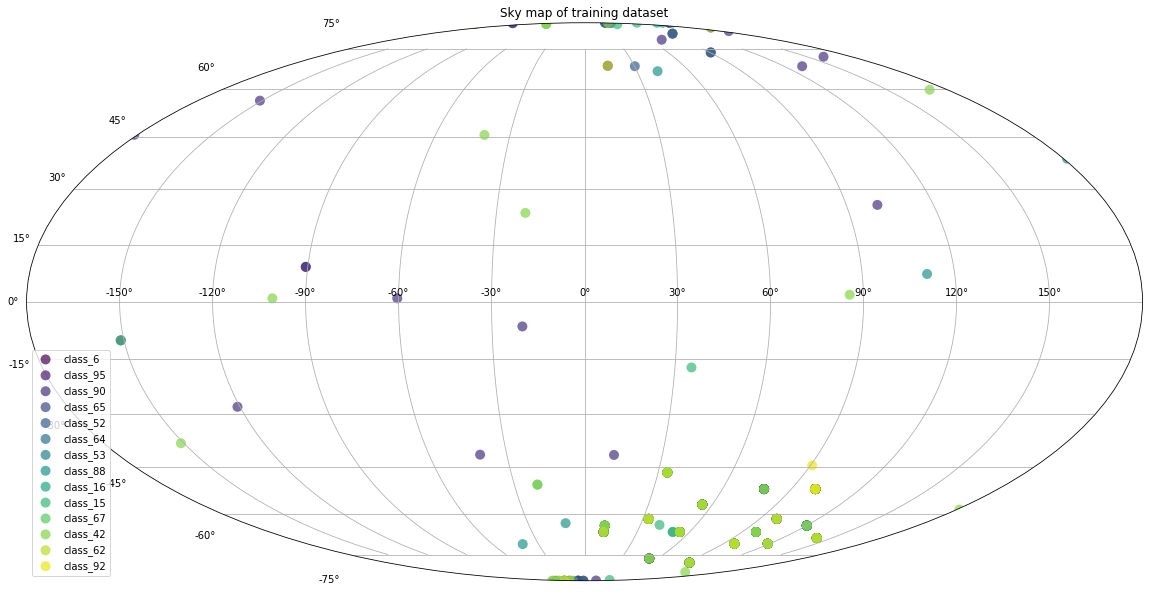

In [23]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='mollweide')
data = meta_dataset[['ra', 'decl']]
data['target'] = meta_dataset['target']
category = list()
colors = plt.get_cmap('viridis').colors[::19]
for cat in set(meta_dataset['target']):
    category.append(data[data['target'].str.contains(cat)])
classes = list(set(meta_dataset['target']))
for cat, color, class_ in zip(category, colors, classes):
    ax.scatter(cat['ra'], cat['decl'], c=color, label=class_, edgecolors='none', s=100, alpha=0.7)
ax.legend()
ax.grid(True)
plt.title('Sky map of training dataset')
fig.savefig('sky_train_plot.pdf')

# How many objects of different type are in our galaxy?
We can clearly see that in our galaxy there are only specific type of objects (classes: 16, 53, 6, 65, 92).  
In test data we can cluster objects based on that.

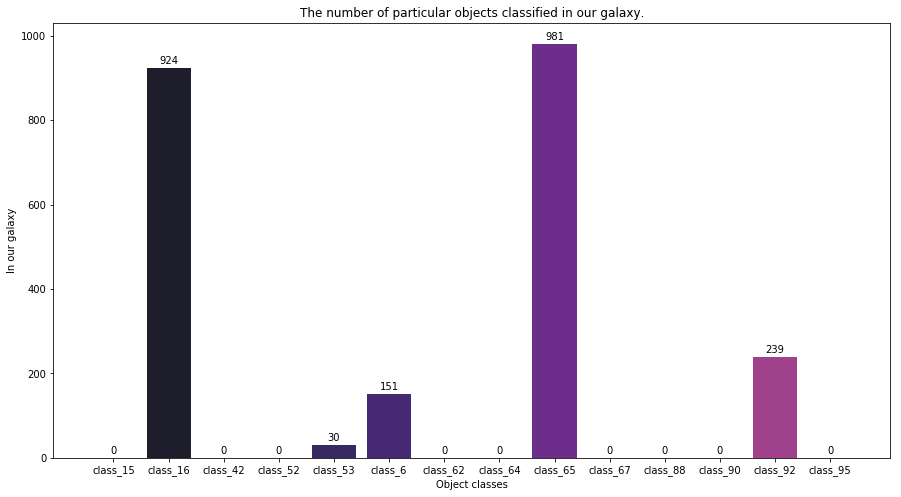

In [45]:
colors = plt.get_cmap('magma').colors[::9]
data = meta_dataset[['target', 'in_our_galaxy']]
data['in_our_galaxy'] = data['in_our_galaxy']
data = data.groupby('target').sum()
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.bar(data.index, data['in_our_galaxy'], color=colors, alpha=0.9)
ax.set_xlabel('Object classes')
ax.set_ylabel('In our galaxy')
plt.title('The number of particular objects classified in our galaxy.')
for i, rect in enumerate(data['in_our_galaxy']):
    ax.text(i, rect+10,rect, ha='center')

# Comparison of WFD and DDF objects detection number.  
PLAsTiCC simulates the "Wide-Fast-Deep" Survey - the main LSST program, and the "Deep Drilling Fields" - a few small regions where LSST will get more observations for specialized scientific studies.

Which objects are in the WFD vs the DDF are specified by the ddf_bool column in the header (1 if in DDF, 0 otherwise).

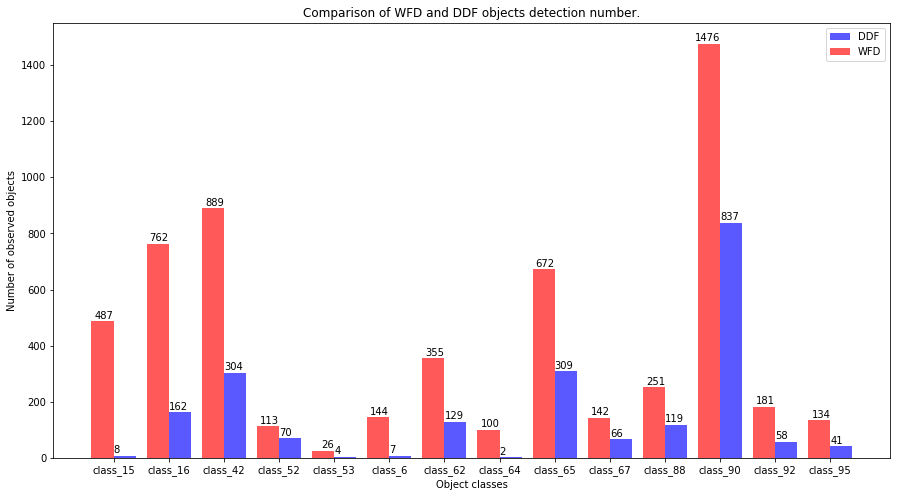

In [46]:
colors = plt.get_cmap('magma').colors[::14]
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

data = meta_dataset[['target', 'ddf']]
data = data.groupby('target').sum()
p1 = ax.bar(np.arange(len(data.index))+0.2, data['ddf'], color='blue', alpha=0.65, width=0.4)
for i, rect in enumerate(data['ddf']):
    ax.text(i, rect+10,rect, ha='left')
    
data_2 = meta_dataset[['target', 'ddf']]
data_2['wfd'] = np.logical_xor(data_2['ddf'],1).astype(int)
data_2 = data_2.groupby('target').sum()
p2 = ax.bar(np.arange(len(data_2.index))-0.2, data_2['wfd'], color='red', alpha=0.65, width=0.4)
for i, rect in enumerate(data_2['wfd']):
    ax.text(i, rect+10,rect, ha='right')
    
ax.set_xticklabels(data.index)
ax.set_xticks(np.arange(len(data_2.index)))
ax.set_xlabel('Object classes')
ax.set_ylabel('Number of observed objects')
plt.title('Comparison of WFD and DDF objects detection number.')
ax.legend((p1,p2), ['DDF', 'WFD'])

***Check missing data in test dataset***

Based on that we can remove non valuable feature from training dataset (hostgal_specz).  
Hostgal_specz is a feature where scientist/astronomers measured very precisly redshift of particular object.
It is time consuming so mostly in all test observation we do not have such deep precision.
Instead of this, scientist measured hostgal_photoz which is far less accurate.

In [48]:
meta_test = pd.read_csv('/media/amadeusz/78F69DA1F69D6064/Users/Amadeusz/Downloads/all/test_set_metadata.csv')
n_samples = meta_test.shape[0]
missing_values = meta_test.isnull().sum()

In [49]:
for val, ind in zip(missing_values, missing_values.index):
    print("{} has {:2.2f}%  missing values.".format(ind, val*100/n_samples))
# hostgal_specz - missing 96%+ samples -> insufficient data for analysis and ML algorithms, need to be dropped
%xdel meta_test

object_id has 0.00%  missing values.
ra has 0.00%  missing values.
decl has 0.00%  missing values.
gal_l has 0.00%  missing values.
gal_b has 0.00%  missing values.
ddf has 0.00%  missing values.
hostgal_specz has 96.55%  missing values.
hostgal_photoz has 0.00%  missing values.
hostgal_photoz_err has 0.00%  missing values.
distmod has 11.18%  missing values.
mwebv has 0.00%  missing values.


# Merg training dataset and meta_dataset

In [24]:
training_dataset = pd.merge(mer_data, meta_dataset) # with additional computed features
training_dataset.head()

object_id  mjd_size  passband_min  passband_max  passband_mean  \
0        615       352             0             5       2.457386   
1        713       350             0             5       2.400000   
2        730       330             0             5       2.336364   
3        745       351             0             5       2.378917   
4       1124       352             0             5       2.457386   

   passband_median  passband_std     flux_min    flux_max   flux_mean  \
0              2.0      1.720797 -1100.440063  660.626343 -123.096998   
1              2.0      1.746056   -14.735178   14.770886   -1.423351   
2              2.0      1.758750   -19.159811   47.310059    2.267434   
3              2.0      1.747328   -15.494463  220.795212    8.909206   
4              2.0      1.720797   -16.543753  143.600189    7.145702   

       ...             decl       gal_l      gal_b  ddf  hostgal_photoz  \
0      ...       -61.943836  320.796530 -51.753706    1          0.0000   
1      ...       -27.784405  223.525509 -54.460748    1          1.6267   
2      ...        -6.579593  170.455585 -61.548219    1          0.2262   
3      ...       -45.586655  328.254458 -68.969298    1          0.2813   
4      ...       -63.823658  316.922299 -51.059403    1          0.2415   

   hostgal_photoz_err  distmod  mwebv    target  in_our_galaxy  
0              0.0000   0.0000  0.017  class_92              1  
1              0.2552  45.4063  0.007  class_88              0  
2              0.0157  40.2561  0.021  class_42              0  
3              1.1523  40.7951  0.007  class_90              0  
4              0.0176  40.4166  0.024  class_90              0  

[5 rows x 117 columns]

In [26]:
# training_dataset.to_csv('training_dataset.csv', index=False)
training_dataset = pd.read_csv('training_dataset.csv', index_col=0)
training_dataset.head()

mjd_size  passband_min  passband_max  passband_mean  \
object_id                                                        
615             352             0             5       2.457386   
713             350             0             5       2.400000   
730             330             0             5       2.336364   
745             351             0             5       2.378917   
1124            352             0             5       2.457386   

           passband_median  passband_std     flux_min    flux_max   flux_mean  \
object_id                                                                       
615                    2.0      1.720797 -1100.440063  660.626343 -123.096998   
713                    2.0      1.746056   -14.735178   14.770886   -1.423351   
730                    2.0      1.758750   -19.159811   47.310059    2.267434   
745                    2.0      1.747328   -15.494463  220.795212    8.909206   
1124                   2.0      1.720797   -16.543753  143.600189    7.145702   

           flux_median      ...             decl       gal_l      gal_b  ddf  \
object_id                   ...                                                
615         -89.477524      ...       -61.943836  320.796530 -51.753706    1   
713          -0.873033      ...       -27.784405  223.525509 -54.460748    1   
730           0.409172      ...        -6.579593  170.455585 -61.548219    1   
745           1.035895      ...       -45.586655  328.254458 -68.969298    1   
1124          1.141288      ...       -63.823658  316.922299 -51.059403    1   

           hostgal_photoz  hostgal_photoz_err  distmod  mwebv    target  \
object_id                                                                 
615                0.0000              0.0000   0.0000  0.017  class_92   
713                1.6267              0.2552  45.4063  0.007  class_88   
730                0.2262              0.0157  40.2561  0.021  class_42   
745                0.2813              1.1523  40.7951  0.007  class_90   
1124               0.2415              0.0176  40.4166  0.024  class_90   

           in_our_galaxy  
object_id                 
615                    1  
713                    0  
730                    0  
745                    0  
1124                   0  

[5 rows x 116 columns]

# The number of object detected in particular passband

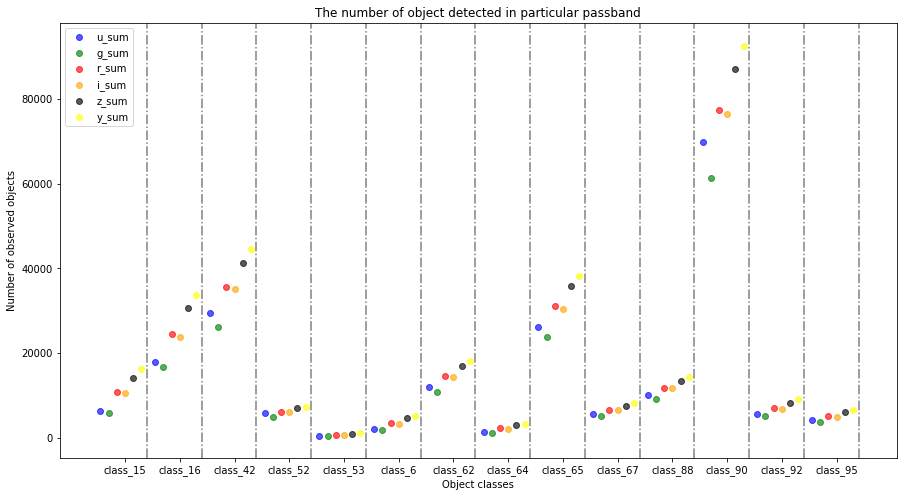

In [27]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

data = training_dataset[['target', 'g_sum', 'r_sum', 'z_sum', 'u_sum', 'i_sum', 'y_sum']]
data = data.groupby('target').sum()
x = np.arange(len(data.index))
for i in range(len(data.index)):
    ax.axvline(x=i+0.4, linestyle='-.', color='grey')
    
p1 = ax.scatter(x-0.45, data['u_sum'], color='blue', alpha=0.65)
p2 = ax.scatter(x-0.3, data['g_sum'], color='green', alpha=0.65)
p3 = ax.scatter(x-0.15, data['r_sum'], color='red', alpha=0.65)
p4 = ax.scatter(x, data['i_sum'], color='orange', alpha=0.65)
p5 = ax.scatter(x+0.15, data['z_sum'], color='black', alpha=0.65)
p6 = ax.scatter(x+0.3, data['y_sum'], color='yellow', alpha=0.65)

ax.set_xticklabels(data.index)
ax.set_xticks(np.arange(len(data.index)))
ax.set_xlabel('Object classes')
ax.set_ylabel('Number of observed objects')
plt.title('The number of object detected in particular passband')
ax.legend((p1,p2, p3, p4, p5, p6), ['u_sum', 'g_sum', 'r_sum', 'i_sum', 'z_sum', 'y_sum'])

***Columns analysis***  
**Columns contain only one value**  
Column: passband_min, std = 0  
Column: passband_max, std = 0  
Column: cad_probs_1, std = 0  
Column: cad_probs_500000, std = 0  
Column: cad_probs_1000000, std = 0  
Column: cad_probs_5000000, std = 0  
Column: cad_probs_10000000, std = 0  

In [16]:
training_dataset = pd.read_csv('https://github.com/amasend/cosmos/raw/master/training_dataset.csv')
for col in training_dataset.columns.values:
    try:
        if training_dataset[col].describe()['std'] == 0:
            print("Column: {}, std = 0".format(col))
    except:
        pass

Column: passband_min, std = 0
Column: passband_max, std = 0
Column: cad_probs_1, std = 0
Column: cad_probs_500000, std = 0
Column: cad_probs_1000000, std = 0
Column: cad_probs_5000000, std = 0
Column: cad_probs_10000000, std = 0


In [17]:
training_dataset = training_dataset.drop(['passband_min', 'passband_max', 'cad_probs_1', 'cad_probs_500000',
                                          'cad_probs_1000000', 'cad_probs_5000000', 'cad_probs_10000000'], axis=1)

***Histograms comparison for standard data and various transforms***  
 lambda = -1. is a reciprocal transform.  
 lambda = -0.5 is a reciprocal square root transform.  
 lambda = 0.0 is a log transform.  
 lambda = 0.5 is a square root transform.  
 lambda = 1.0 is no transform.  

Logarithmic transform failed to apply. Column: flux_min
Reciprocal transform failed to apply. Column: flux_min
Reciprocal square root transform failed to apply. Column: flux_min
Square root transform failed to apply. Column: flux_min
Logarithmic transform failed to apply. Column: flux_max
Reciprocal transform failed to apply. Column: flux_max
Reciprocal square root transform failed to apply. Column: flux_max
Square root transform failed to apply. Column: flux_max
Logarithmic transform failed to apply. Column: flux_mean
Reciprocal transform failed to apply. Column: flux_mean
Reciprocal square root transform failed to apply. Column: flux_mean
Square root transform failed to apply. Column: flux_mean
Logarithmic transform failed to apply. Column: flux_median
Reciprocal transform failed to apply. Column: flux_median
Reciprocal square root transform failed to apply. Column: flux_median
Square root transform failed to apply. Column: flux_median
Logarithmic transform failed to apply. Column: f

Square root transform failed to apply. Column: cad_probs_500
Logarithmic transform failed to apply. Column: cad_probs_1000
Reciprocal transform failed to apply. Column: cad_probs_1000
Reciprocal square root transform failed to apply. Column: cad_probs_1000
Square root transform failed to apply. Column: cad_probs_1000
Logarithmic transform failed to apply. Column: mean
Reciprocal transform failed to apply. Column: mean
Reciprocal square root transform failed to apply. Column: mean
Square root transform failed to apply. Column: mean
Logarithmic transform failed to apply. Column: med_double_to_single_step
Reciprocal transform failed to apply. Column: med_double_to_single_step
Reciprocal square root transform failed to apply. Column: med_double_to_single_step
Square root transform failed to apply. Column: med_double_to_single_step
Logarithmic transform failed to apply. Column: decl
Reciprocal transform failed to apply. Column: decl
Reciprocal square root transform failed to apply. Column: 

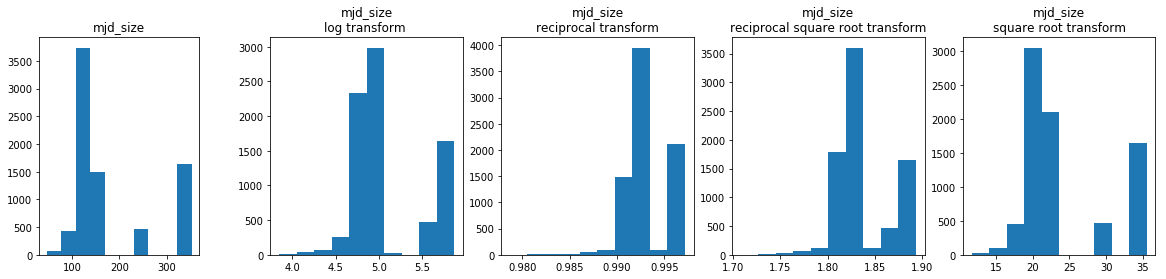

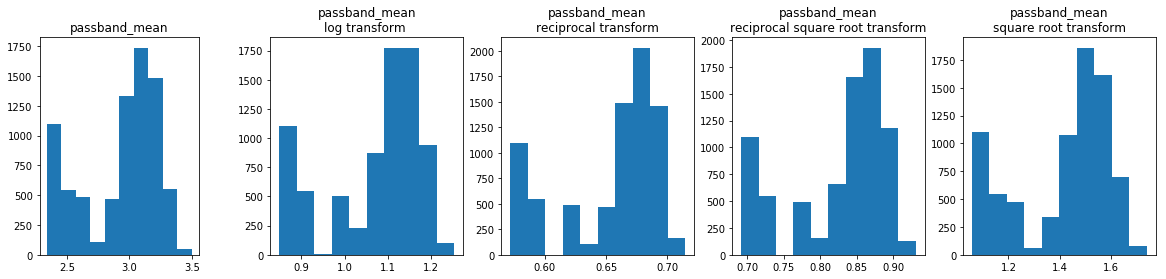

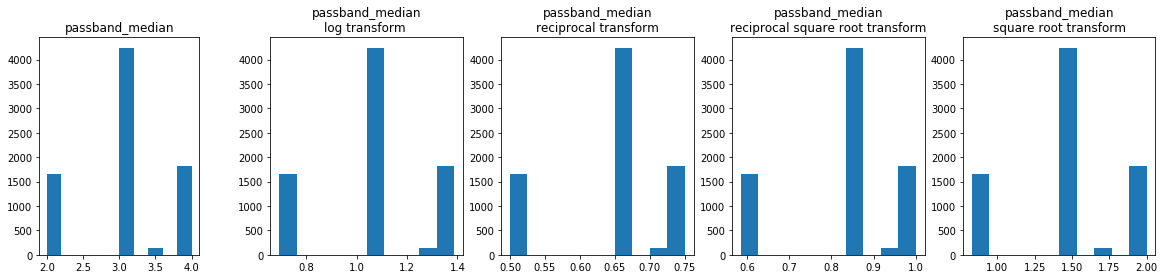

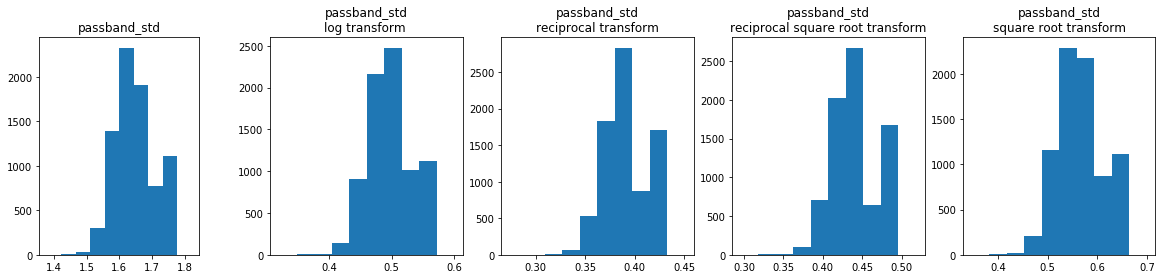

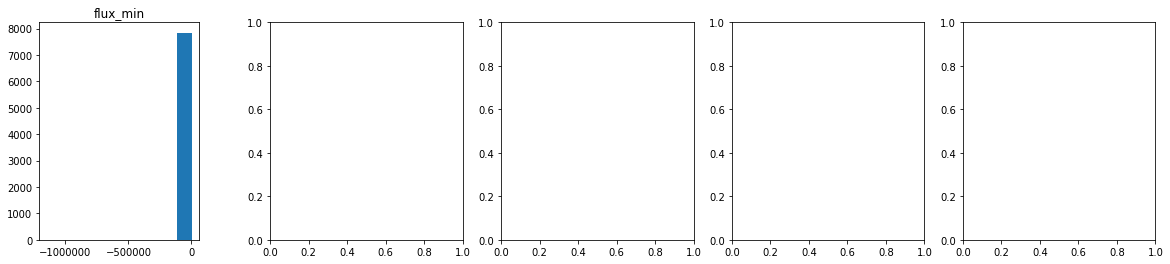

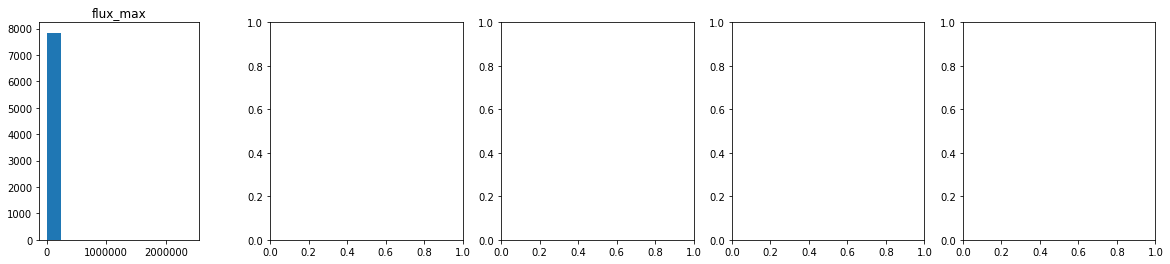

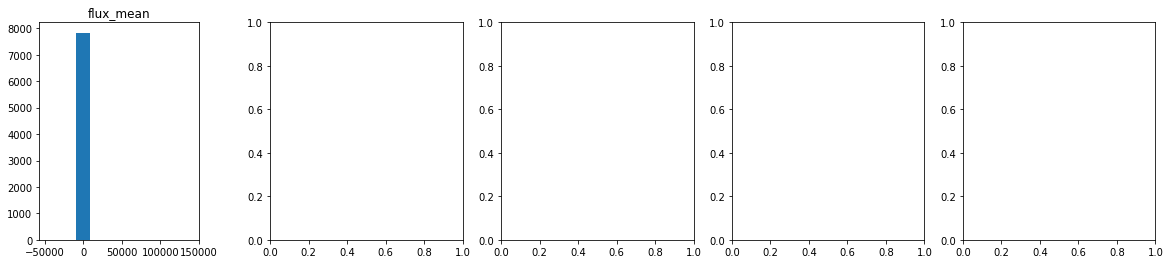

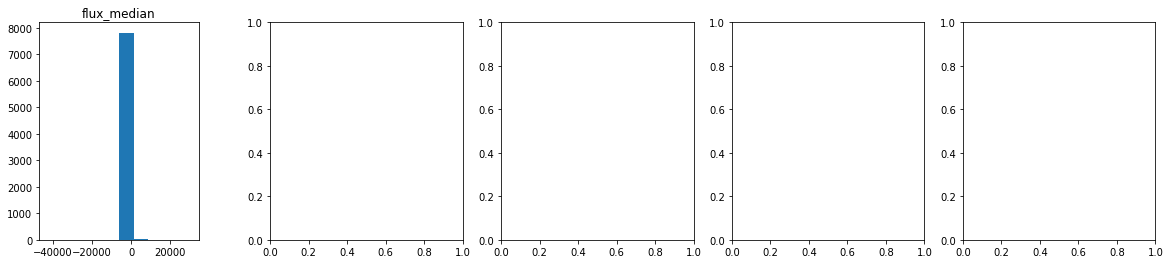

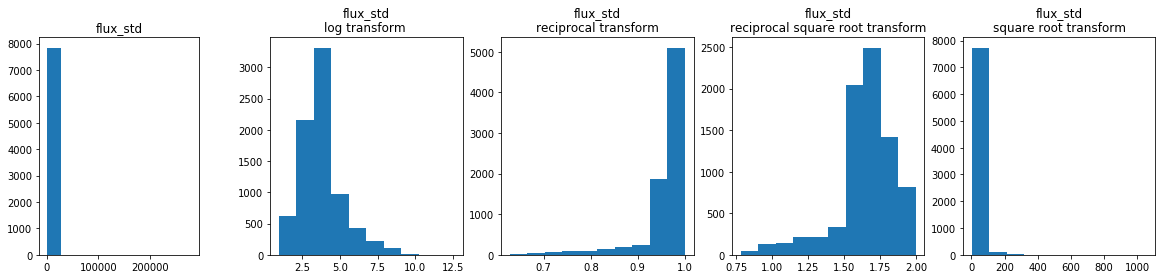

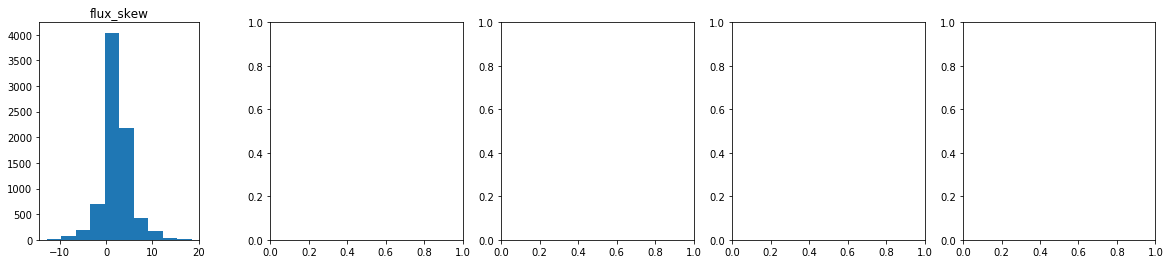

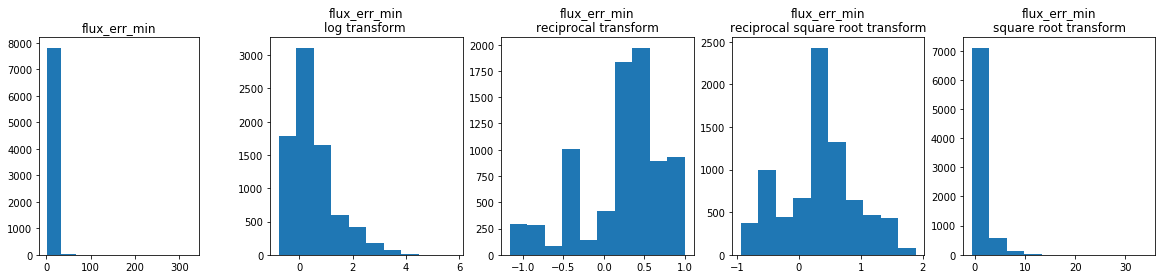

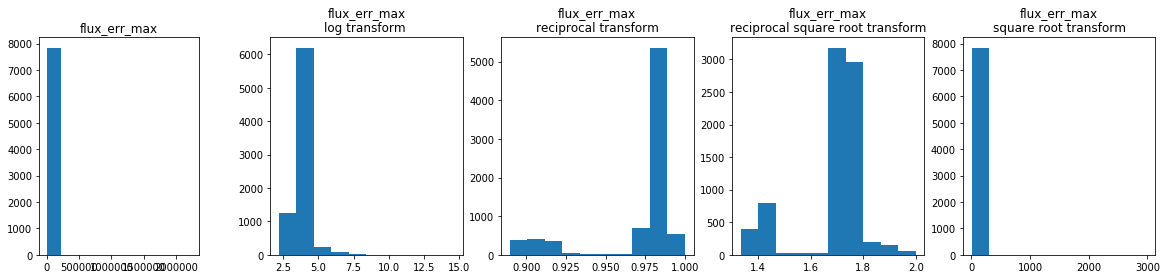

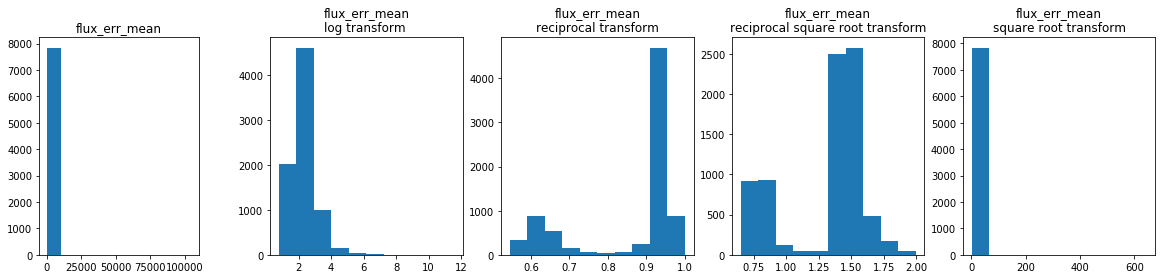

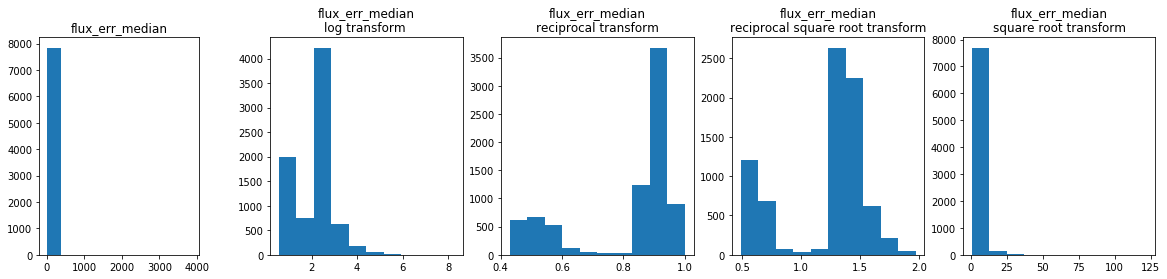

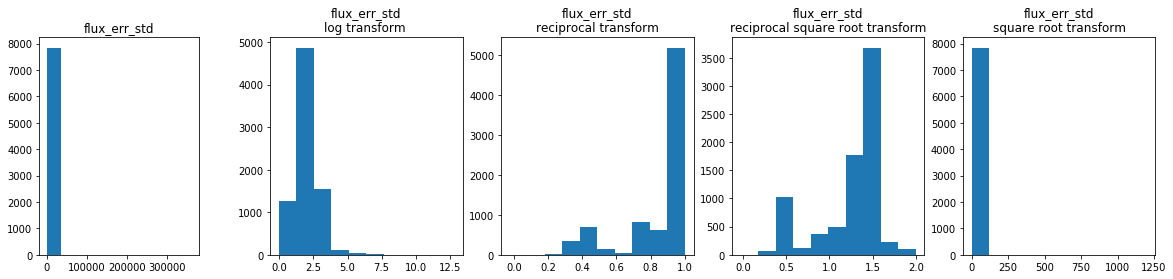

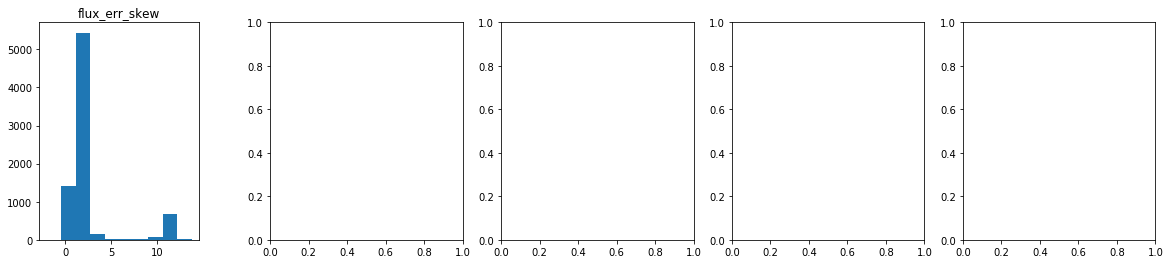

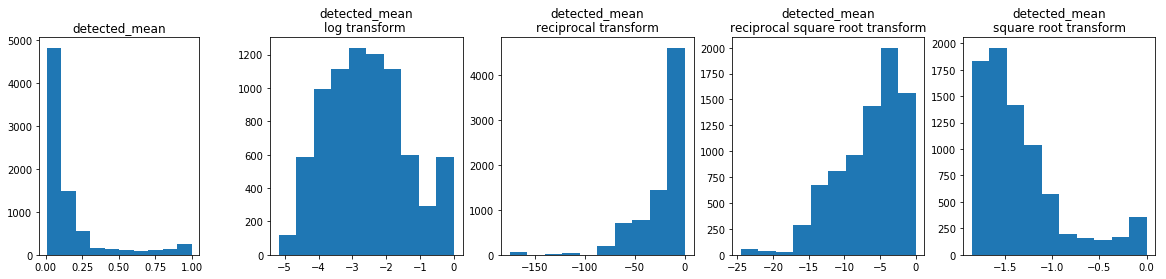

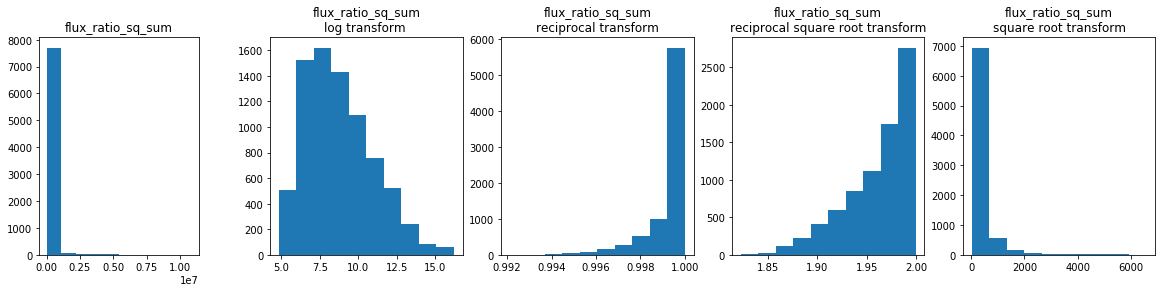

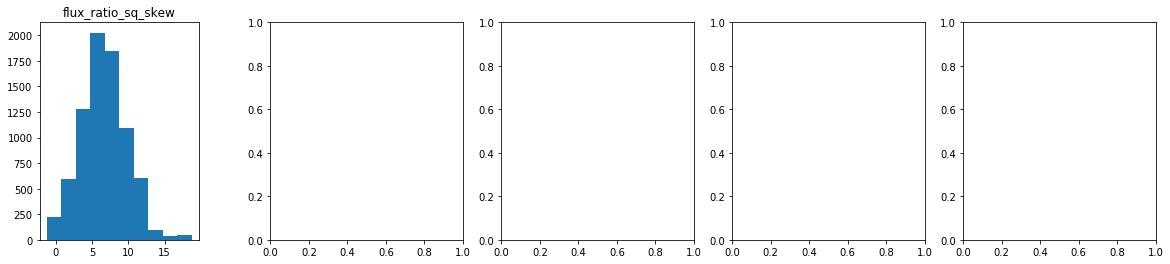

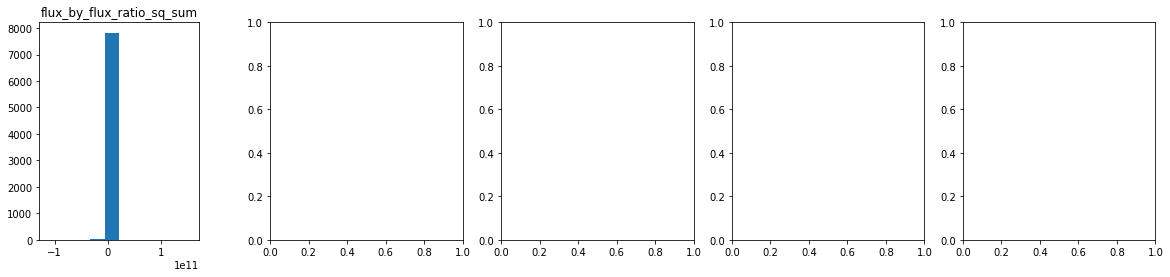

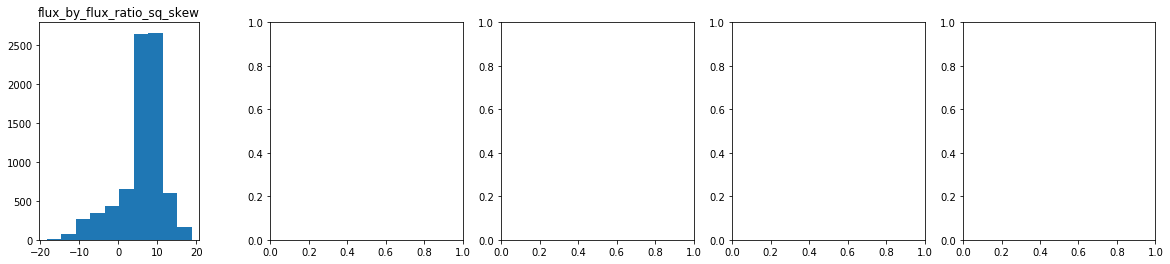

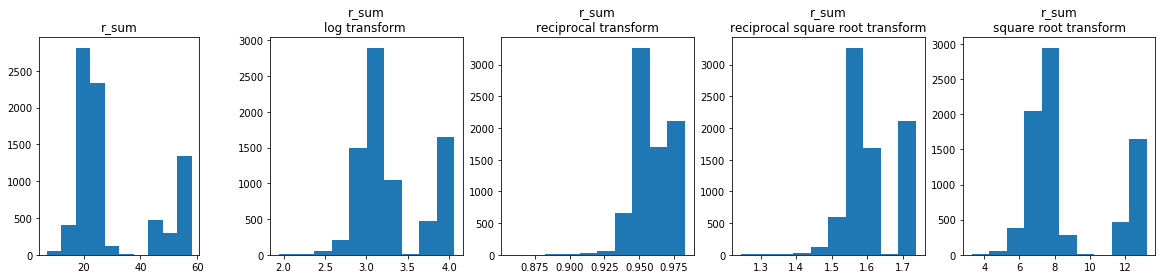

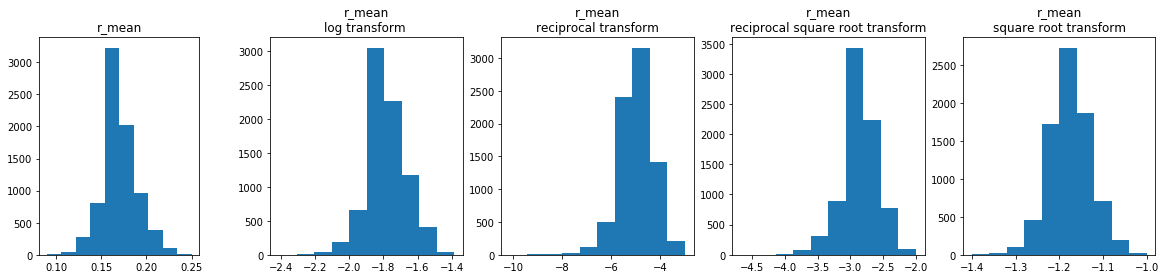

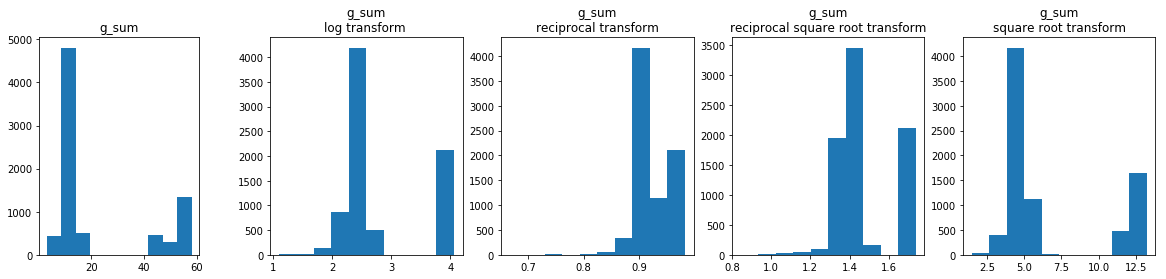

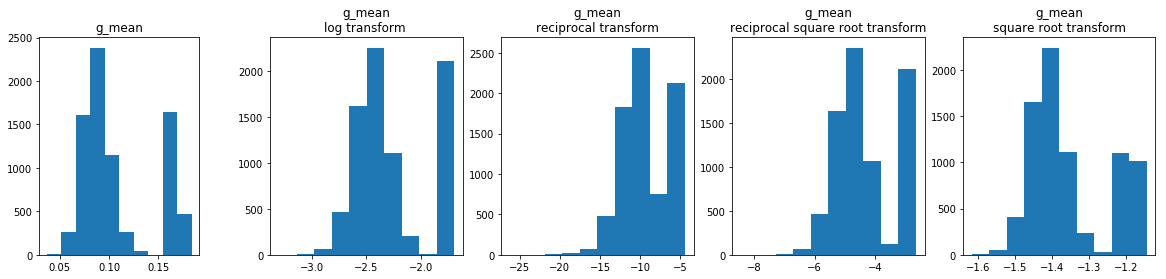

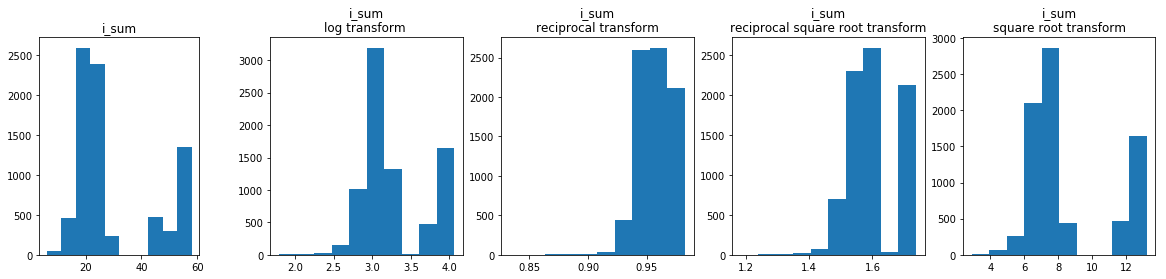

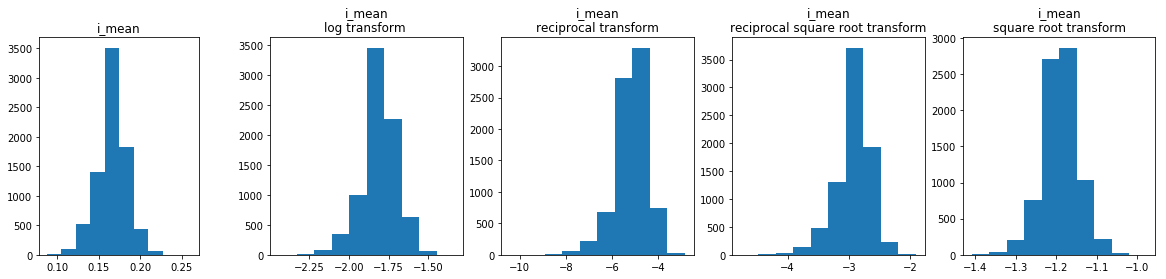

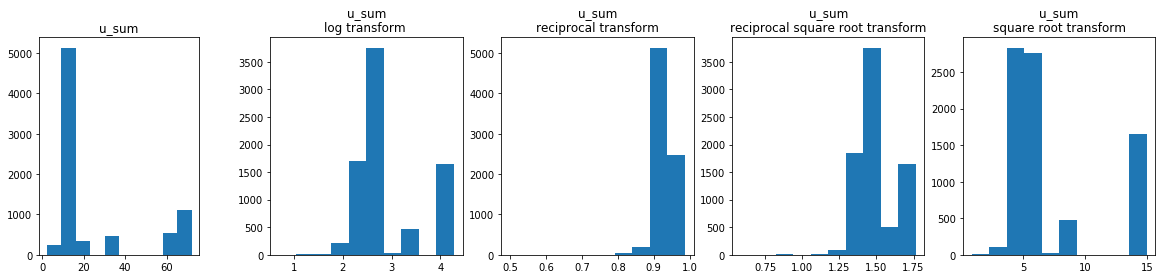

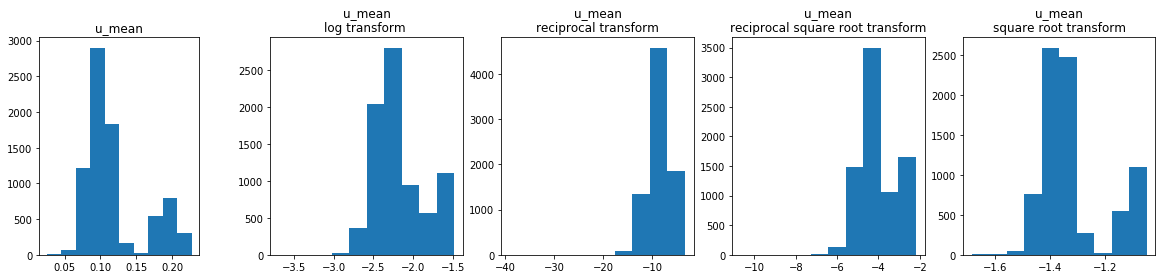

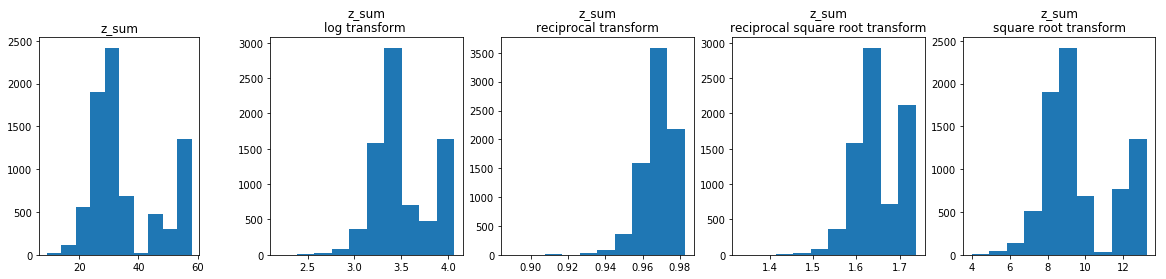

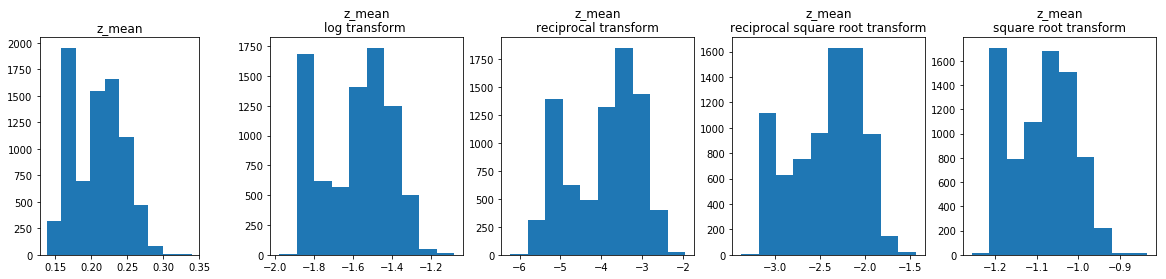

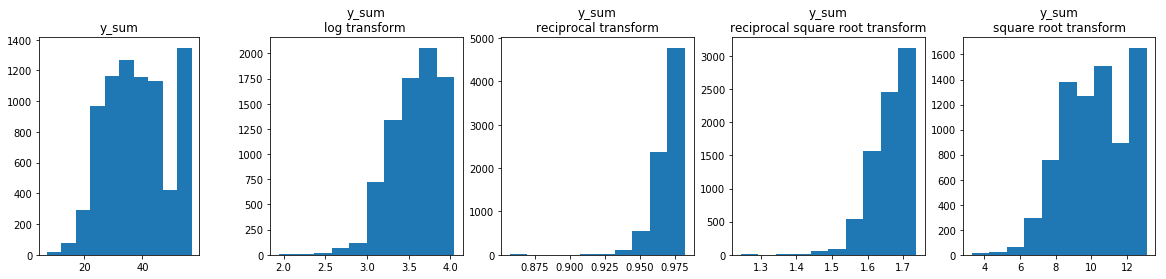

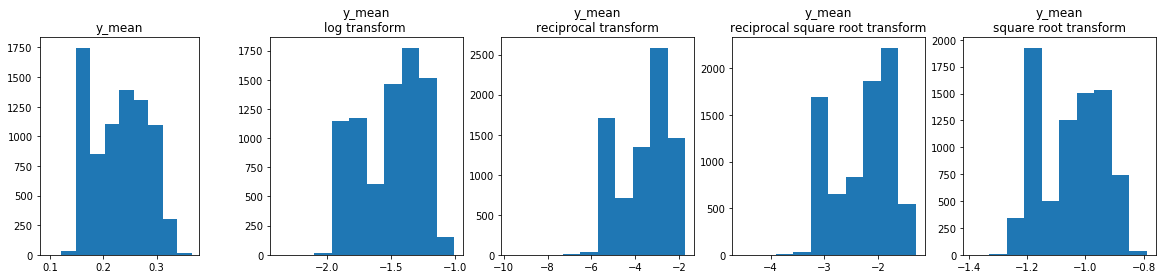

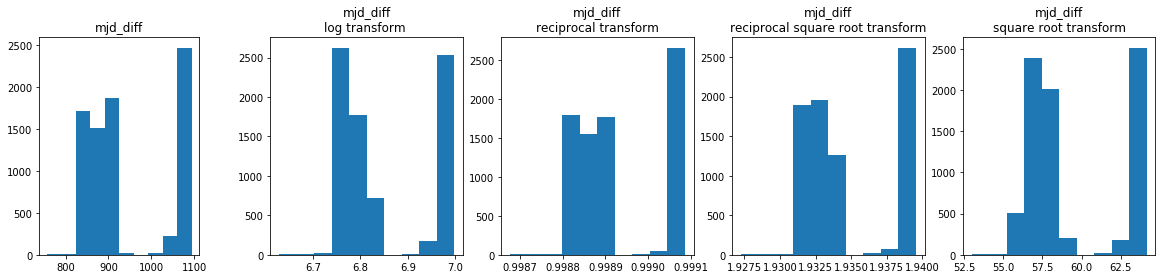

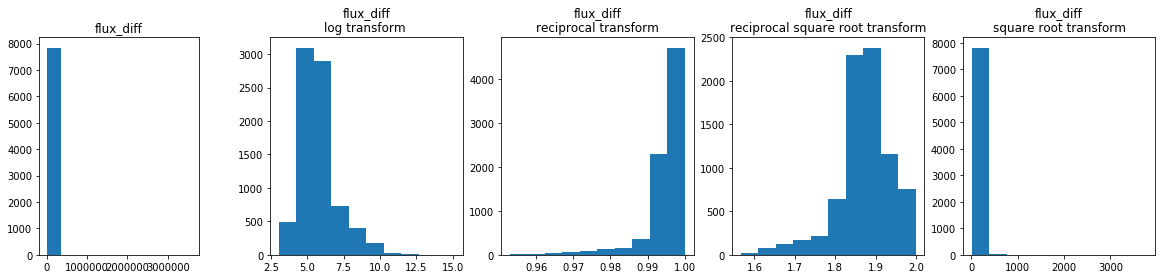

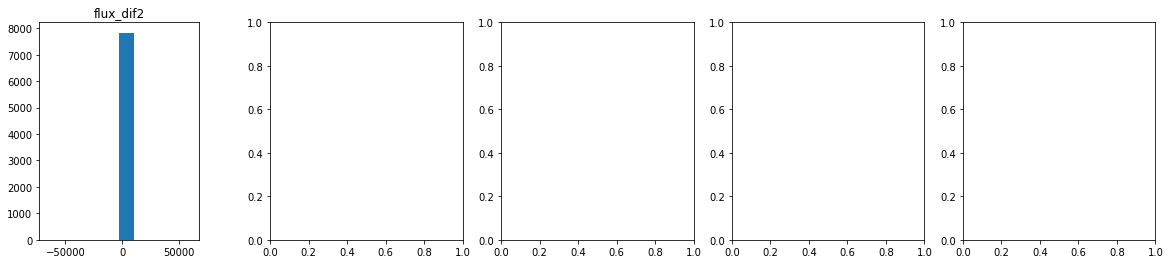

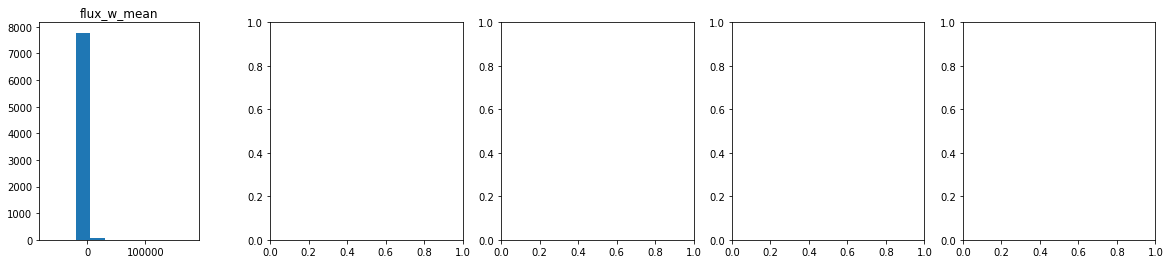

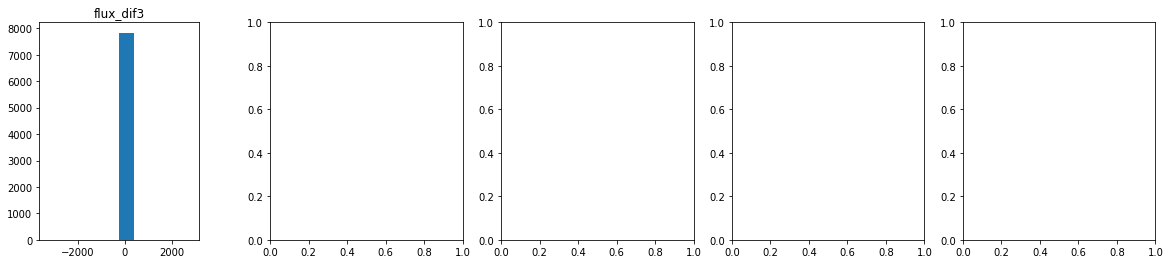

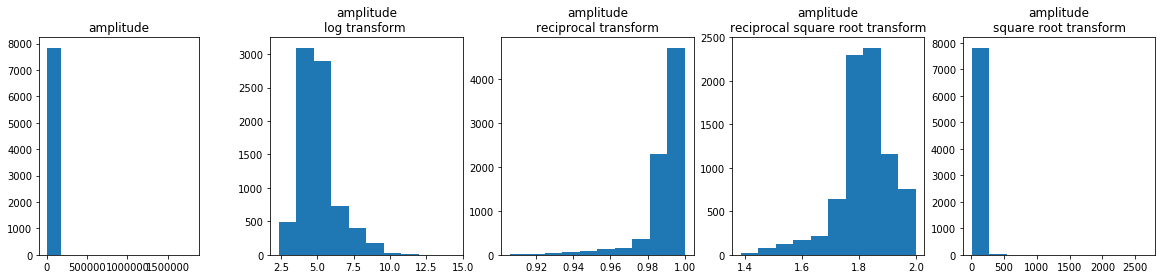

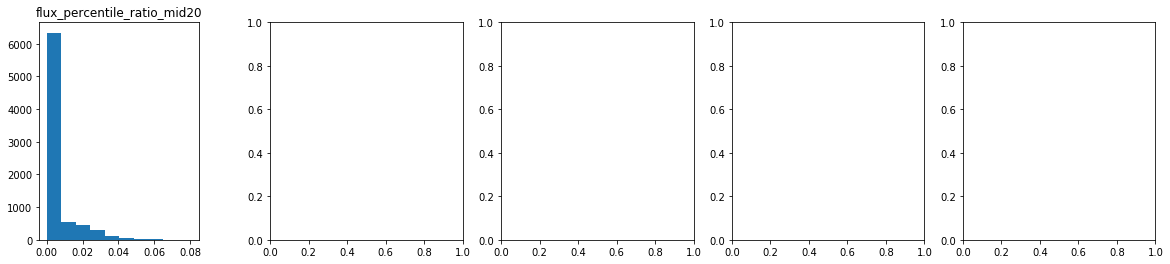

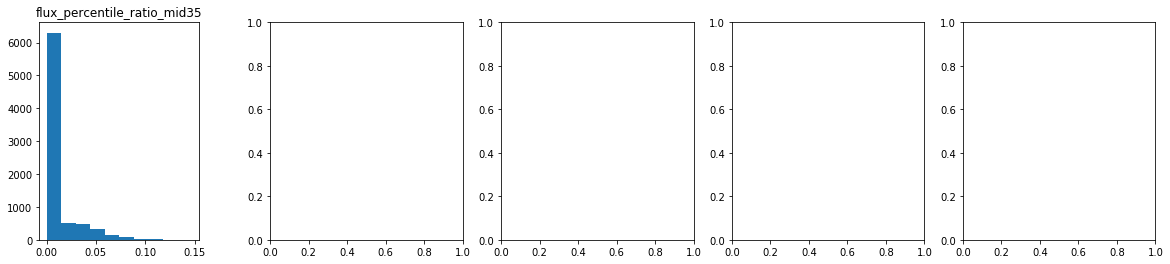

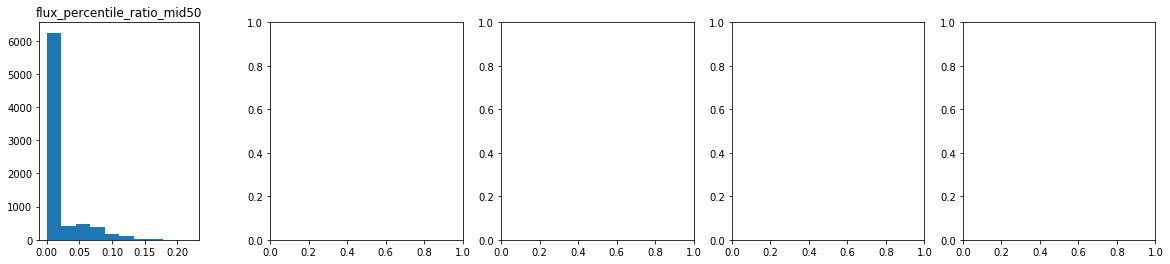

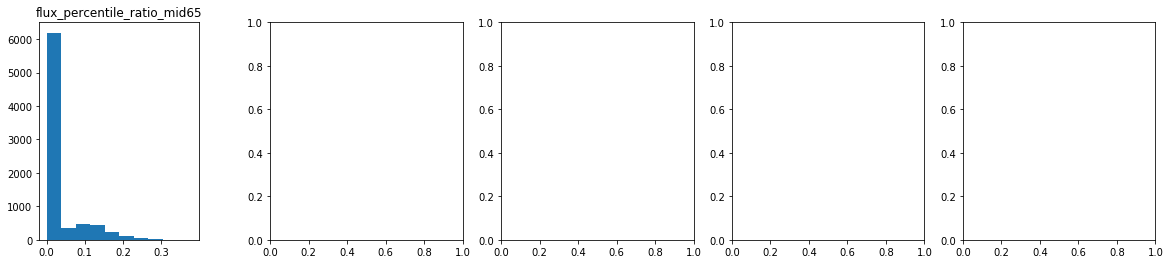

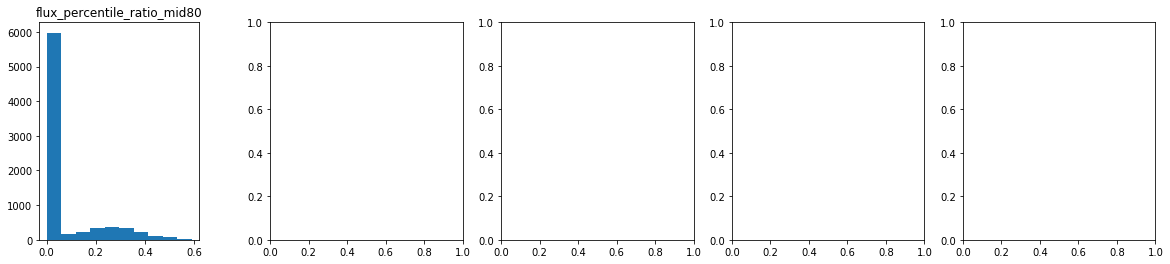

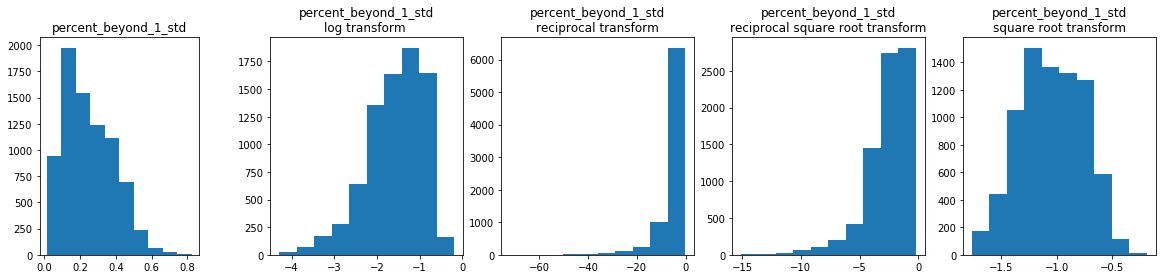

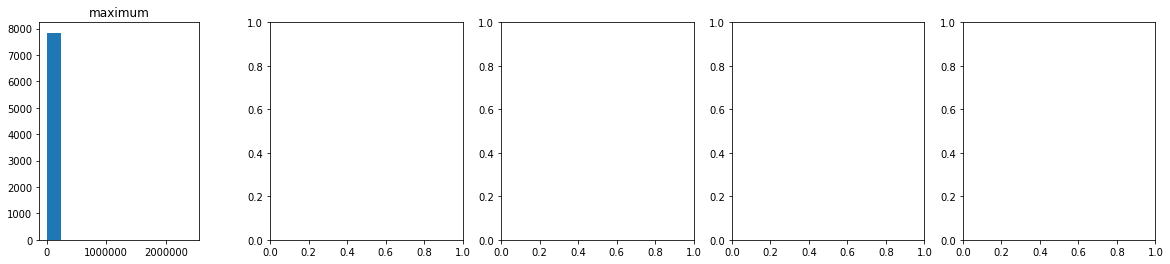

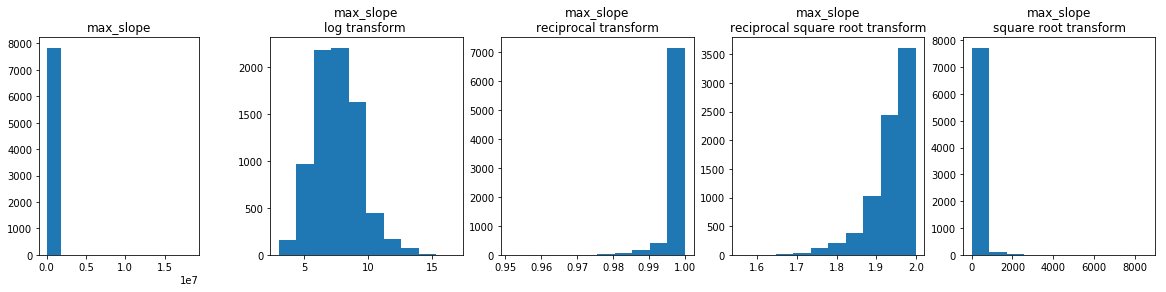

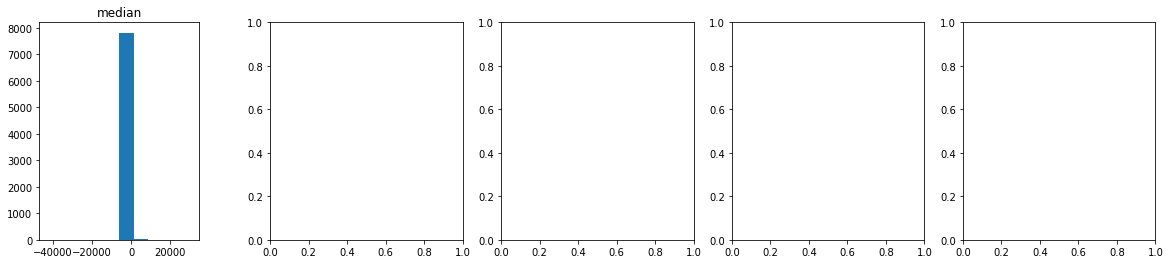

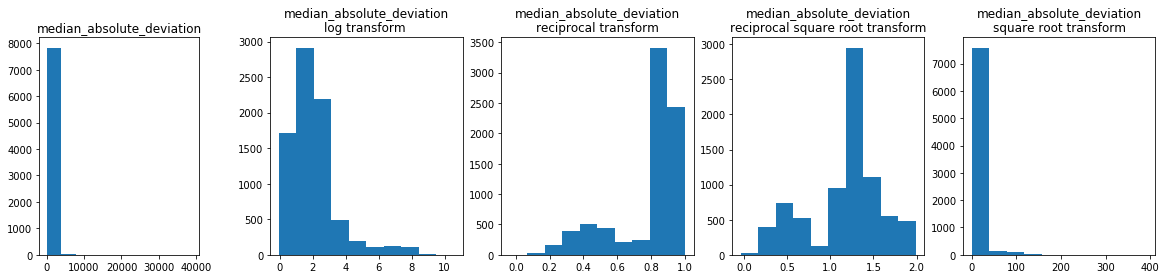

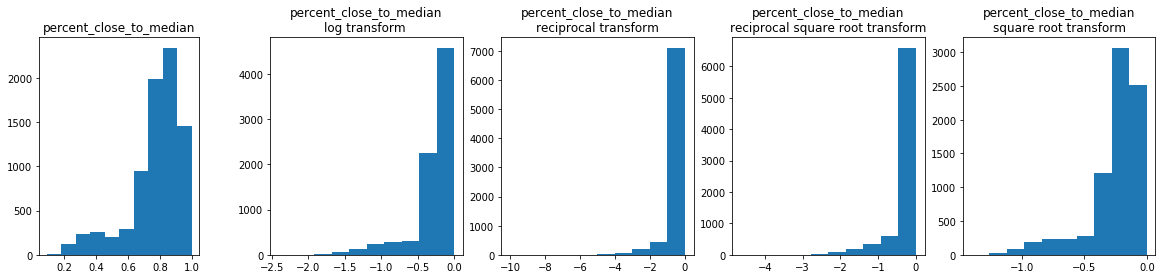

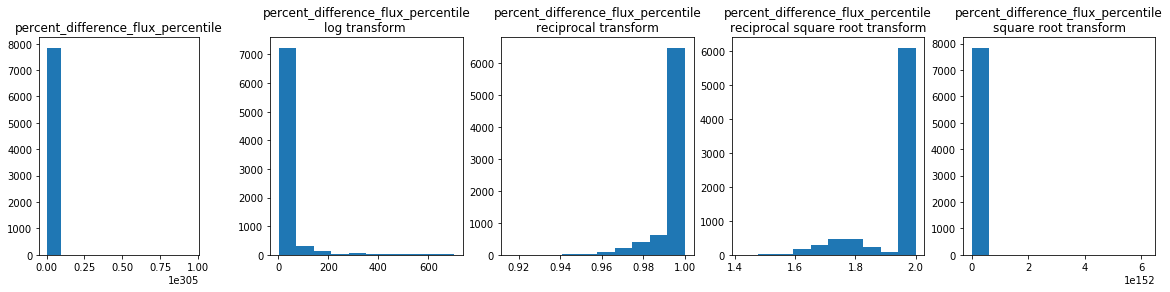

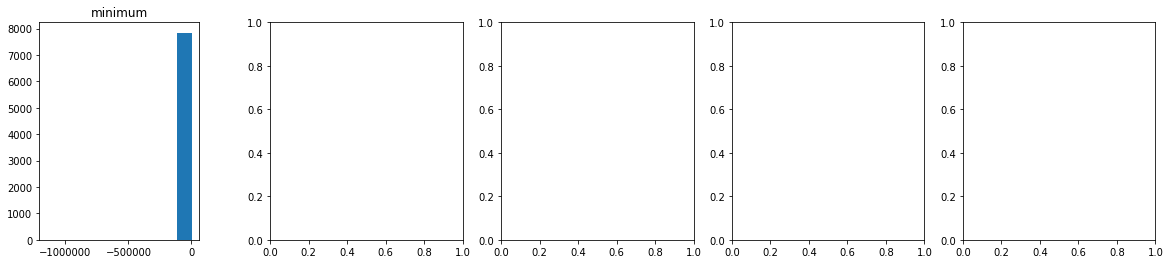

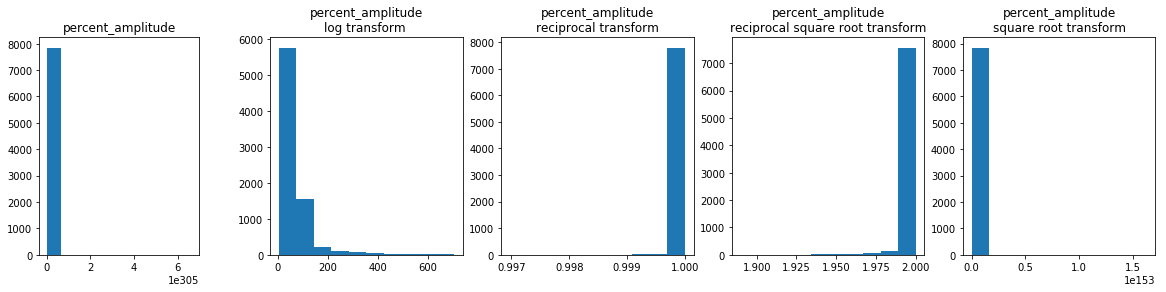

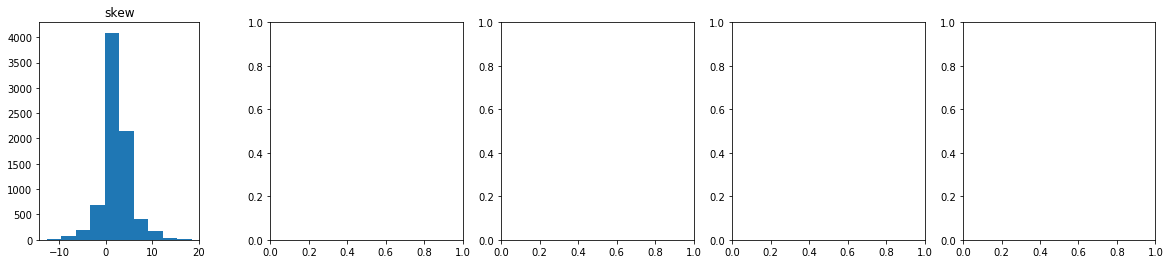

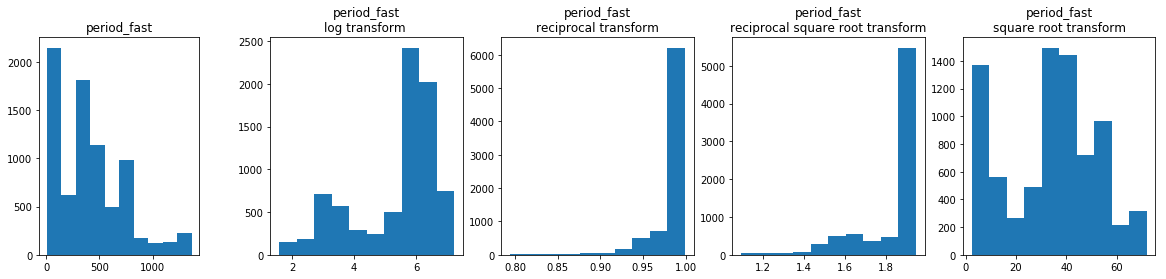

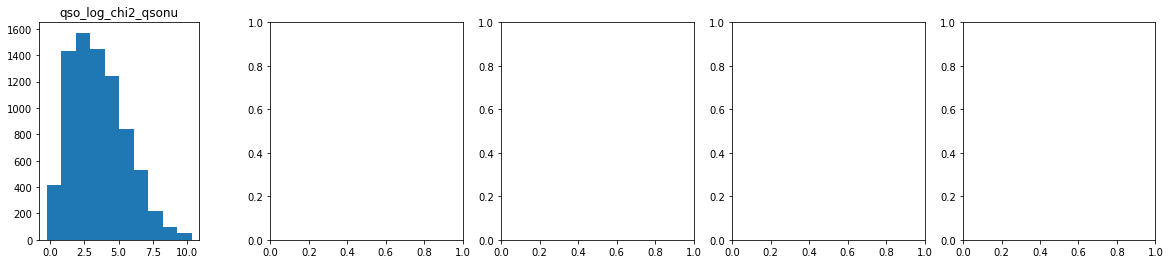

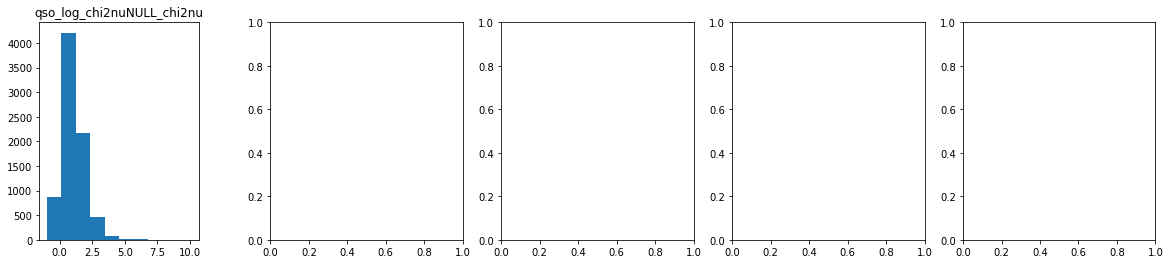

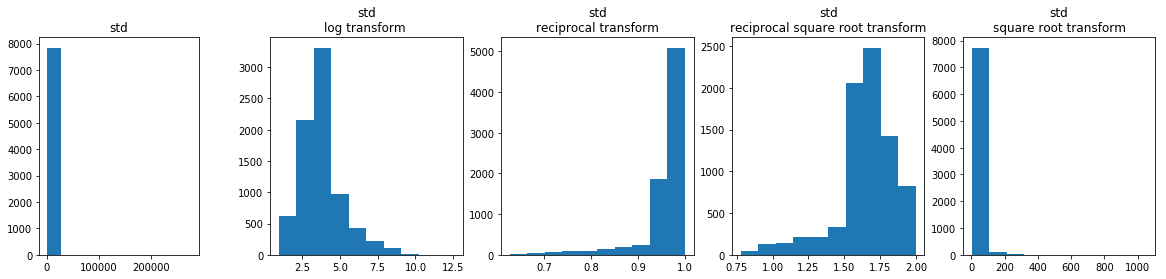

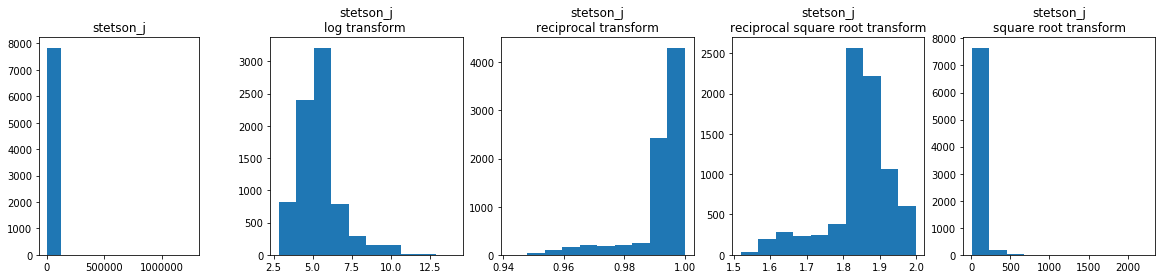

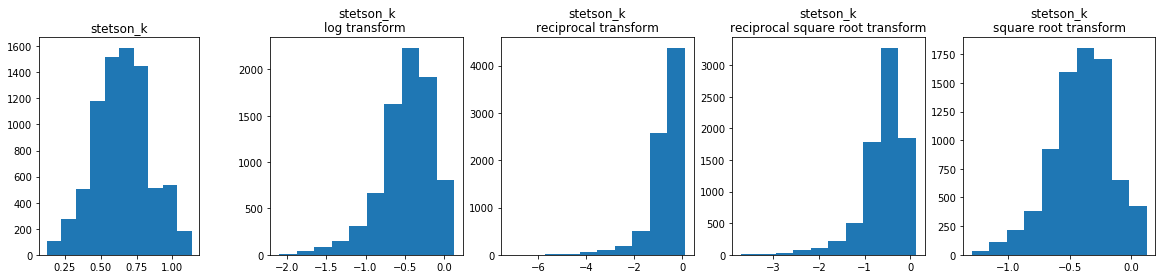

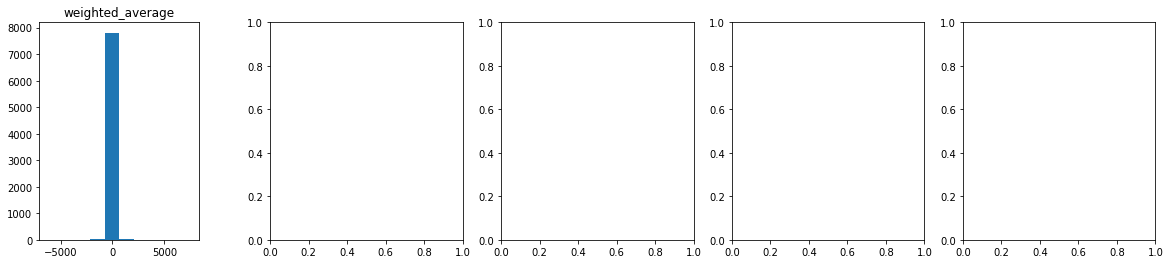

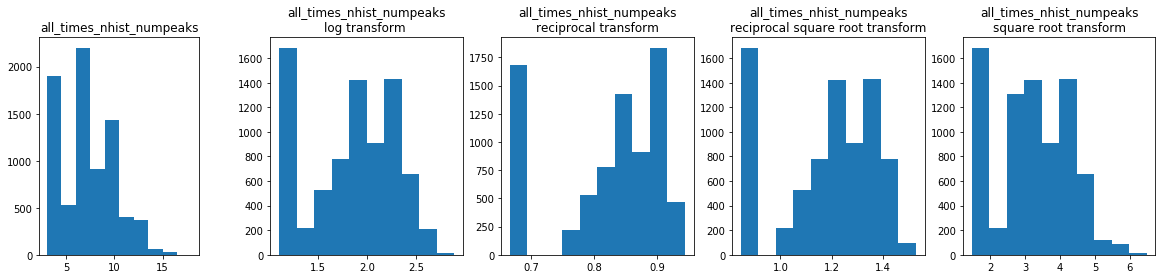

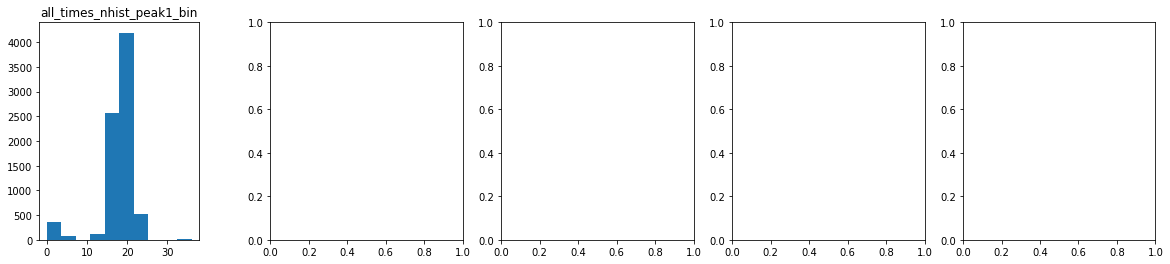

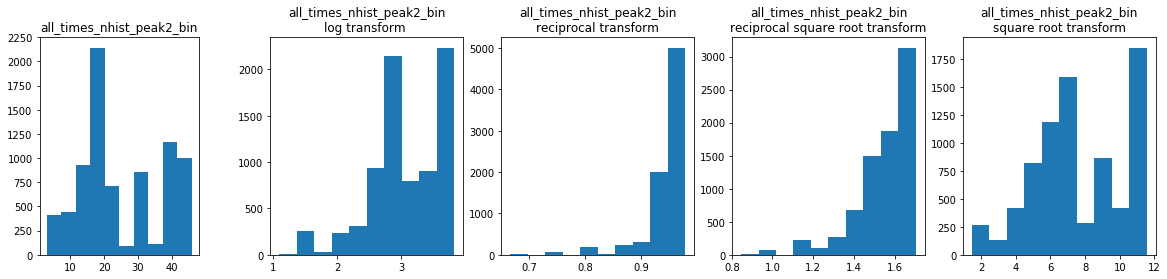

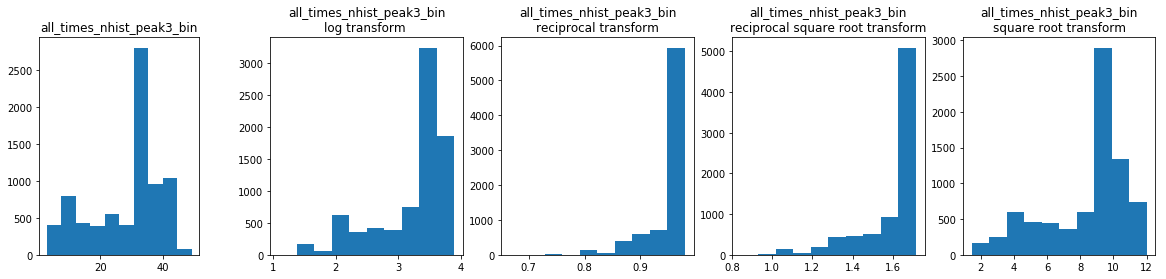

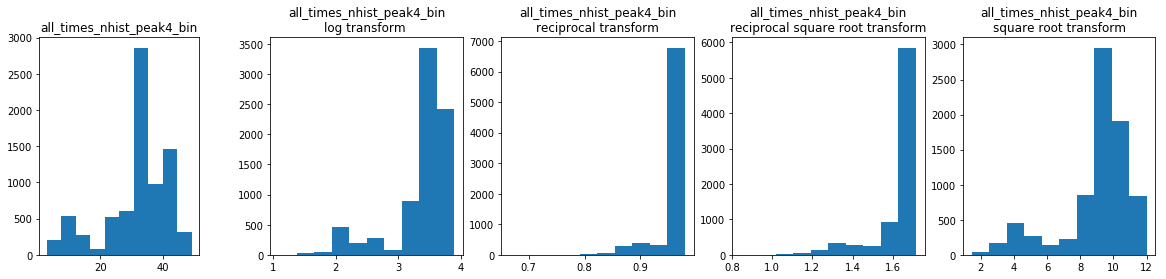

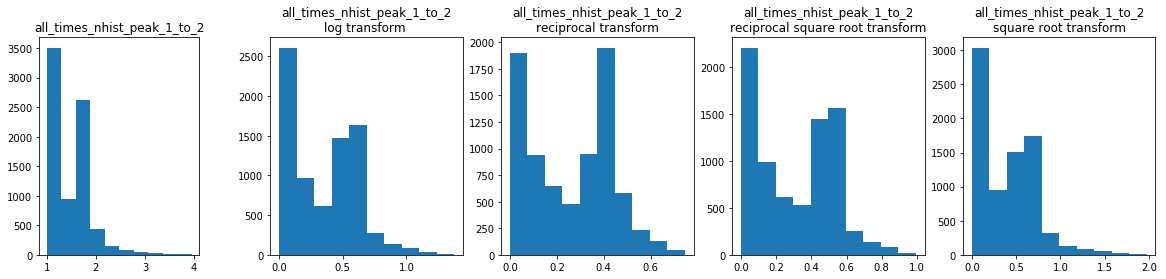

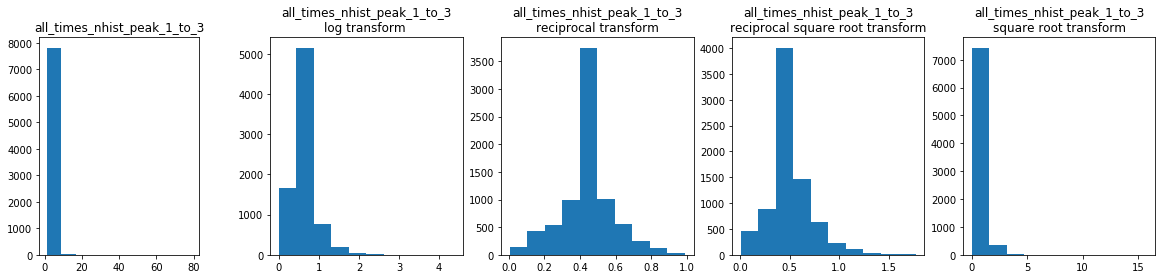

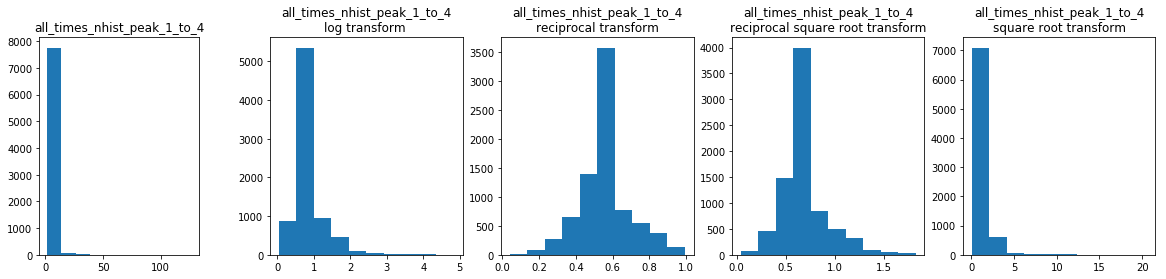

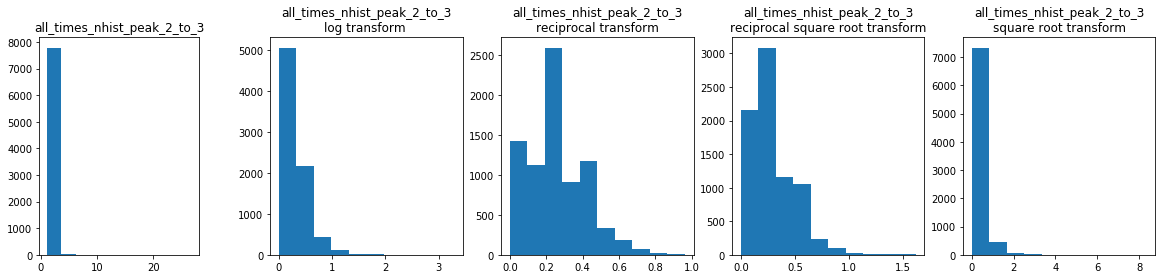

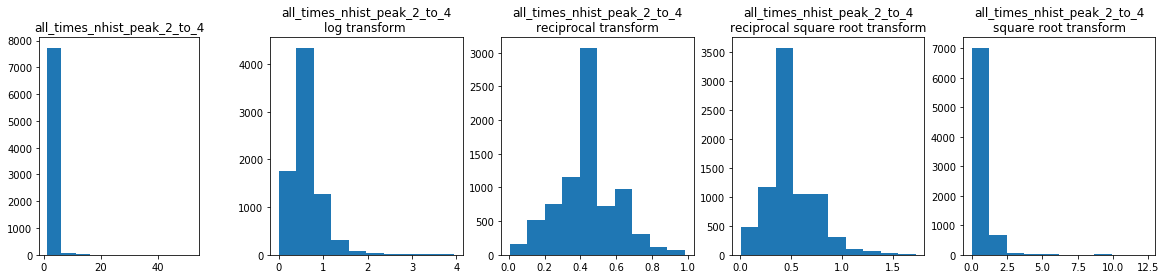

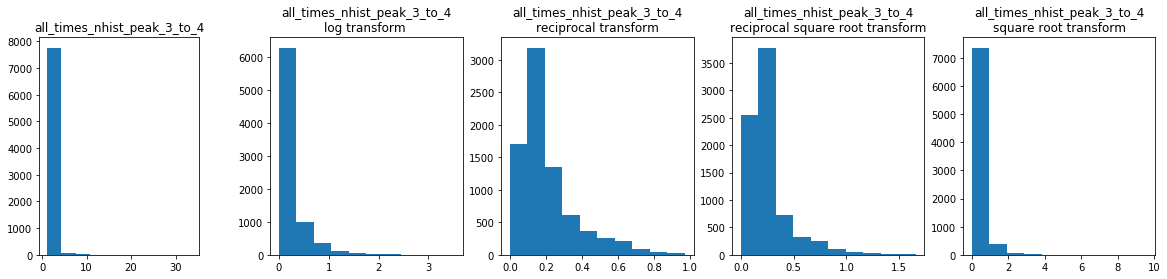

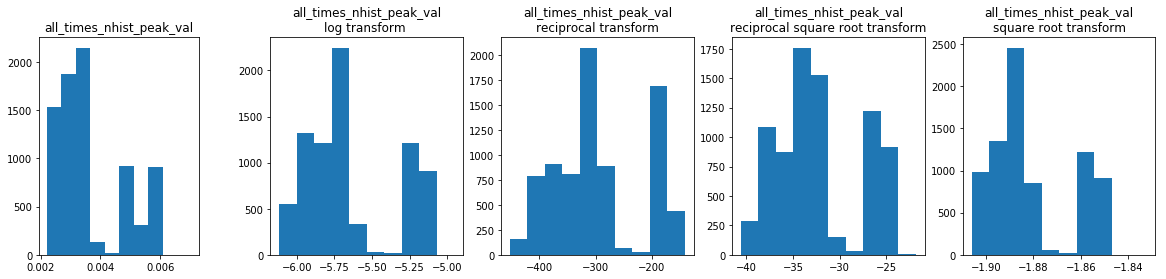

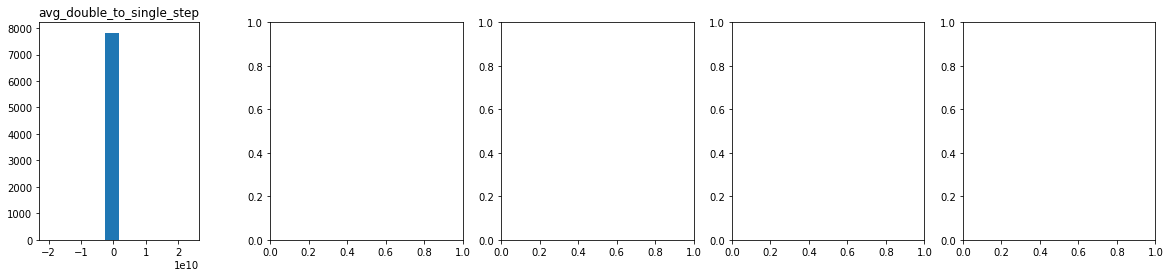

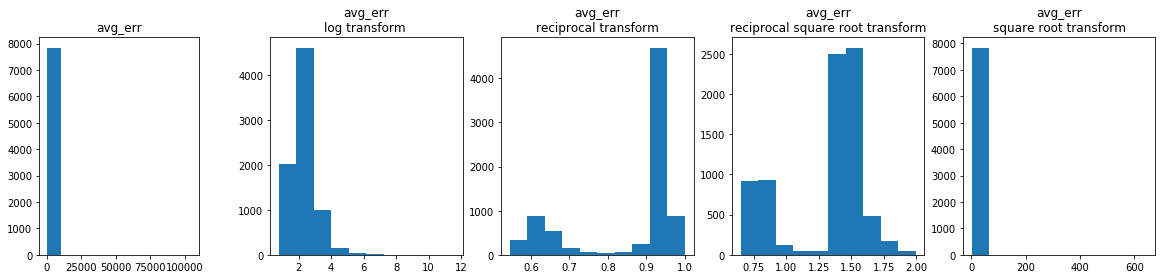

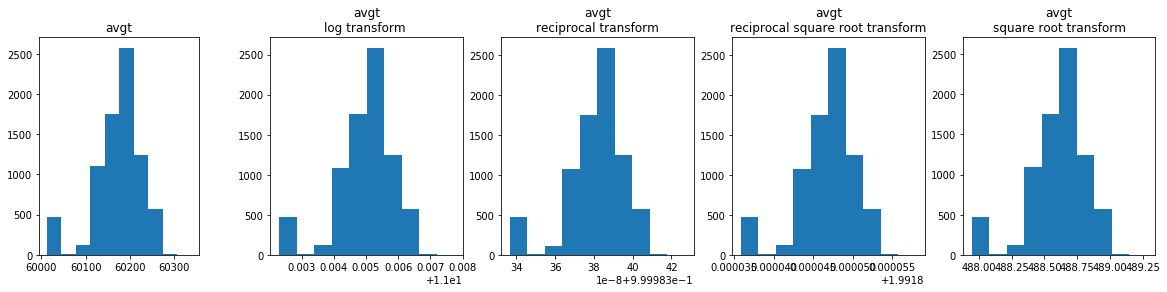

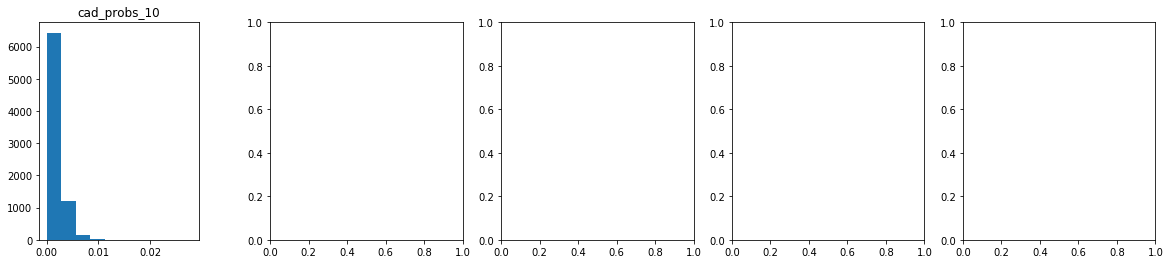

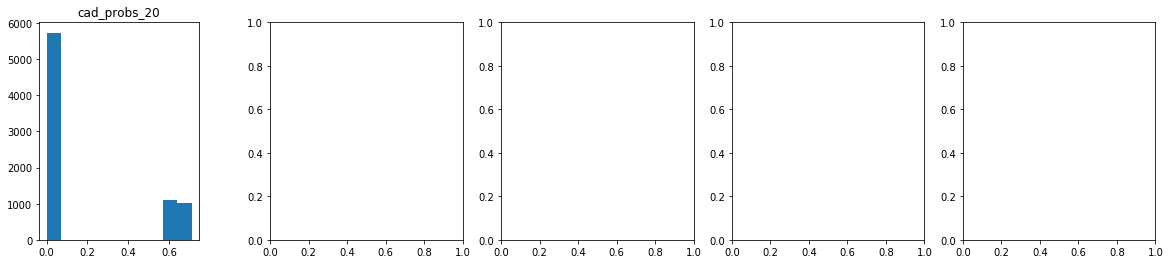

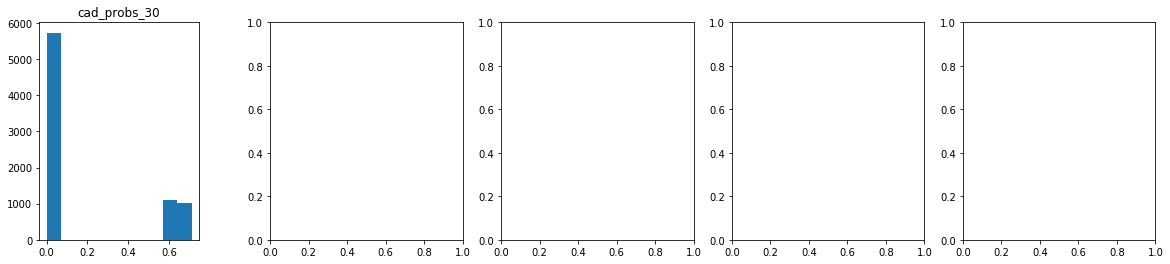

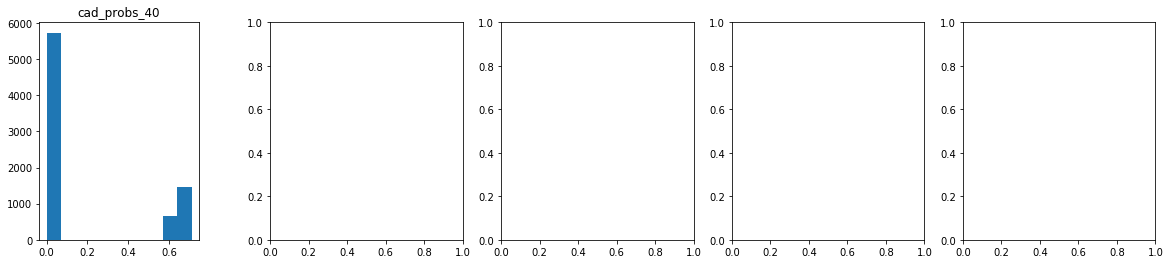

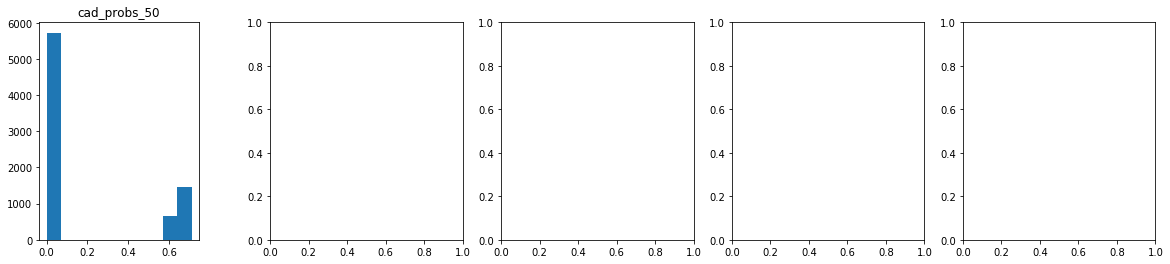

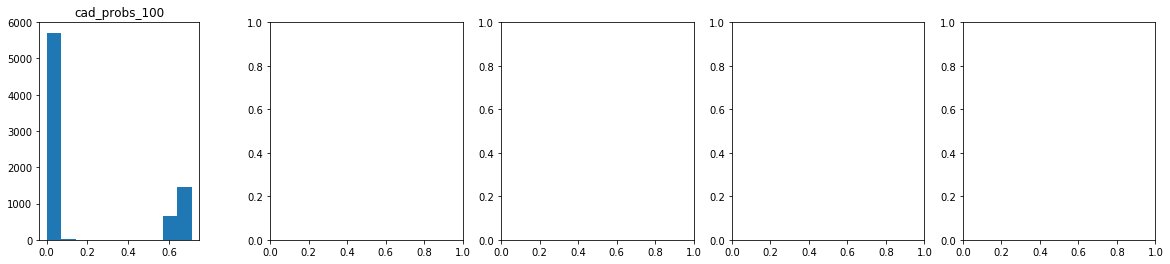

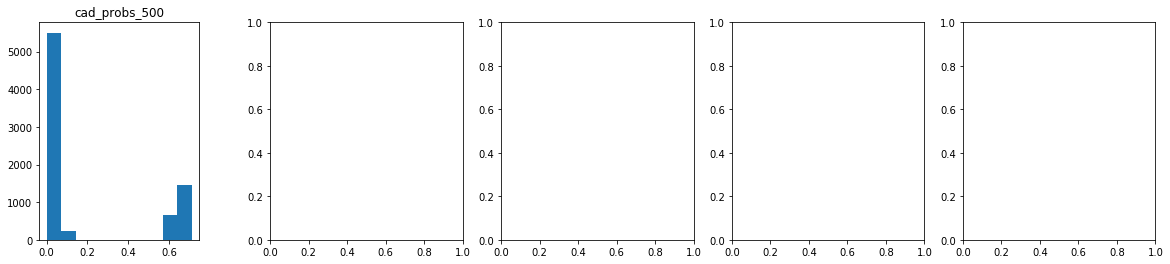

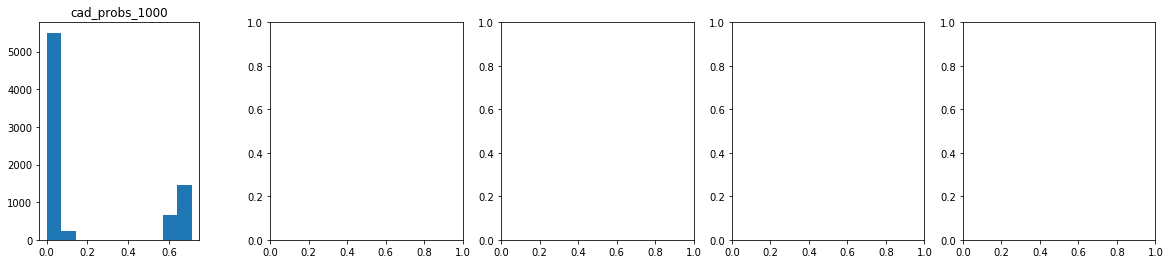

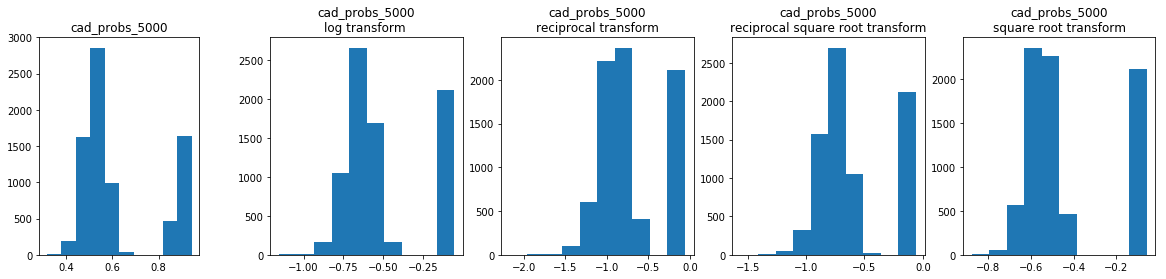

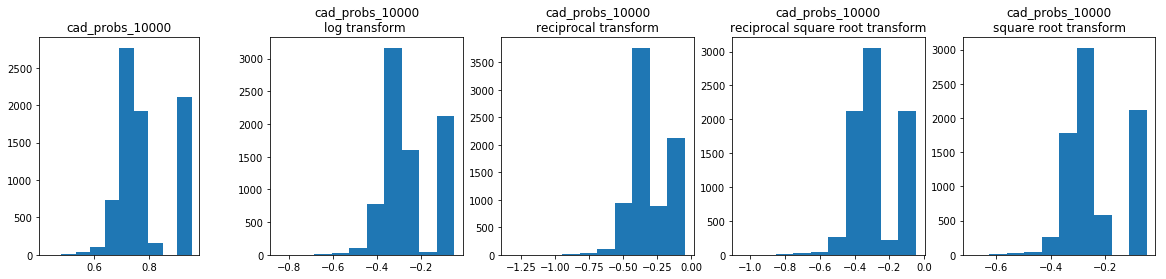

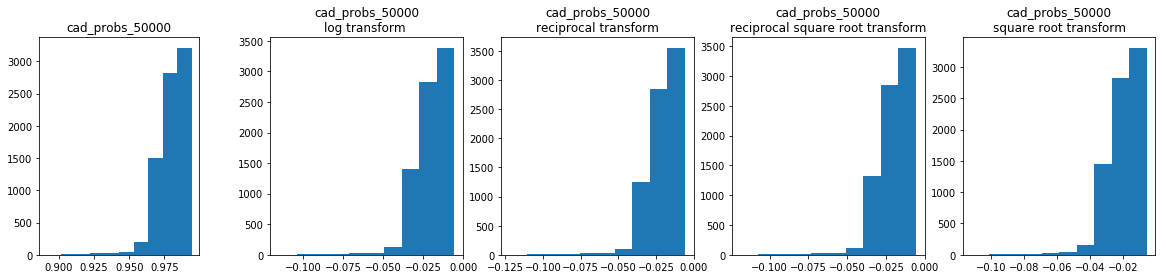

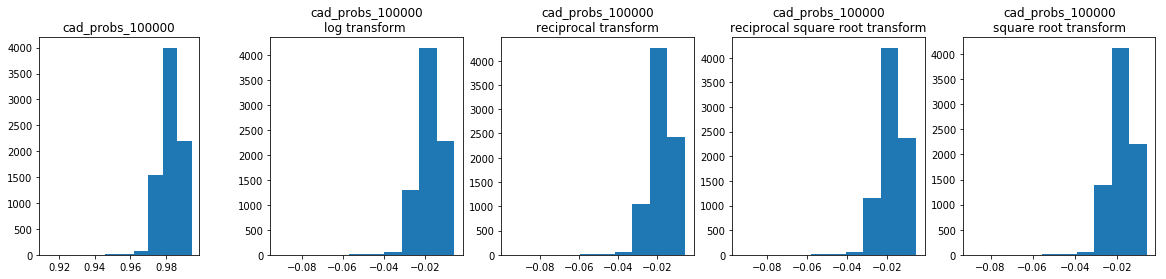

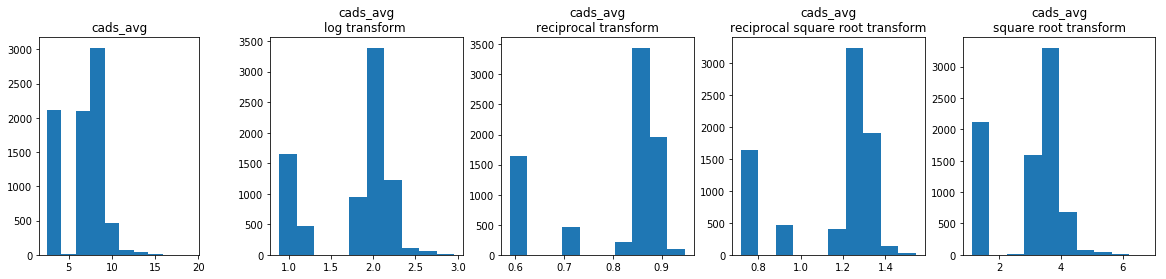

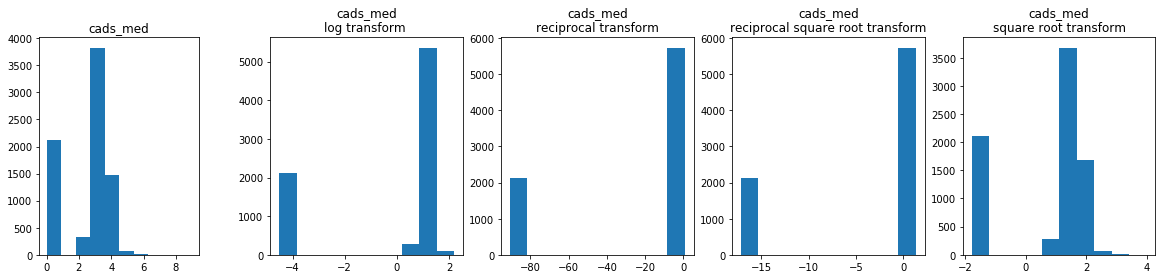

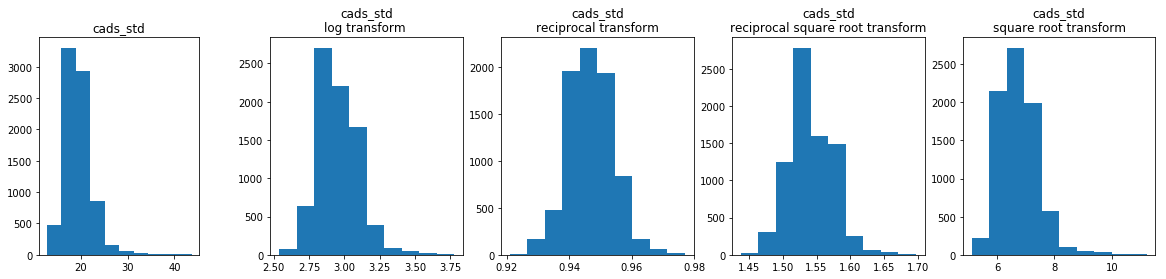

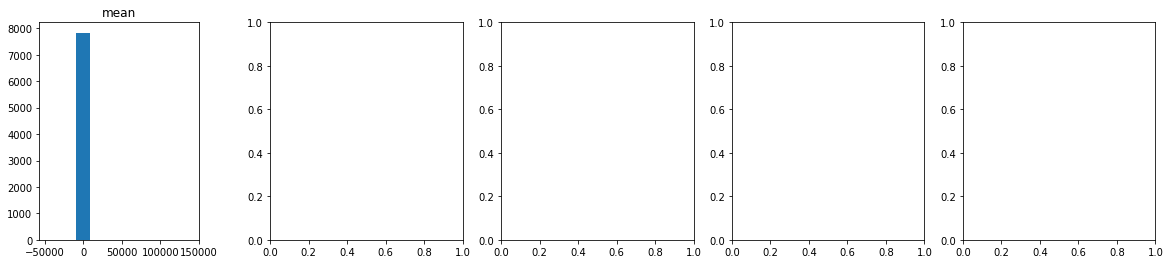

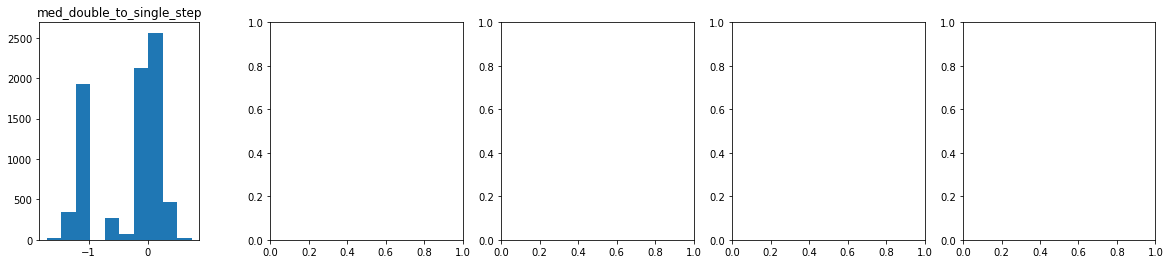

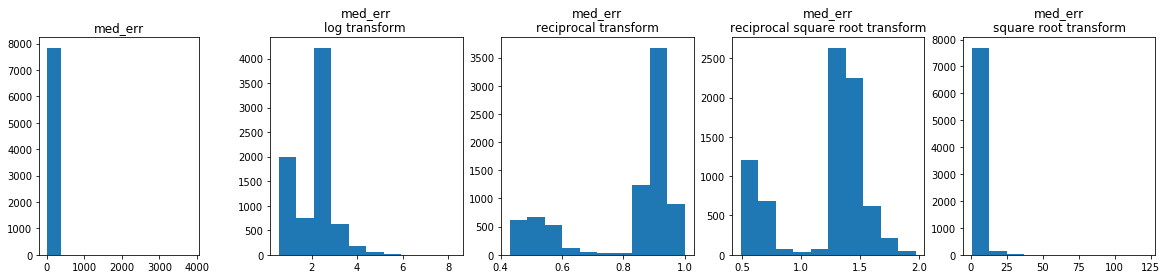

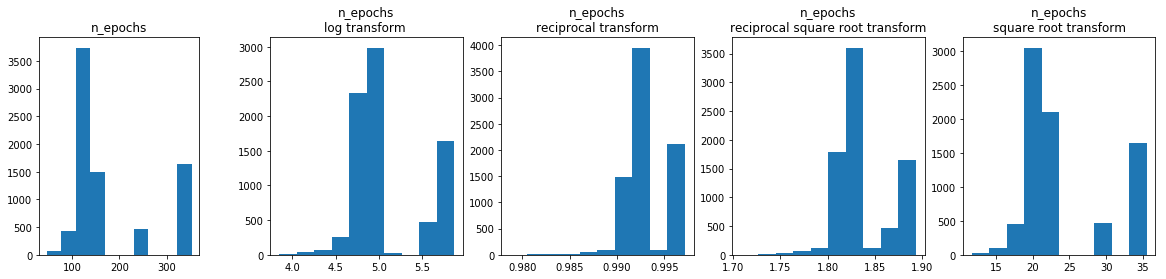

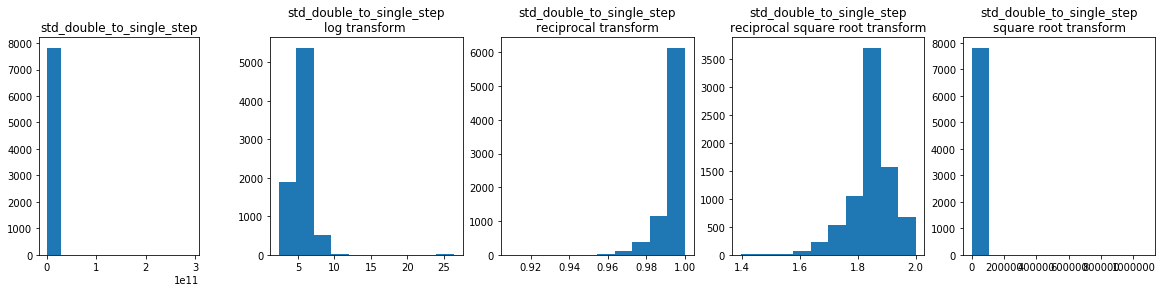

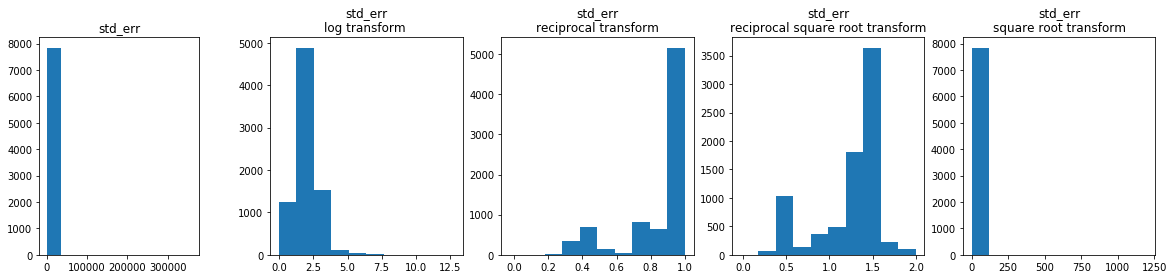

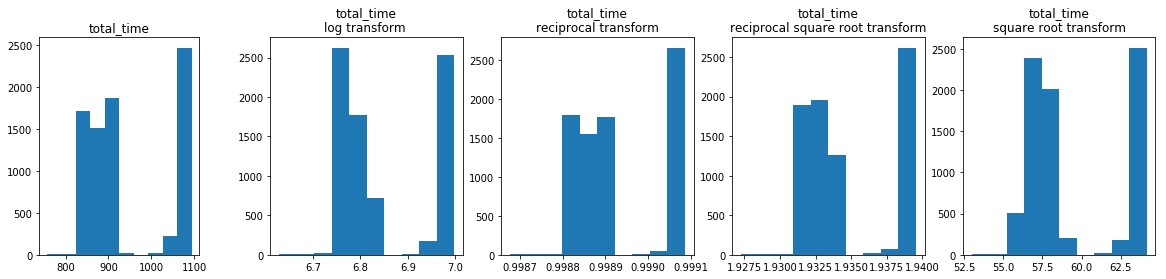

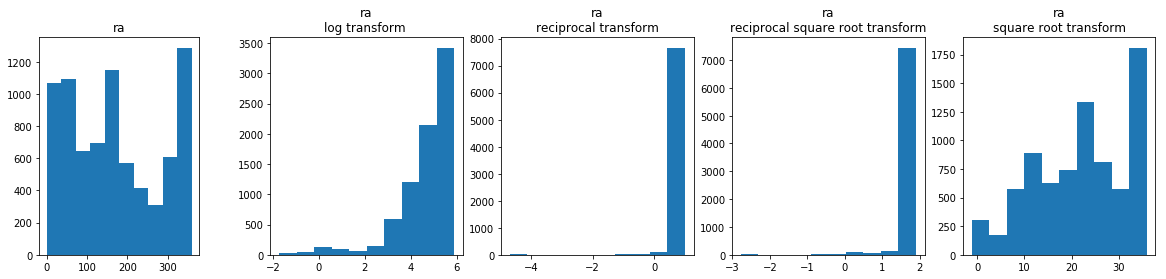

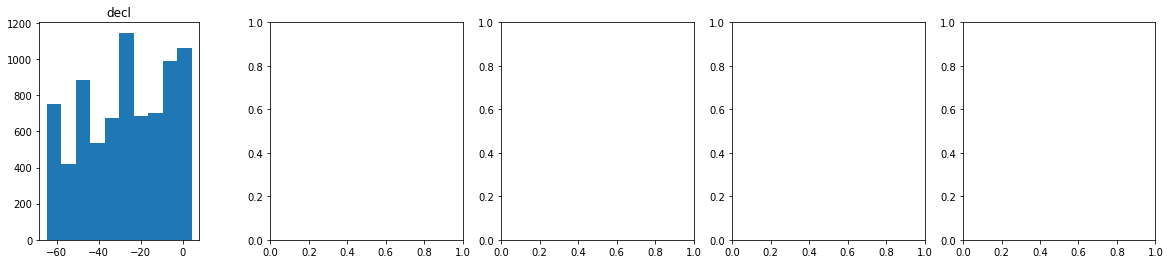

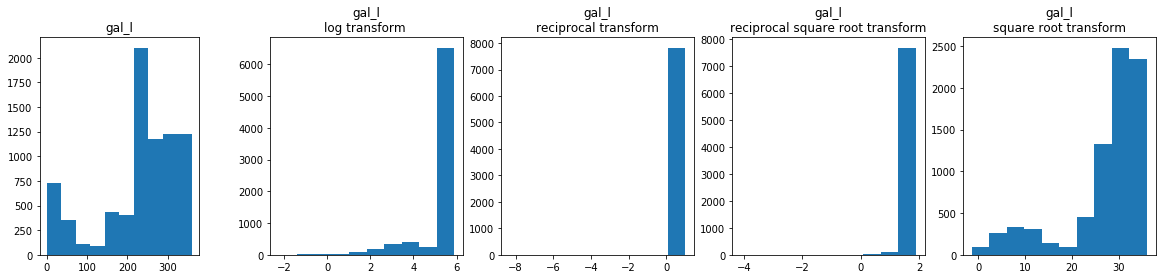

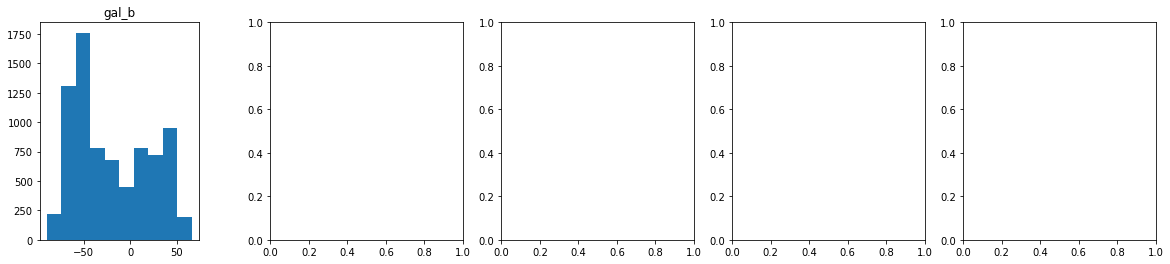

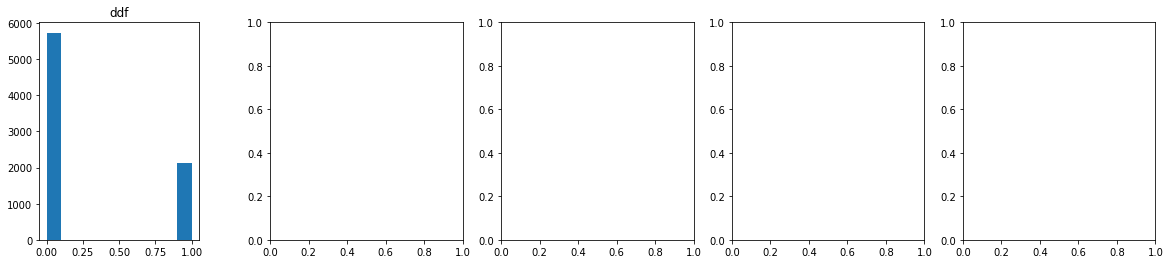

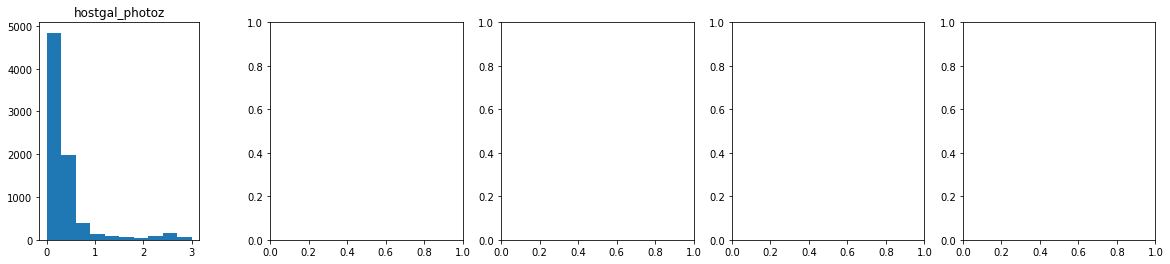

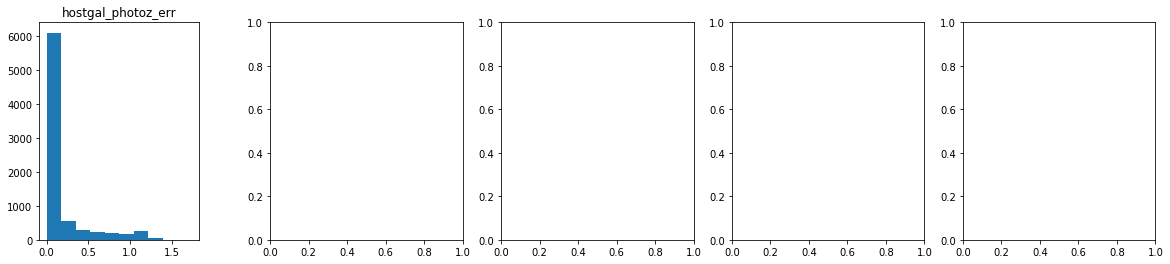

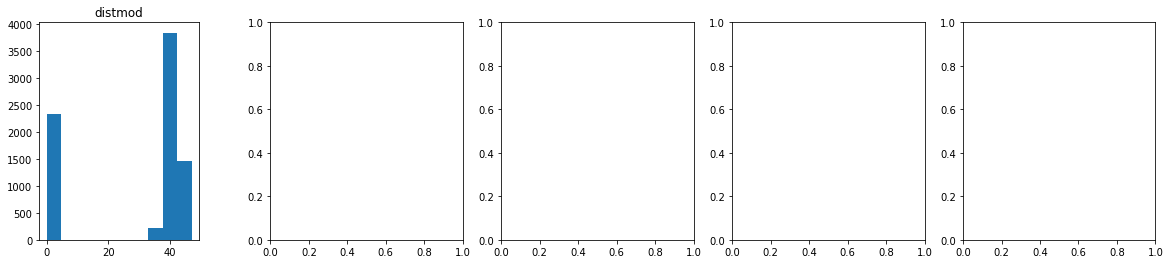

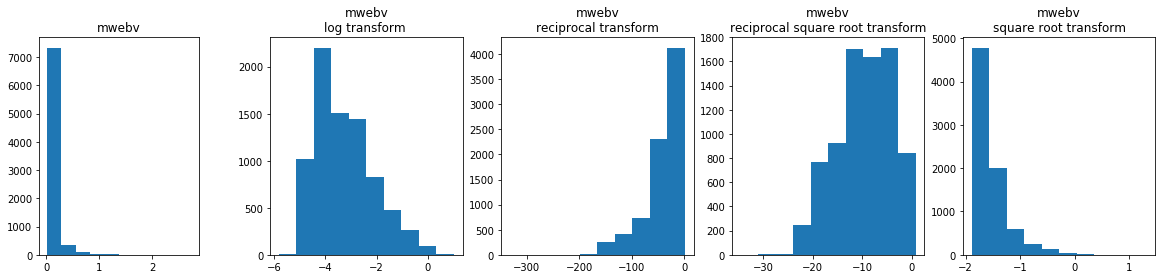

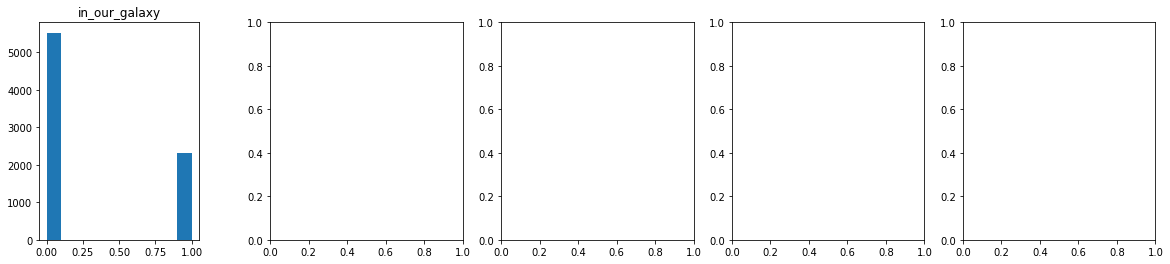

In [6]:
from scipy.stats import boxcox
for col in training_dataset.columns.values:
    if col == 'target' or col == 'object_id':
        continue
    plt.figure(figsize=(20,4))
    
    # histogram from a data without transform
    plt.subplot(161)
    plt.hist(training_dataset[col])
    plt.title(col)
    
    # histogram from a log transform
    plt.subplot(152)
    try:
        plt.hist(boxcox(training_dataset[col].values, 0))
        plt.title(col + '\nlog transform ')
    except:
        print('Logarithmic transform failed to apply. Column: {}'.format(col))
    
    # histogram from a reciprocal transform
    plt.subplot(153)
    try:
        plt.hist(boxcox(training_dataset[col], -1))
        plt.title(col + '\nreciprocal transform')
    except:
        print('Reciprocal transform failed to apply. Column: {}'.format(col))
        
    # histogram from a reciprocal square root transform
    plt.subplot(154)
    try:
        plt.hist(boxcox(training_dataset[col], -0.5))
        plt.title(col + '\nreciprocal square root transform')
    except:
        print('Reciprocal square root transform failed to apply. Column: {}'.format(col))
        
    # histogram from a square root transform
    plt.subplot(155)
    try:
        plt.hist(boxcox(training_dataset[col], 0.5))
        plt.title(col + '\nsquare root transform')
    except:
        print('Square root transform failed to apply. Column: {}'.format(col))

In [18]:
training_dataset['flux_std'] = boxcox(training_dataset['flux_std'], -0.5)
training_dataset['flux_err_min'] = boxcox(training_dataset['flux_err_min'], -0.5)
training_dataset['flux_err_max'] = boxcox(training_dataset['flux_err_max'], -0.5)
training_dataset['flux_err_mean'] = boxcox(training_dataset['flux_err_mean'], -0.5)
training_dataset['flux_err_median'] = boxcox(training_dataset['flux_err_median'], -0.5)
training_dataset['flux_err_std'] = boxcox(training_dataset['flux_err_std'], -0.5)
training_dataset['detected_mean'] = boxcox(training_dataset['detected_mean'], 0)
training_dataset['flux_ratio_sq_sum'] = boxcox(training_dataset['flux_ratio_sq_sum'], 0)
training_dataset['flux_diff'] = boxcox(training_dataset['flux_diff'], -0.5)
training_dataset['amplitude'] = boxcox(training_dataset['amplitude'], -0.5)
training_dataset['max_slope'] = boxcox(training_dataset['max_slope'], 0)
training_dataset['median_absolute_deviation'] = boxcox(training_dataset['median_absolute_deviation'], -0.5)
training_dataset['period_fast'] = boxcox(training_dataset['period_fast'], 0)
training_dataset['std'] = boxcox(training_dataset['std'], -0.5)
training_dataset['stetson_j'] = boxcox(training_dataset['stetson_j'], -0.5)
training_dataset['all_times_nhist_numpeaks'] = boxcox(training_dataset['all_times_nhist_numpeaks'], 0)
training_dataset['all_times_nhist_peak_1_to_2'] = boxcox(training_dataset['all_times_nhist_peak_1_to_2'], -0.5)
training_dataset['all_times_nhist_peak_1_to_3'] = boxcox(training_dataset['all_times_nhist_peak_1_to_3'], -1)
training_dataset['all_times_nhist_peak_1_to_4'] = boxcox(training_dataset['all_times_nhist_peak_1_to_4'], -1)
training_dataset['all_times_nhist_peak_2_to_3'] = boxcox(training_dataset['all_times_nhist_peak_2_to_3'], -1)
training_dataset['all_times_nhist_peak_2_to_4'] = boxcox(training_dataset['all_times_nhist_peak_2_to_4'], -1)
training_dataset['all_times_nhist_peak_3_to_4'] = boxcox(training_dataset['all_times_nhist_peak_3_to_4'], -1)
training_dataset['all_times_nhist_peak_val'] = boxcox(training_dataset['all_times_nhist_peak_val'], -0.5)
training_dataset['avg_err'] = boxcox(training_dataset['avg_err'], -0.5)
training_dataset['avgt'] = boxcox(training_dataset['avgt'], -1)
training_dataset['cads_avg'] = boxcox(training_dataset['cads_avg'], 0)
training_dataset['cads_std'] = boxcox(training_dataset['cads_std'], -1)
training_dataset['med_err'] = boxcox(training_dataset['med_err'], -0.5)
training_dataset['std_err'] = boxcox(training_dataset['std_err'], -0.5)
training_dataset['total_time'] = boxcox(training_dataset['total_time'], -1)
training_dataset['mwebv'] = boxcox(training_dataset['mwebv'], 0)

In [19]:
training_dataset.head()

object_id  mjd_size  passband_mean  passband_median  passband_std  \
0        615       352       2.457386              2.0      1.720797   
1        713       350       2.400000              2.0      1.746056   
2        730       330       2.336364              2.0      1.758750   
3        745       351       2.378917              2.0      1.747328   
4       1124       352       2.457386              2.0      1.720797   

      flux_min    flux_max   flux_mean  flux_median  flux_std      ...        \
0 -1100.440063  660.626343 -123.096998   -89.477524  1.899255      ...         
1   -14.735178   14.770886   -1.423351    -0.873033  1.213788      ...         
2   -19.159811   47.310059    2.267434     0.409172  1.293874      ...         
3   -15.494463  220.795212    8.909206     1.035895  1.619018      ...         
4   -16.543753  143.600189    7.145702     1.141288  1.553364      ...         

        decl       gal_l      gal_b  ddf  hostgal_photoz  hostgal_photoz_err  \
0 -61.943836  320.796530 -51.753706    1          0.0000              0.0000   
1 -27.784405  223.525509 -54.460748    1          1.6267              0.2552   
2  -6.579593  170.455585 -61.548219    1          0.2262              0.0157   
3 -45.586655  328.254458 -68.969298    1          0.2813              1.1523   
4 -63.823658  316.922299 -51.059403    1          0.2415              0.0176   

   distmod     mwebv    target  in_our_galaxy  
0   0.0000 -4.074542  class_92              1  
1  45.4063 -4.961845  class_88              0  
2  40.2561 -3.863233  class_42              0  
3  40.7951 -4.961845  class_90              0  
4  40.4166 -3.729701  class_90              0  

[5 rows x 110 columns]

In [20]:
# training_dataset.to_csv('training_dataset_cleaned.csv', index=False)

# Training data histograms
Warning: huge computing time

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A2AEC3B080>,
      dtype=object)

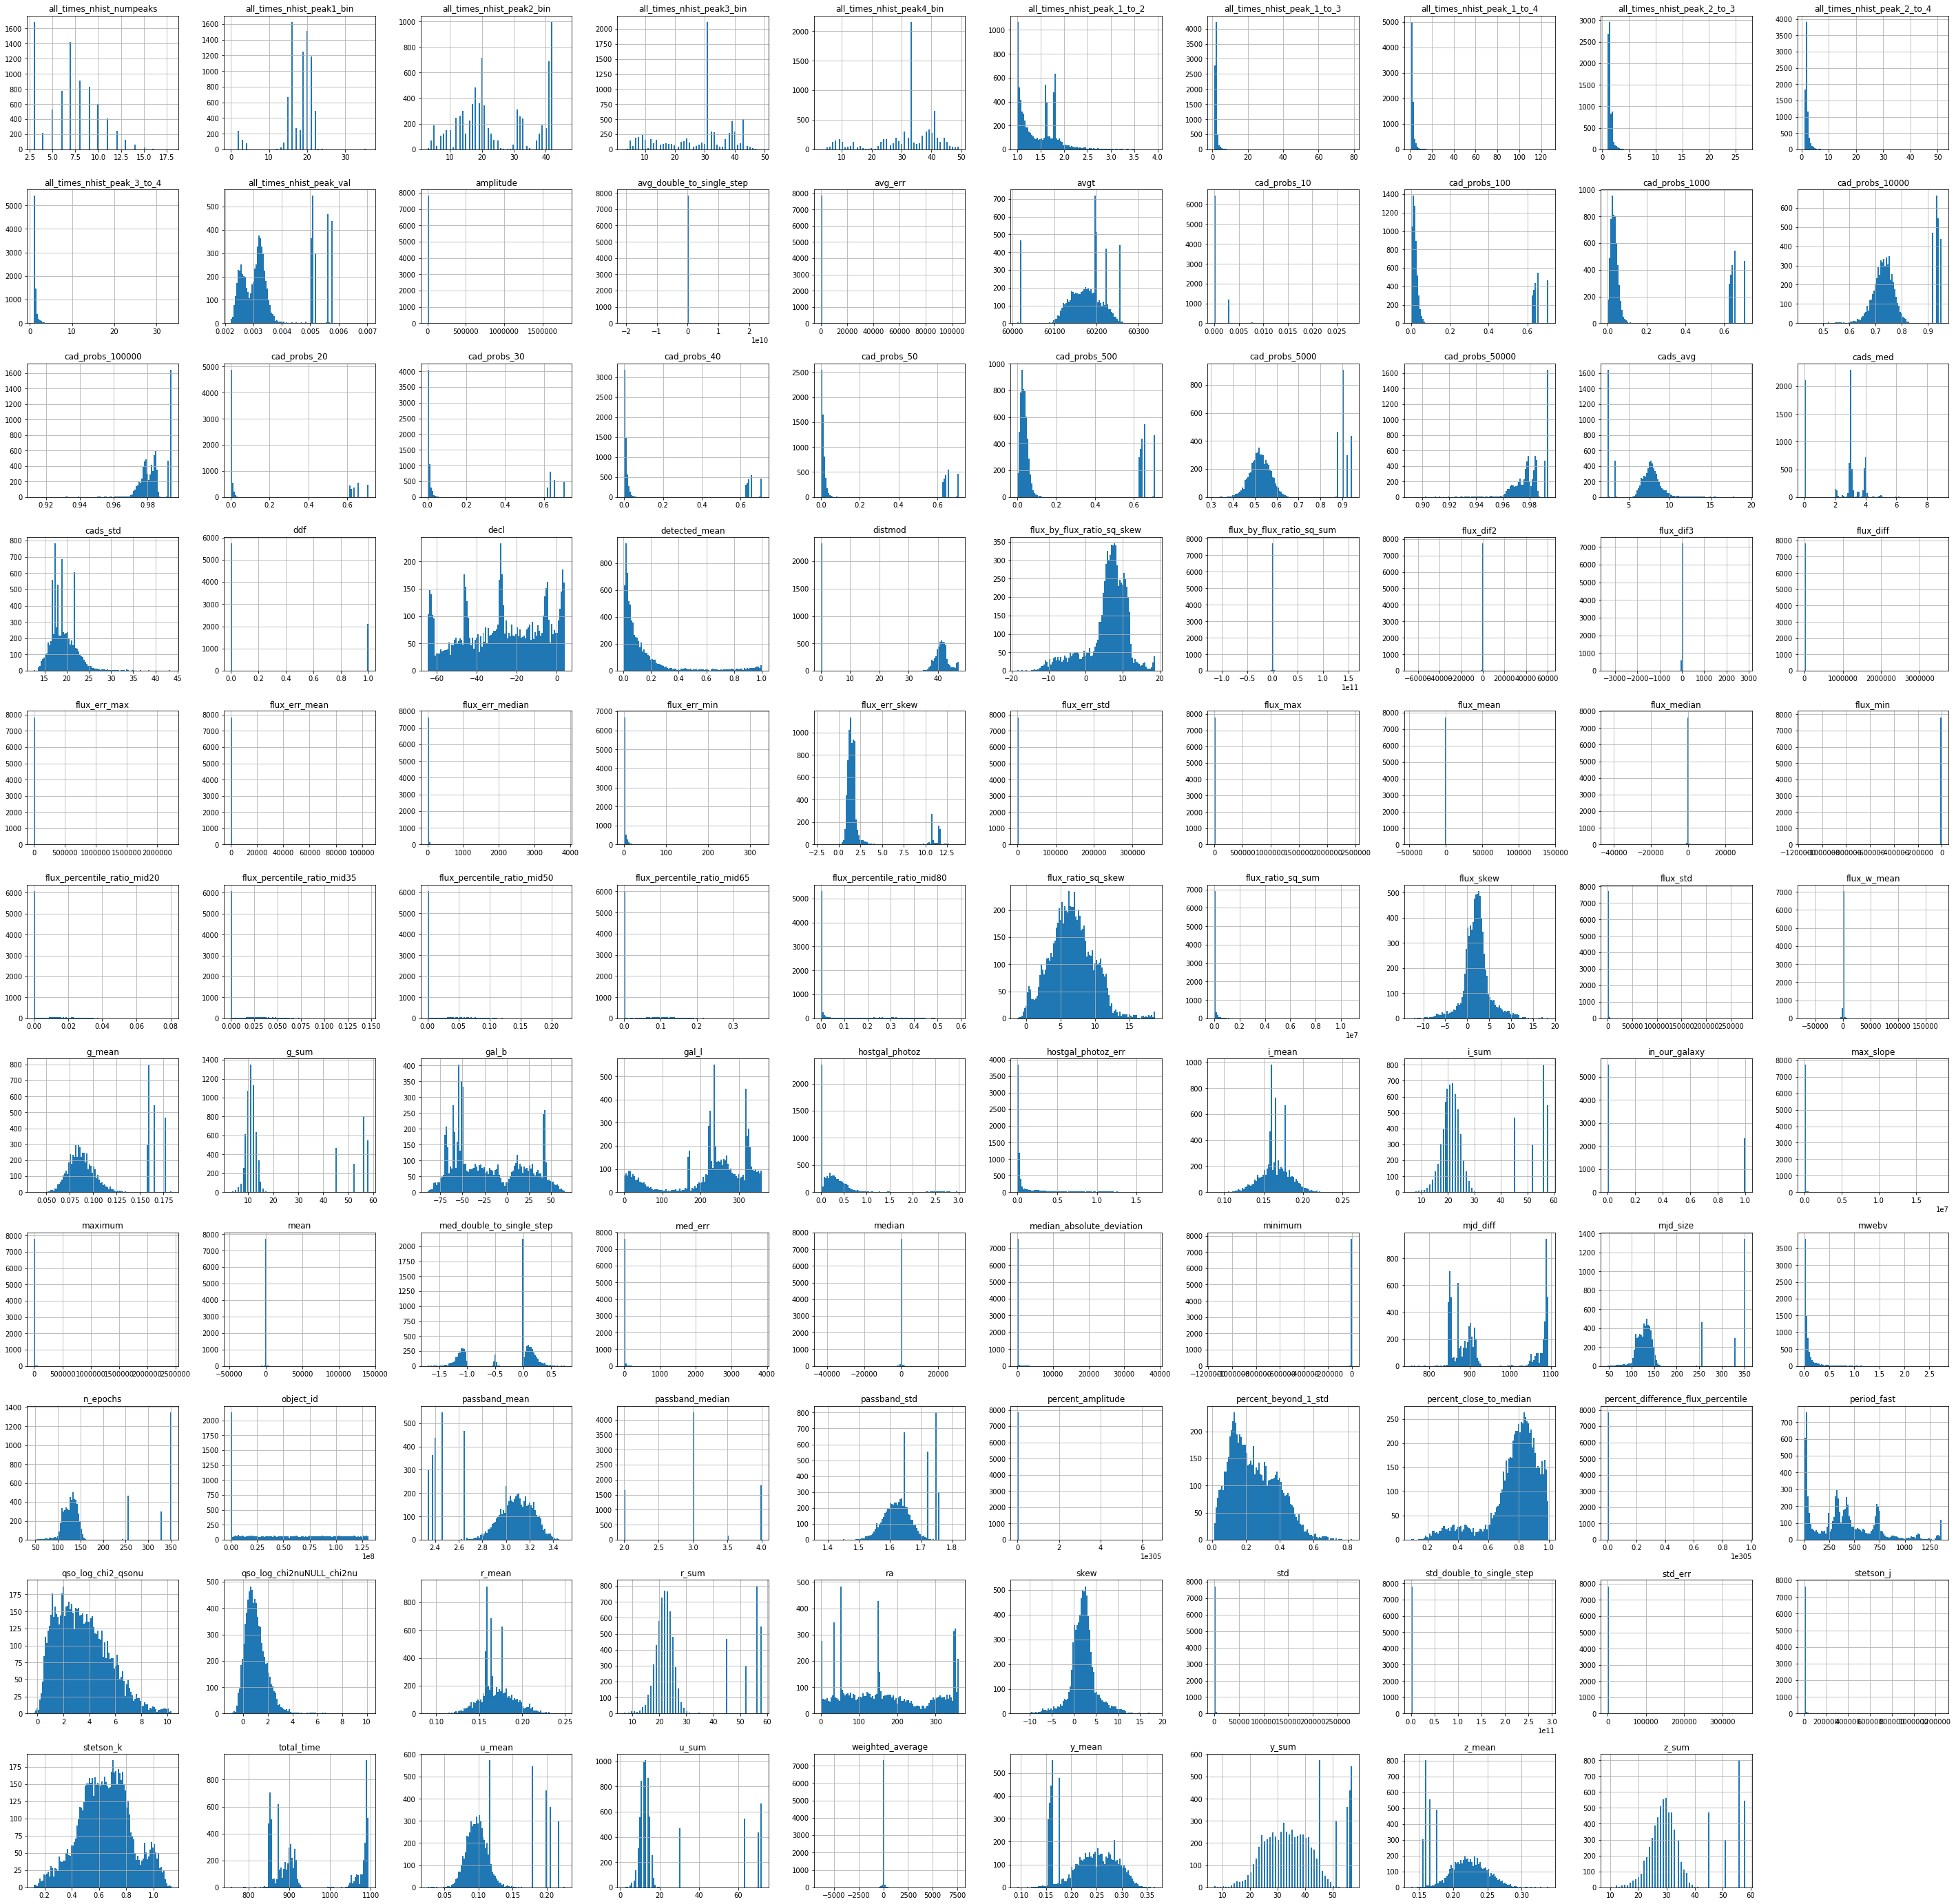

In [125]:
fig, ax = plt.subplots(figsize=(50,50))
training_dataset.hist(bins=100, ax=ax)

In [ ]:
# histograms per class
targets = set(training_dataset['target'])
for target in targets:
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    training_dataset[training_dataset['target'].str.contains(target)].hist(bins=100, ax=ax)
    fig.suptitle('{} histograms'.format(target), fontsize=16)

***Correlation heatmap***  

Ned to correct this, need to be readable

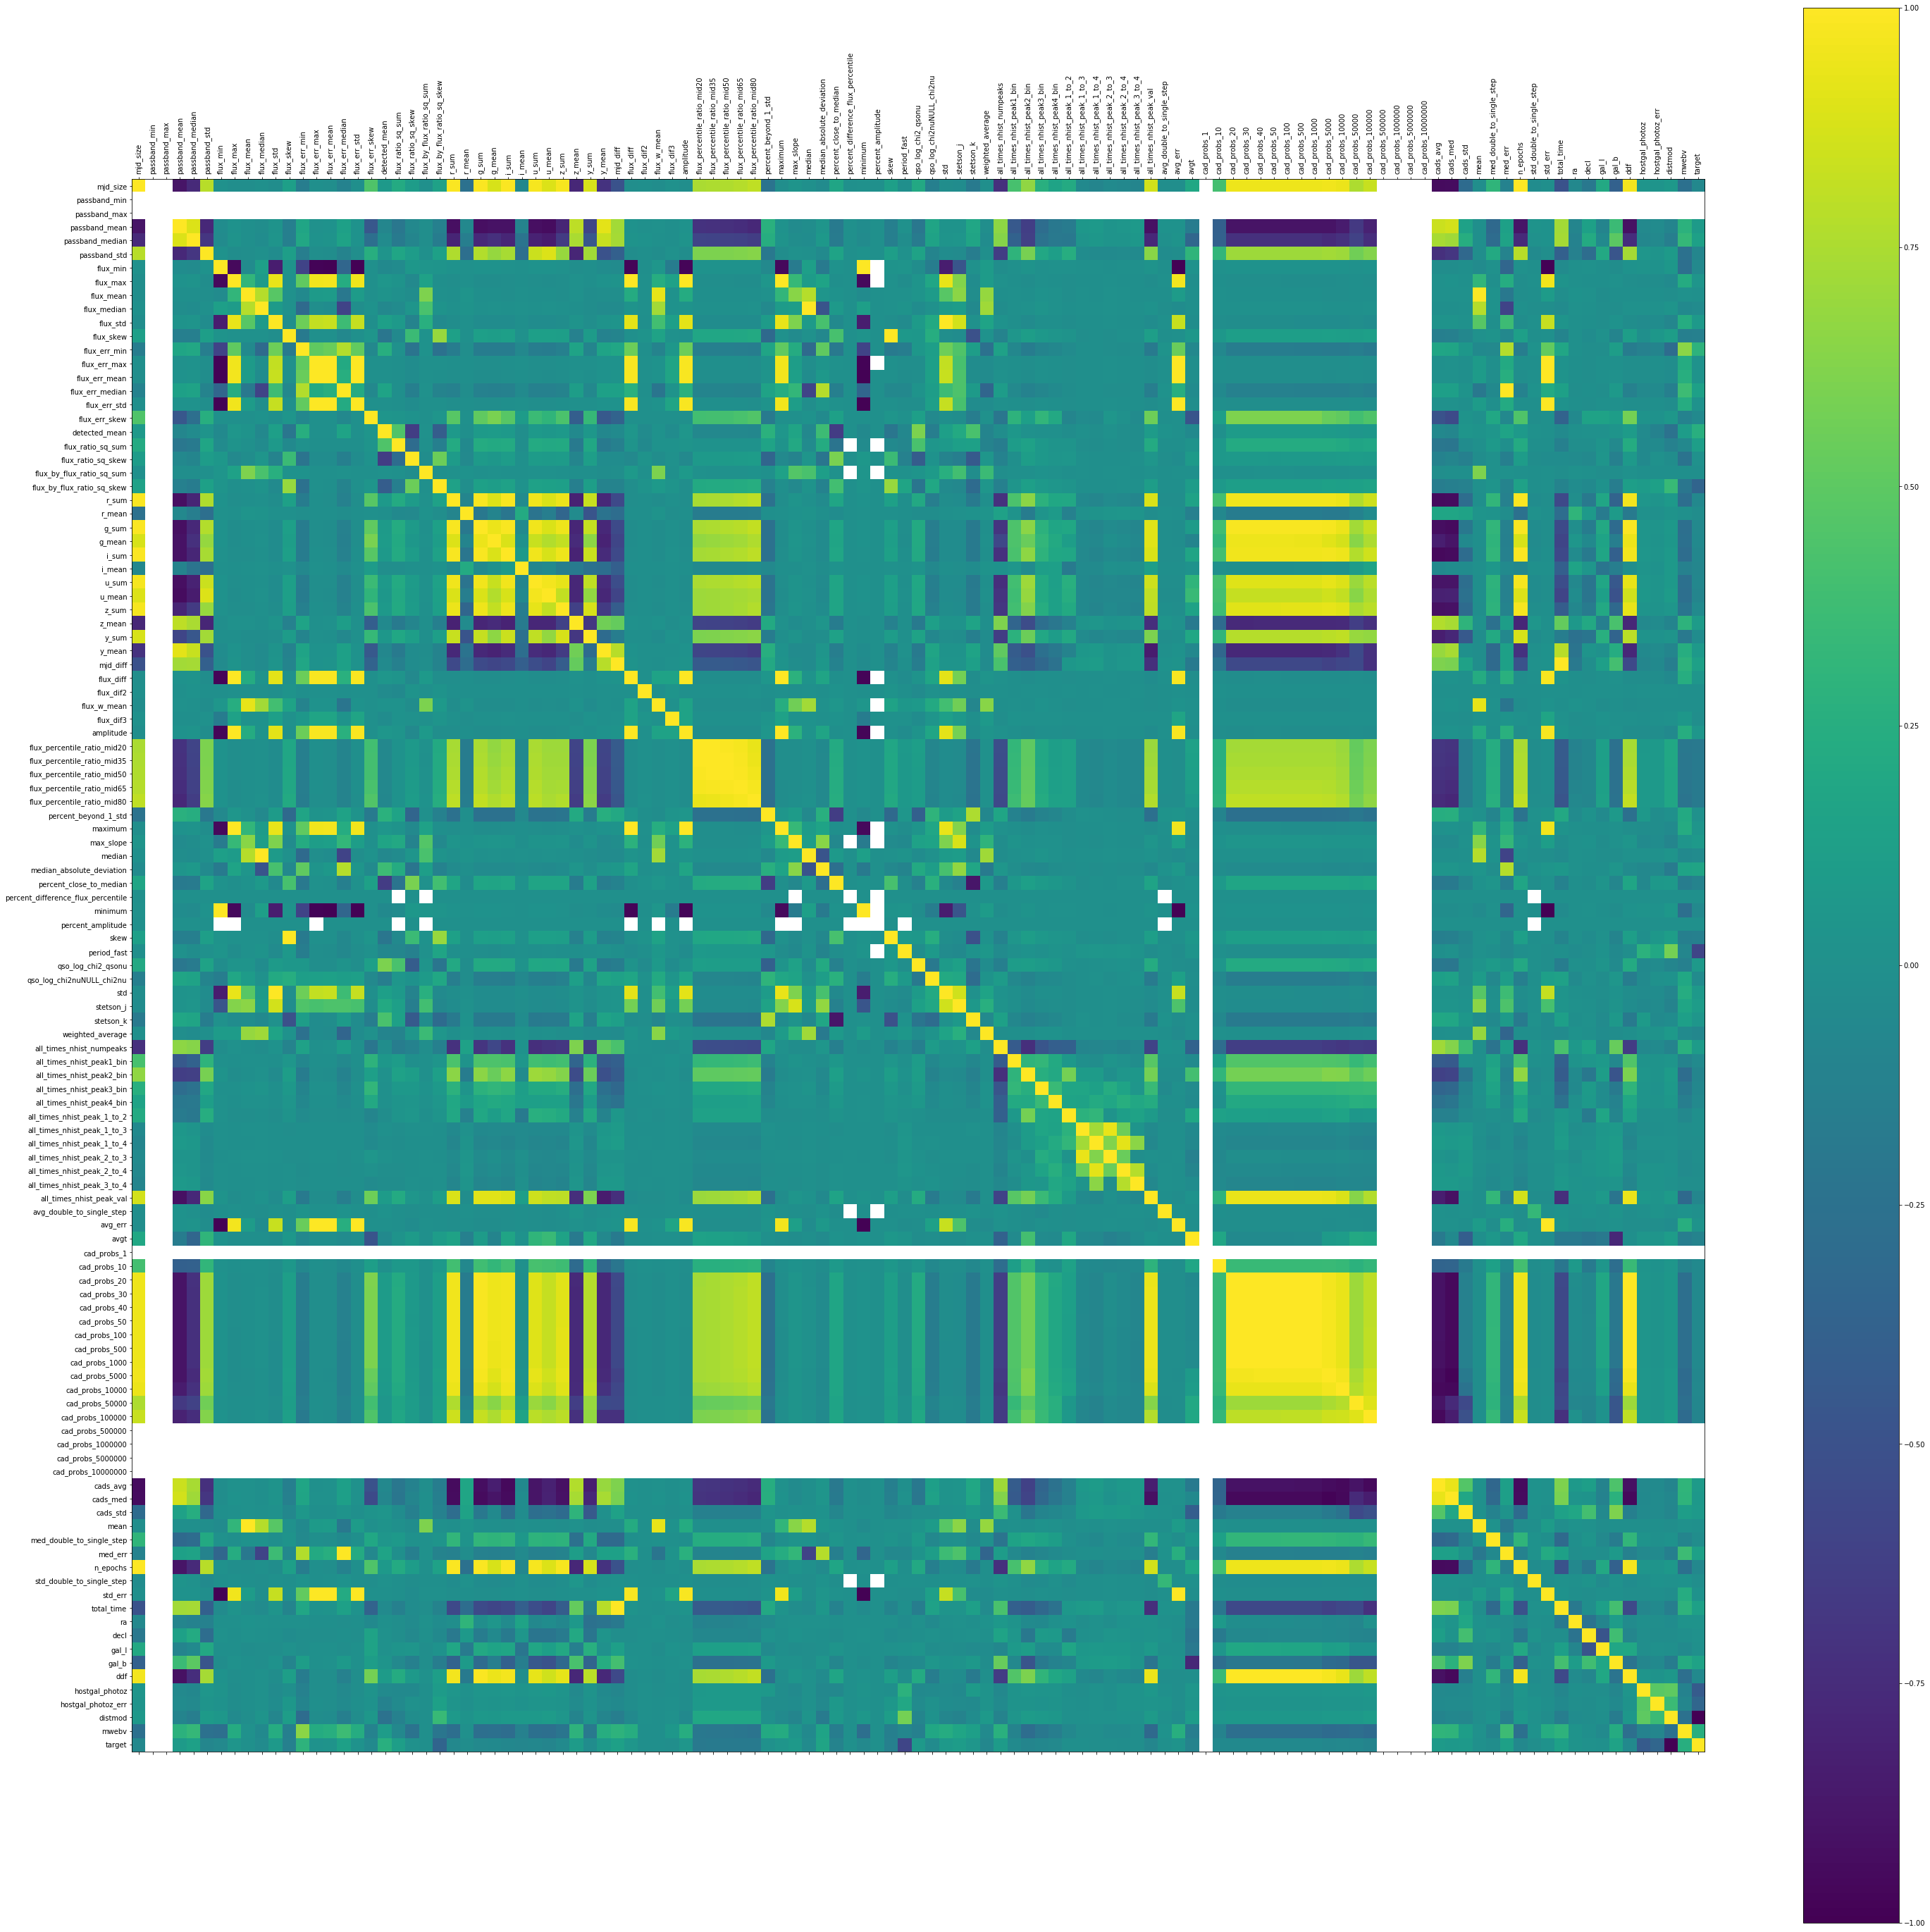

In [30]:
correlation = training_dataset.corr()
fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111)
cax = ax.matshow(correlation, vmin=-1, vmax=1, interpolation='none')
ticks = [i for i in range(training_dataset.shape[1])]
ticklabels = training_dataset.columns.values.tolist()
plt.xticks(ticks, ticklabels, rotation='vertical')
plt.yticks(ticks, ticklabels)
ax.axis('image')
# Text on the plot
# for y, row in enumerate(correlation.values):
#     for x, val in enumerate(row):
#         ax.text(x, y, format(val, '.2f'), color='black', ha='center', va='center')   
fig.colorbar(cax)
fig.savefig('training_dataset_correlation_plot.pdf')

# Prepare training data and labels

In [2]:
training_dataset = pd.read_csv('training_dataset_cleaned.csv', index_col=0)
training_dataset.head()

mjd_size  passband_mean  passband_median  passband_std  \
object_id                                                           
615             352       2.457386              2.0      1.720797   
713             350       2.400000              2.0      1.746056   
730             330       2.336364              2.0      1.758750   
745             351       2.378917              2.0      1.747328   
1124            352       2.457386              2.0      1.720797   

              flux_min    flux_max   flux_mean  flux_median  flux_std  \
object_id                                                               
615       -1100.440063  660.626343 -123.096998   -89.477524  1.899255   
713         -14.735178   14.770886   -1.423351    -0.873033  1.213788   
730         -19.159811   47.310059    2.267434     0.409172  1.293874   
745         -15.494463  220.795212    8.909206     1.035895  1.619018   
1124        -16.543753  143.600189    7.145702     1.141288  1.553364   

           flux_skew      ...             decl       gal_l      gal_b  ddf  \
object_id                 ...                                                
615        -0.349540      ...       -61.943836  320.796530 -51.753706    1   
713         0.014989      ...       -27.784405  223.525509 -54.460748    1   
730         3.177854      ...        -6.579593  170.455585 -61.548219    1   
745         4.979826      ...       -45.586655  328.254458 -68.969298    1   
1124        4.406298      ...       -63.823658  316.922299 -51.059403    1   

           hostgal_photoz  hostgal_photoz_err  distmod     mwebv    target  \
object_id                                                                    
615                0.0000              0.0000   0.0000 -4.074542  class_92   
713                1.6267              0.2552  45.4063 -4.961845  class_88   
730                0.2262              0.0157  40.2561 -3.863233  class_42   
745                0.2813              1.1523  40.7951 -4.961845  class_90   
1124               0.2415              0.0176  40.4166 -3.729701  class_90   

           in_our_galaxy  
object_id                 
615                    1  
713                    0  
730                    0  
745                    0  
1124                   0  

[5 rows x 109 columns]

In [3]:
# separate labels
Y = training_dataset['target']
Y.head()

object_id
615     class_92
713     class_88
730     class_42
745     class_90
1124    class_90
Name: target, dtype: object

In [4]:
# separate training values (exclude labels and object_id)
X = training_dataset.drop(['target'], axis=1)
X.head()

mjd_size  passband_mean  passband_median  passband_std  \
object_id                                                           
615             352       2.457386              2.0      1.720797   
713             350       2.400000              2.0      1.746056   
730             330       2.336364              2.0      1.758750   
745             351       2.378917              2.0      1.747328   
1124            352       2.457386              2.0      1.720797   

              flux_min    flux_max   flux_mean  flux_median  flux_std  \
object_id                                                               
615       -1100.440063  660.626343 -123.096998   -89.477524  1.899255   
713         -14.735178   14.770886   -1.423351    -0.873033  1.213788   
730         -19.159811   47.310059    2.267434     0.409172  1.293874   
745         -15.494463  220.795212    8.909206     1.035895  1.619018   
1124        -16.543753  143.600189    7.145702     1.141288  1.553364   

           flux_skew      ...                ra       decl       gal_l  \
object_id                 ...                                            
615        -0.349540      ...        349.046051 -61.943836  320.796530   
713         0.014989      ...         53.085938 -27.784405  223.525509   
730         3.177854      ...         33.574219  -6.579593  170.455585   
745         4.979826      ...          0.189873 -45.586655  328.254458   
1124        4.406298      ...        352.711273 -63.823658  316.922299   

               gal_b  ddf  hostgal_photoz  hostgal_photoz_err  distmod  \
object_id                                                                
615       -51.753706    1          0.0000              0.0000   0.0000   
713       -54.460748    1          1.6267              0.2552  45.4063   
730       -61.548219    1          0.2262              0.0157  40.2561   
745       -68.969298    1          0.2813              1.1523  40.7951   
1124      -51.059403    1          0.2415              0.0176  40.4166   

              mwebv  in_our_galaxy  
object_id                           
615       -4.074542              1  
713       -4.961845              0  
730       -3.863233              0  
745       -4.961845              0  
1124      -3.729701              0  

[5 rows x 108 columns]

# Cross Validation with different algorithms  
Version with all computed features

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import time
models = {"LogisticRegression": LogisticRegression(), "DecisionTreeClassifier": DecisionTreeClassifier(), 
          "KNeighborsClassifier": KNeighborsClassifier(), "LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(),
          "GaussianNB": GaussianNB(), "SVC": SVC(probability=True), "AdaBoostClassifier": AdaBoostClassifier(), 
          "GradientBoostingClassifier": GradientBoostingClassifier(), "RandomForestClassifier": RandomForestClassifier(),
          "ExtraTreesClassifier": ExtraTreesClassifier(), "XGBClassifier": XGBClassifier(),
          "LGBMClassifier": LGBMClassifier()}
models_score = pd.DataFrame(columns=["Model", "Mean", "Std", "Time"], data=np.zeros((len(models),4)))
for i, (name, model) in enumerate(models.items()):
    clf = make_pipeline(StandardScaler(), model)
    # perform cross validation (compute mean and std from 5 random treinings and predictions per algorithm)
    # scoring -> neg_log_loss (closer to 0 is better)
    # explenation of log_loss
    # https://stackoverflow.com/questions/35013822/log-loss-output-is-greater-than-1
    start = time.time()
    scores = cross_val_score(clf, X.values, Y, cv=5, scoring="neg_log_loss", n_jobs=-1)
    end = time.time()
    print("Log Loss: {:0.2f} (+/- {:0.2f}) Model: {} Elapsed time: {}".format(scores.mean(), scores.std() * 2, name, end-start))
    # store results in dataframe
    models_score["Model"][i] = name
    models_score["Mean"][i] = scores.mean()
    models_score["Std"][i] = scores.std()
    models_score["Time"][i] = end-start

Log Loss: -1.08 (+/- 0.40) Model: SVC Elapsed time: 45.37859082221985
Log Loss: -3.39 (+/- 0.54) Model: RandomForestClassifier Elapsed time: 1.5887222290039062
Log Loss: -21.29 (+/- 4.50) Model: GaussianNB Elapsed time: 0.24431967735290527
Log Loss: -0.84 (+/- 0.06) Model: XGBClassifier Elapsed time: 54.62789869308472
Log Loss: -14.41 (+/- 1.46) Model: DecisionTreeClassifier Elapsed time: 1.4830067157745361
Log Loss: -1.00 (+/- 0.07) Model: LogisticRegression Elapsed time: 17.9290189743042
Log Loss: -8.35 (+/- 4.25) Model: KNeighborsClassifier Elapsed time: 3.6402368545532227
Log Loss: -0.87 (+/- 0.06) Model: LGBMClassifier Elapsed time: 50.35130310058594
Log Loss: -0.86 (+/- 0.06) Model: GradientBoostingClassifier Elapsed time: 108.54366302490234
Log Loss: -3.80 (+/- 1.68) Model: ExtraTreesClassifier Elapsed time: 0.48966383934020996
Log Loss: -1.74 (+/- 0.14) Model: AdaBoostClassifier Elapsed time: 5.8314032554626465
Log Loss: -2.02 (+/- 0.00) Model: LinearDiscriminantAnalysis Elapse

# Deep Learning

In [2]:
training_dataset = pd.read_csv('training_dataset_cleaned.csv')
X = training_dataset.drop(['target', 'object_id'], axis=1)
Y = training_dataset['target']

In [3]:
training_dataset.head()

object_id  mjd_size  passband_mean  passband_median  passband_std  \
0        615       352       2.457386              2.0      1.720797   
1        713       350       2.400000              2.0      1.746056   
2        730       330       2.336364              2.0      1.758750   
3        745       351       2.378917              2.0      1.747328   
4       1124       352       2.457386              2.0      1.720797   

      flux_min    flux_max   flux_mean  flux_median  flux_std      ...        \
0 -1100.440063  660.626343 -123.096998   -89.477524  1.899255      ...         
1   -14.735178   14.770886   -1.423351    -0.873033  1.213788      ...         
2   -19.159811   47.310059    2.267434     0.409172  1.293874      ...         
3   -15.494463  220.795212    8.909206     1.035895  1.619018      ...         
4   -16.543753  143.600189    7.145702     1.141288  1.553364      ...         

        decl       gal_l      gal_b  ddf  hostgal_photoz  hostgal_photoz_err  \
0 -61.943836  320.796530 -51.753706    1          0.0000              0.0000   
1 -27.784405  223.525509 -54.460748    1          1.6267              0.2552   
2  -6.579593  170.455585 -61.548219    1          0.2262              0.0157   
3 -45.586655  328.254458 -68.969298    1          0.2813              1.1523   
4 -63.823658  316.922299 -51.059403    1          0.2415              0.0176   

   distmod     mwebv    target  in_our_galaxy  
0   0.0000 -4.074542  class_92              1  
1  45.4063 -4.961845  class_88              0  
2  40.2561 -3.863233  class_42              0  
3  40.7951 -4.961845  class_90              0  
4  40.4166 -3.729701  class_90              0  

[5 rows x 110 columns]

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

# define baseline model
def baseline_model(activation_1='softmax', n_neurons_1=116, n_neurons_2=115, dropaout_1=0.4, optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(n_neurons_1, input_dim=X.shape[1], activation=activation_1))
    model.add(Dropout(dropaout_1))
    model.add(Dense(n_neurons_2))
    model.add(Dropout(dropaout_1))
    model.add(Dense(n_neurons_2))
    model.add(Dropout(dropaout_1))
    model.add(Dense(n_neurons_2))
    model.add(Dropout(dropaout_1))
    model.add(Dense(n_neurons_2))
    model.add(Dropout(dropaout_1))
    model.add(Dense(len(set(Y)), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
    return model

Using TensorFlow backend.


In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

class_weights = {0: 1, 1: 2, 2: 1, 3: 1, 4: 2, 5: 2,
                6: 1, 7: 1, 8: 2, 9: 1, 10: 1, 11: 1,
                12: 2, 13: 1}

from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(X_scaled, dummy_y):
    train, test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = dummy_y[train_index], dummy_y[test_index]

#7848
model = baseline_model()
history = model.fit(train, y_train, batch_size=6000, nb_epoch=1300, verbose=1, validation_data=(test, y_test))
#                               class_weight=class_weights)

Train on 6278 samples, validate on 1570 samples
Epoch 1/1300
6278/6278 [==============================] - 1s 175us/step - loss: 2.6404 - categorical_accuracy: 0.0655 - val_loss: 2.5962 - val_categorical_accuracy: 0.2943
Epoch 2/1300
6278/6278 [==============================] - 0s 15us/step - loss: 2.5971 - categorical_accuracy: 0.2058 - val_loss: 2.5449 - val_categorical_accuracy: 0.2955
Epoch 3/1300
6278/6278 [==============================] - 0s 15us/step - loss: 2.5468 - categorical_accuracy: 0.2770 - val_loss: 2.4740 - val_categorical_accuracy: 0.2949
Epoch 4/1300
6278/6278 [==============================] - 0s 14us/step - loss: 2.4790 - categorical_accuracy: 0.2851 - val_loss: 2.3852 - val_categorical_accuracy: 0.2949
Epoch 5/1300
6278/6278 [==============================] - 0s 15us/step - loss: 2.3943 - categorical_accuracy: 0.2920 - val_loss: 2.2877 - val_categorical_accuracy: 0.2949
Epoch 6/1300
6278/6278 [==============================] - 0s 14us/step - loss: 2.3125 - categori

Epoch 96/1300
6278/6278 [==============================] - 0s 18us/step - loss: 1.1605 - categorical_accuracy: 0.5886 - val_loss: 1.0384 - val_categorical_accuracy: 0.6223
Epoch 97/1300
6278/6278 [==============================] - 0s 19us/step - loss: 1.1621 - categorical_accuracy: 0.5862 - val_loss: 1.0322 - val_categorical_accuracy: 0.6191
Epoch 98/1300
6278/6278 [==============================] - 0s 18us/step - loss: 1.1400 - categorical_accuracy: 0.5945 - val_loss: 1.0291 - val_categorical_accuracy: 0.6197
Epoch 99/1300
6278/6278 [==============================] - 0s 21us/step - loss: 1.1447 - categorical_accuracy: 0.5986 - val_loss: 1.0282 - val_categorical_accuracy: 0.6210
Epoch 100/1300
6278/6278 [==============================] - 0s 18us/step - loss: 1.1464 - categorical_accuracy: 0.5968 - val_loss: 1.0261 - val_categorical_accuracy: 0.6223
Epoch 101/1300
6278/6278 [==============================] - 0s 18us/step - loss: 1.1501 - categorical_accuracy: 0.5937 - val_loss: 1.0241 -

6278/6278 [==============================] - 0s 19us/step - loss: 1.0631 - categorical_accuracy: 0.6188 - val_loss: 0.9804 - val_categorical_accuracy: 0.6344
Epoch 191/1300
6278/6278 [==============================] - 0s 18us/step - loss: 1.0640 - categorical_accuracy: 0.6164 - val_loss: 0.9784 - val_categorical_accuracy: 0.6357
Epoch 192/1300
6278/6278 [==============================] - 0s 19us/step - loss: 1.0878 - categorical_accuracy: 0.6137 - val_loss: 0.9770 - val_categorical_accuracy: 0.6382
Epoch 193/1300
6278/6278 [==============================] - 0s 19us/step - loss: 1.0489 - categorical_accuracy: 0.6225 - val_loss: 0.9774 - val_categorical_accuracy: 0.6363
Epoch 194/1300
6278/6278 [==============================] - 0s 19us/step - loss: 1.0586 - categorical_accuracy: 0.6176 - val_loss: 0.9782 - val_categorical_accuracy: 0.6376
Epoch 195/1300
6278/6278 [==============================] - 0s 18us/step - loss: 1.0540 - categorical_accuracy: 0.6188 - val_loss: 0.9779 - val_catego

6278/6278 [==============================] - 0s 18us/step - loss: 1.0139 - categorical_accuracy: 0.6330 - val_loss: 0.9550 - val_categorical_accuracy: 0.6433
Epoch 285/1300
6278/6278 [==============================] - 0s 18us/step - loss: 1.0116 - categorical_accuracy: 0.6352 - val_loss: 0.9532 - val_categorical_accuracy: 0.6452
Epoch 286/1300
6278/6278 [==============================] - 0s 21us/step - loss: 1.0095 - categorical_accuracy: 0.6384 - val_loss: 0.9523 - val_categorical_accuracy: 0.6439
Epoch 287/1300
6278/6278 [==============================] - 0s 19us/step - loss: 1.0134 - categorical_accuracy: 0.6328 - val_loss: 0.9531 - val_categorical_accuracy: 0.6433
Epoch 288/1300
6278/6278 [==============================] - 0s 19us/step - loss: 1.0080 - categorical_accuracy: 0.6357 - val_loss: 0.9549 - val_categorical_accuracy: 0.6414
Epoch 289/1300
6278/6278 [==============================] - 0s 19us/step - loss: 1.0107 - categorical_accuracy: 0.6379 - val_loss: 0.9561 - val_catego

6278/6278 [==============================] - 0s 18us/step - loss: 0.9875 - categorical_accuracy: 0.6389 - val_loss: 0.9425 - val_categorical_accuracy: 0.6478
Epoch 379/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.9852 - categorical_accuracy: 0.6360 - val_loss: 0.9425 - val_categorical_accuracy: 0.6459
Epoch 380/1300
6278/6278 [==============================] - 0s 20us/step - loss: 0.9857 - categorical_accuracy: 0.6448 - val_loss: 0.9427 - val_categorical_accuracy: 0.6459
Epoch 381/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.9860 - categorical_accuracy: 0.6430 - val_loss: 0.9435 - val_categorical_accuracy: 0.6484
Epoch 382/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.9916 - categorical_accuracy: 0.6430 - val_loss: 0.9456 - val_categorical_accuracy: 0.6490
Epoch 383/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.9890 - categorical_accuracy: 0.6418 - val_loss: 0.9471 - val_catego

6278/6278 [==============================] - 0s 18us/step - loss: 0.9644 - categorical_accuracy: 0.6507 - val_loss: 0.9242 - val_categorical_accuracy: 0.6497
Epoch 473/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.9624 - categorical_accuracy: 0.6491 - val_loss: 0.9243 - val_categorical_accuracy: 0.6529
Epoch 474/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.9610 - categorical_accuracy: 0.6496 - val_loss: 0.9251 - val_categorical_accuracy: 0.6510
Epoch 475/1300
6278/6278 [==============================] - 0s 20us/step - loss: 0.9695 - categorical_accuracy: 0.6473 - val_loss: 0.9248 - val_categorical_accuracy: 0.6478
Epoch 476/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.9567 - categorical_accuracy: 0.6510 - val_loss: 0.9241 - val_categorical_accuracy: 0.6471
Epoch 477/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.9575 - categorical_accuracy: 0.6494 - val_loss: 0.9243 - val_catego

6278/6278 [==============================] - 0s 18us/step - loss: 0.9392 - categorical_accuracy: 0.6609 - val_loss: 0.9118 - val_categorical_accuracy: 0.6637
Epoch 567/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.9328 - categorical_accuracy: 0.6596 - val_loss: 0.9125 - val_categorical_accuracy: 0.6675
Epoch 568/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.9263 - categorical_accuracy: 0.6633 - val_loss: 0.9143 - val_categorical_accuracy: 0.6656
Epoch 569/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.9373 - categorical_accuracy: 0.6644 - val_loss: 0.9149 - val_categorical_accuracy: 0.6669
Epoch 570/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.9388 - categorical_accuracy: 0.6606 - val_loss: 0.9139 - val_categorical_accuracy: 0.6656
Epoch 571/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.9350 - categorical_accuracy: 0.6569 - val_loss: 0.9122 - val_catego

6278/6278 [==============================] - 0s 19us/step - loss: 0.9134 - categorical_accuracy: 0.6612 - val_loss: 0.8915 - val_categorical_accuracy: 0.6707
Epoch 661/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.9218 - categorical_accuracy: 0.6701 - val_loss: 0.8946 - val_categorical_accuracy: 0.6701
Epoch 662/1300
6278/6278 [==============================] - 0s 24us/step - loss: 0.9207 - categorical_accuracy: 0.6671 - val_loss: 0.8994 - val_categorical_accuracy: 0.6669
Epoch 663/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.9213 - categorical_accuracy: 0.6668 - val_loss: 0.9001 - val_categorical_accuracy: 0.6675
Epoch 664/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.9229 - categorical_accuracy: 0.6644 - val_loss: 0.8983 - val_categorical_accuracy: 0.6688
Epoch 665/1300
6278/6278 [==============================] - 0s 17us/step - loss: 0.9184 - categorical_accuracy: 0.6663 - val_loss: 0.8983 - val_catego

6278/6278 [==============================] - 0s 19us/step - loss: 0.8887 - categorical_accuracy: 0.6778 - val_loss: 0.8824 - val_categorical_accuracy: 0.6783
Epoch 755/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.8932 - categorical_accuracy: 0.6805 - val_loss: 0.8827 - val_categorical_accuracy: 0.6783
Epoch 756/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.8978 - categorical_accuracy: 0.6776 - val_loss: 0.8818 - val_categorical_accuracy: 0.6796
Epoch 757/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.8901 - categorical_accuracy: 0.6806 - val_loss: 0.8817 - val_categorical_accuracy: 0.6777
Epoch 758/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.8884 - categorical_accuracy: 0.6762 - val_loss: 0.8811 - val_categorical_accuracy: 0.6764
Epoch 759/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.9012 - categorical_accuracy: 0.6771 - val_loss: 0.8797 - val_catego

6278/6278 [==============================] - 0s 17us/step - loss: 0.8822 - categorical_accuracy: 0.6814 - val_loss: 0.8749 - val_categorical_accuracy: 0.6803
Epoch 849/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.8664 - categorical_accuracy: 0.6864 - val_loss: 0.8739 - val_categorical_accuracy: 0.6783
Epoch 850/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.8712 - categorical_accuracy: 0.6892 - val_loss: 0.8733 - val_categorical_accuracy: 0.6815
Epoch 851/1300
6278/6278 [==============================] - 0s 20us/step - loss: 0.8663 - categorical_accuracy: 0.6845 - val_loss: 0.8736 - val_categorical_accuracy: 0.6783
Epoch 852/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.8831 - categorical_accuracy: 0.6811 - val_loss: 0.8752 - val_categorical_accuracy: 0.6809
Epoch 853/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.8764 - categorical_accuracy: 0.6873 - val_loss: 0.8751 - val_catego

6278/6278 [==============================] - 0s 19us/step - loss: 0.8574 - categorical_accuracy: 0.6915 - val_loss: 0.8741 - val_categorical_accuracy: 0.6828
Epoch 943/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.8586 - categorical_accuracy: 0.6956 - val_loss: 0.8734 - val_categorical_accuracy: 0.6854
Epoch 944/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.8678 - categorical_accuracy: 0.6903 - val_loss: 0.8735 - val_categorical_accuracy: 0.6834
Epoch 945/1300
6278/6278 [==============================] - 0s 20us/step - loss: 0.8637 - categorical_accuracy: 0.6924 - val_loss: 0.8776 - val_categorical_accuracy: 0.6752
Epoch 946/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.8615 - categorical_accuracy: 0.6864 - val_loss: 0.8821 - val_categorical_accuracy: 0.6675
Epoch 947/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.8636 - categorical_accuracy: 0.6849 - val_loss: 0.8792 - val_catego

6278/6278 [==============================] - 0s 19us/step - loss: 0.8482 - categorical_accuracy: 0.6993 - val_loss: 0.8702 - val_categorical_accuracy: 0.6758
Epoch 1037/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.8492 - categorical_accuracy: 0.6962 - val_loss: 0.8696 - val_categorical_accuracy: 0.6732
Epoch 1038/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.8677 - categorical_accuracy: 0.6899 - val_loss: 0.8669 - val_categorical_accuracy: 0.6796
Epoch 1039/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.8539 - categorical_accuracy: 0.6943 - val_loss: 0.8655 - val_categorical_accuracy: 0.6834
Epoch 1040/1300
6278/6278 [==============================] - 0s 20us/step - loss: 0.8542 - categorical_accuracy: 0.6962 - val_loss: 0.8666 - val_categorical_accuracy: 0.6828
Epoch 1041/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.8477 - categorical_accuracy: 0.6993 - val_loss: 0.8661 - val_c

6278/6278 [==============================] - 0s 20us/step - loss: 0.8433 - categorical_accuracy: 0.7013 - val_loss: 0.8692 - val_categorical_accuracy: 0.6790
Epoch 1131/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.8378 - categorical_accuracy: 0.7021 - val_loss: 0.8727 - val_categorical_accuracy: 0.6783
Epoch 1132/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.8510 - categorical_accuracy: 0.6943 - val_loss: 0.8705 - val_categorical_accuracy: 0.6809
Epoch 1133/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.8494 - categorical_accuracy: 0.6986 - val_loss: 0.8692 - val_categorical_accuracy: 0.6815
Epoch 1134/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.8586 - categorical_accuracy: 0.6972 - val_loss: 0.8715 - val_categorical_accuracy: 0.6815
Epoch 1135/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.8384 - categorical_accuracy: 0.7015 - val_loss: 0.8699 - val_c

6278/6278 [==============================] - 0s 18us/step - loss: 0.8320 - categorical_accuracy: 0.7017 - val_loss: 0.8710 - val_categorical_accuracy: 0.6752
Epoch 1225/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.8290 - categorical_accuracy: 0.7061 - val_loss: 0.8716 - val_categorical_accuracy: 0.6758
Epoch 1226/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.8401 - categorical_accuracy: 0.7026 - val_loss: 0.8717 - val_categorical_accuracy: 0.6771
Epoch 1227/1300
6278/6278 [==============================] - 0s 19us/step - loss: 0.8197 - categorical_accuracy: 0.7061 - val_loss: 0.8721 - val_categorical_accuracy: 0.6764
Epoch 1228/1300
6278/6278 [==============================] - 0s 18us/step - loss: 0.8245 - categorical_accuracy: 0.7050 - val_loss: 0.8711 - val_categorical_accuracy: 0.6745
Epoch 1229/1300
6278/6278 [==============================] - 0s 21us/step - loss: 0.8291 - categorical_accuracy: 0.7068 - val_loss: 0.8707 - val_c

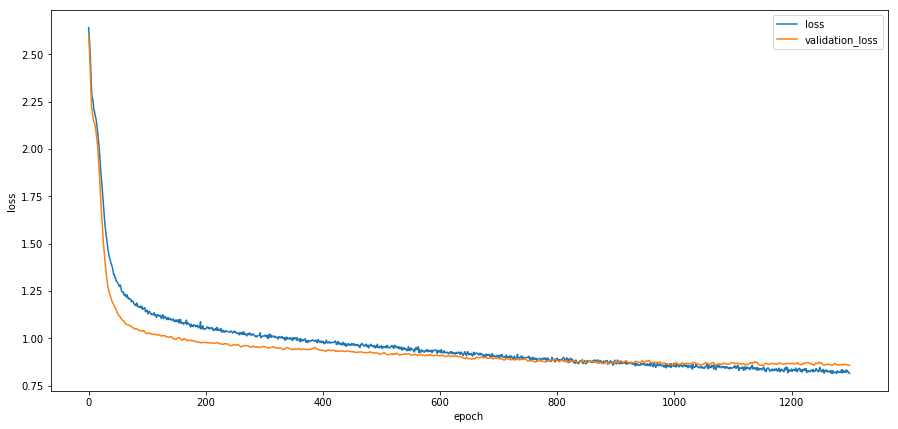

In [31]:
loss = plt.figure(figsize=(15,7))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

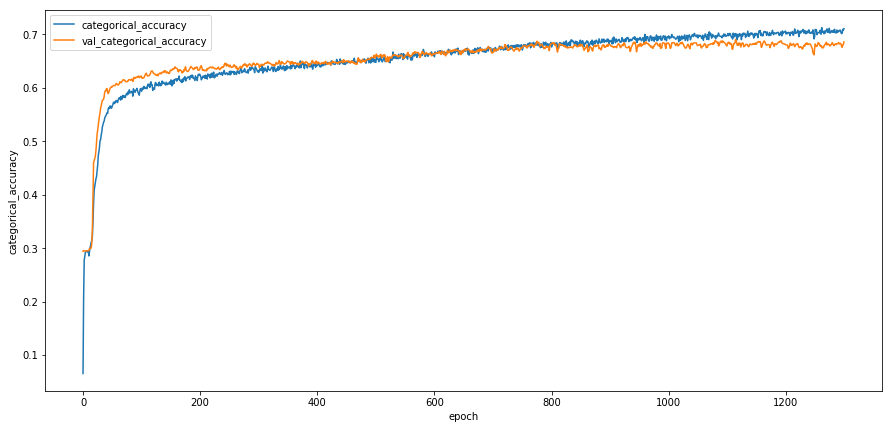

In [32]:
loss = plt.figure(figsize=(15,7))
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend()

# Ensambling best models (NN, XGB, LGBM)

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(X_scaled, dummy_y):
    train, test = X_scaled[train_index], X_scaled[test_index]
    y_train_dummy, y_test_dummy = dummy_y[train_index], dummy_y[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

Using TensorFlow backend.


In [6]:
# define baseline model
def baseline_model(activation_1='softmax', n_neurons_1=116, n_neurons_2=115, dropaout_1=0.4, optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(n_neurons_1, input_dim=X.shape[1], activation=activation_1))
    model.add(Dropout(dropaout_1))
    model.add(Dense(n_neurons_2))
    model.add(Dropout(dropaout_1))
    model.add(Dense(n_neurons_2))
    model.add(Dropout(dropaout_1))
    model.add(Dense(n_neurons_2))
    model.add(Dropout(dropaout_1))
    model.add(Dense(n_neurons_2))
    model.add(Dropout(dropaout_1))
    model.add(Dense(len(set(Y)), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
    return model
model = baseline_model()
history = model.fit(train, y_train_dummy, batch_size=6000, nb_epoch=813, verbose=1)

Epoch 1/813
6278/6278 [==============================] - 1s 132us/step - loss: 2.6432 - categorical_accuracy: 0.0637
Epoch 2/813
6278/6278 [==============================] - 0s 16us/step - loss: 2.5920 - categorical_accuracy: 0.2306
Epoch 3/813
6278/6278 [==============================] - 0s 15us/step - loss: 2.5364 - categorical_accuracy: 0.2877
Epoch 4/813
6278/6278 [==============================] - 0s 15us/step - loss: 2.4649 - categorical_accuracy: 0.2931
Epoch 5/813
6278/6278 [==============================] - 0s 16us/step - loss: 2.3754 - categorical_accuracy: 0.2985
Epoch 6/813
6278/6278 [==============================] - 0s 15us/step - loss: 2.2931 - categorical_accuracy: 0.2953
Epoch 7/813
6278/6278 [==============================] - 0s 15us/step - loss: 2.2454 - categorical_accuracy: 0.2948
Epoch 8/813
6278/6278 [==============================] - 0s 14us/step - loss: 2.2309 - categorical_accuracy: 0.2920
Epoch 9/813
6278/6278 [==============================] - 0s 15us/step -

6278/6278 [==============================] - 0s 15us/step - loss: 1.2142 - categorical_accuracy: 0.5839
Epoch 72/813
6278/6278 [==============================] - 0s 15us/step - loss: 1.2040 - categorical_accuracy: 0.5874
Epoch 73/813
6278/6278 [==============================] - 0s 14us/step - loss: 1.1943 - categorical_accuracy: 0.5833
Epoch 74/813
6278/6278 [==============================] - 0s 15us/step - loss: 1.1987 - categorical_accuracy: 0.5851
Epoch 75/813
6278/6278 [==============================] - 0s 14us/step - loss: 1.1917 - categorical_accuracy: 0.5841
Epoch 76/813
6278/6278 [==============================] - 0s 15us/step - loss: 1.1926 - categorical_accuracy: 0.5919
Epoch 77/813
6278/6278 [==============================] - 0s 14us/step - loss: 1.1864 - categorical_accuracy: 0.5873
Epoch 78/813
6278/6278 [==============================] - 0s 14us/step - loss: 1.1886 - categorical_accuracy: 0.5879
Epoch 79/813
6278/6278 [==============================] - 0s 13us/step - loss

6278/6278 [==============================] - 0s 14us/step - loss: 1.0484 - categorical_accuracy: 0.6244
Epoch 210/813
6278/6278 [==============================] - 0s 15us/step - loss: 1.0503 - categorical_accuracy: 0.6219
Epoch 211/813
6278/6278 [==============================] - 0s 16us/step - loss: 1.0526 - categorical_accuracy: 0.6255
Epoch 212/813
6278/6278 [==============================] - 0s 14us/step - loss: 1.0601 - categorical_accuracy: 0.6183
Epoch 213/813
6278/6278 [==============================] - 0s 14us/step - loss: 1.0564 - categorical_accuracy: 0.6238
Epoch 214/813
6278/6278 [==============================] - 0s 15us/step - loss: 1.0523 - categorical_accuracy: 0.6274
Epoch 215/813
6278/6278 [==============================] - 0s 15us/step - loss: 1.0520 - categorical_accuracy: 0.6231
Epoch 216/813
6278/6278 [==============================] - 0s 14us/step - loss: 1.0568 - categorical_accuracy: 0.6252
Epoch 217/813
6278/6278 [==============================] - 0s 14us/ste

6278/6278 [==============================] - 0s 21us/step - loss: 0.9947 - categorical_accuracy: 0.6440
Epoch 348/813
6278/6278 [==============================] - 0s 22us/step - loss: 1.0018 - categorical_accuracy: 0.6392
Epoch 349/813
6278/6278 [==============================] - 0s 18us/step - loss: 1.0027 - categorical_accuracy: 0.6413
Epoch 350/813
6278/6278 [==============================] - 0s 19us/step - loss: 1.0032 - categorical_accuracy: 0.6424
Epoch 351/813
6278/6278 [==============================] - 0s 16us/step - loss: 0.9989 - categorical_accuracy: 0.6376
Epoch 352/813
6278/6278 [==============================] - 0s 15us/step - loss: 0.9990 - categorical_accuracy: 0.6389
Epoch 353/813
6278/6278 [==============================] - 0s 17us/step - loss: 0.9900 - categorical_accuracy: 0.6440
Epoch 354/813
6278/6278 [==============================] - 0s 20us/step - loss: 0.9942 - categorical_accuracy: 0.6368
Epoch 355/813
6278/6278 [==============================] - 0s 23us/ste

6278/6278 [==============================] - 0s 14us/step - loss: 0.9631 - categorical_accuracy: 0.6470
Epoch 486/813
6278/6278 [==============================] - 0s 15us/step - loss: 0.9565 - categorical_accuracy: 0.6508
Epoch 487/813
6278/6278 [==============================] - 0s 14us/step - loss: 0.9591 - categorical_accuracy: 0.6461
Epoch 488/813
6278/6278 [==============================] - 0s 14us/step - loss: 0.9630 - categorical_accuracy: 0.6494
Epoch 489/813
6278/6278 [==============================] - 0s 14us/step - loss: 0.9611 - categorical_accuracy: 0.6507
Epoch 490/813
6278/6278 [==============================] - 0s 13us/step - loss: 0.9632 - categorical_accuracy: 0.6518
Epoch 491/813
6278/6278 [==============================] - 0s 14us/step - loss: 0.9657 - categorical_accuracy: 0.6532
Epoch 492/813
6278/6278 [==============================] - 0s 13us/step - loss: 0.9585 - categorical_accuracy: 0.6507
Epoch 493/813
6278/6278 [==============================] - 0s 14us/ste

6278/6278 [==============================] - 0s 15us/step - loss: 0.9295 - categorical_accuracy: 0.6647
Epoch 624/813
6278/6278 [==============================] - 0s 16us/step - loss: 0.9339 - categorical_accuracy: 0.6639
Epoch 625/813
6278/6278 [==============================] - 0s 14us/step - loss: 0.9221 - categorical_accuracy: 0.6680
Epoch 626/813
6278/6278 [==============================] - 0s 16us/step - loss: 0.9243 - categorical_accuracy: 0.6636
Epoch 627/813
6278/6278 [==============================] - 0s 16us/step - loss: 0.9272 - categorical_accuracy: 0.6612
Epoch 628/813
6278/6278 [==============================] - 0s 15us/step - loss: 0.9252 - categorical_accuracy: 0.6701
Epoch 629/813
6278/6278 [==============================] - 0s 15us/step - loss: 0.9378 - categorical_accuracy: 0.6594
Epoch 630/813
6278/6278 [==============================] - 0s 14us/step - loss: 0.9336 - categorical_accuracy: 0.6599
Epoch 631/813
6278/6278 [==============================] - 0s 15us/ste

6278/6278 [==============================] - 0s 15us/step - loss: 0.8940 - categorical_accuracy: 0.6766
Epoch 762/813
6278/6278 [==============================] - 0s 16us/step - loss: 0.8885 - categorical_accuracy: 0.6814
Epoch 763/813
6278/6278 [==============================] - 0s 14us/step - loss: 0.8909 - categorical_accuracy: 0.6784
Epoch 764/813
6278/6278 [==============================] - 0s 15us/step - loss: 0.8965 - categorical_accuracy: 0.6762
Epoch 765/813
6278/6278 [==============================] - 0s 16us/step - loss: 0.8954 - categorical_accuracy: 0.6809
Epoch 766/813
6278/6278 [==============================] - 0s 16us/step - loss: 0.9026 - categorical_accuracy: 0.6706
Epoch 767/813
6278/6278 [==============================] - 0s 15us/step - loss: 0.8893 - categorical_accuracy: 0.6835
Epoch 768/813
6278/6278 [==============================] - 0s 15us/step - loss: 0.8898 - categorical_accuracy: 0.6800
Epoch 769/813
6278/6278 [==============================] - 0s 15us/ste

In [7]:
# serialize model to JSON
model_json = model.to_json()
with open("model_NN.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_NN.h5")
print("Saved model to disk")

Saved model to disk


In [32]:
train = pd.DataFrame(data=train, columns=X.columns.values)
test = pd.DataFrame(data=test, columns=X.columns.values)

In [29]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
xgb = XGBClassifier()
xgb.fit(train, y_train)
lgbm = LGBMClassifier()
lgbm.fit(train, y_train)
gb = GradientBoostingClassifier()
gb.fit(train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [30]:
# save the model to disk
import pickle
filename = 'xgb.sav'
pickle.dump(xgb, open(filename, 'wb'))
filename = 'lgbm.sav'
pickle.dump(lgbm, open(filename, 'wb'))
filename = 'gb.sav'
pickle.dump(gb, open(filename, 'wb'))

In [33]:
NN_predict = model.predict(test)
xgb_predict = xgb.predict_proba(test)
lgbm_predict = lgbm.predict_proba(test)
gb_predict = gb.predict_proba(test)

In [34]:
NN_predict_pd = pd.DataFrame(data=NN_predict, columns=encoder.classes_)
xgb_predict_pd = pd.DataFrame(data=xgb_predict, columns=xgb.classes_)
lgbm_predict_pd = pd.DataFrame(data=lgbm_predict, columns=lgbm.classes_)
gb_predict_pd = pd.DataFrame(data=gb_predict, columns=gb.classes_)

In [35]:
avg_pd = (NN_predict_pd + xgb_predict_pd + lgbm_predict_pd) / 3
avg_pd.head()

class_15  class_16  class_42  class_52  class_53   class_6  class_62  \
0  0.179605  0.000611  0.291160  0.039484  0.000478  0.000487  0.032623   
1  0.174737  0.000477  0.226802  0.020842  0.000339  0.000341  0.056493   
2  0.005496  0.433658  0.003072  0.002406  0.000534  0.469230  0.003421   
3  0.000433  0.998405  0.000172  0.000112  0.000065  0.000070  0.000074   
4  0.005515  0.715409  0.004080  0.005655  0.000405  0.017982  0.004644   

   class_64  class_65  class_67  class_88  class_90  class_92  class_95  
0  0.000614  0.000502  0.012595  0.000747  0.409135  0.000476  0.031482  
1  0.000730  0.000337  0.007514  0.000366  0.510122  0.000336  0.000564  
2  0.001255  0.010331  0.001274  0.004534  0.003013  0.061066  0.000709  
3  0.000021  0.000059  0.000045  0.000221  0.000157  0.000101  0.000063  
4  0.003481  0.232858  0.001494  0.000820  0.005519  0.001453  0.000685

In [36]:
avg_pd_4 = (NN_predict_pd + xgb_predict_pd + lgbm_predict_pd + gb_predict_pd) / 4
avg_pd_4.head()

class_15  class_16  class_42  class_52  class_53   class_6  class_62  \
0  0.188487  0.000517  0.267439  0.038347  0.000363  0.000428  0.033167   
1  0.164407  0.000396  0.209026  0.020179  0.000257  0.000286  0.055148   
2  0.006543  0.468099  0.005208  0.002900  0.000403  0.441457  0.005410   
3  0.000352  0.998604  0.000151  0.000095  0.000049  0.000091  0.000066   
4  0.006050  0.760069  0.003852  0.005099  0.000304  0.015567  0.004024   

   class_64  class_65  class_67  class_88  class_90  class_92  class_95  
0  0.000602  0.000426  0.012699  0.000732  0.422622  0.000393  0.033779  
1  0.000659  0.000279  0.006823  0.000321  0.541392  0.000272  0.000556  
2  0.001212  0.012136  0.001446  0.004094  0.004313  0.046005  0.000773  
3  0.000017  0.000056  0.000038  0.000193  0.000154  0.000079  0.000055  
4  0.003085  0.192090  0.001552  0.001136  0.005537  0.001094  0.000541

In [37]:
w_avg_pd = (0.6*NN_predict_pd + 0.9*xgb_predict_pd + 0.8*lgbm_predict_pd) / 3
w_avg_pd.head()

class_15  class_16  class_42  class_52  class_53   class_6  class_62  \
0  0.137457  0.000520  0.220301  0.031199  0.000400  0.000408  0.022955   
1  0.139150  0.000414  0.179676  0.015716  0.000289  0.000291  0.046118   
2  0.004906  0.307181  0.002710  0.002157  0.000474  0.387677  0.003061   
3  0.000388  0.765239  0.000153  0.000101  0.000058  0.000063  0.000067   
4  0.004708  0.544251  0.003377  0.004767  0.000333  0.011660  0.003960   

   class_64  class_65  class_67  class_88  class_90  class_92  class_95  
0  0.000511  0.000421  0.009097  0.000590  0.320680  0.000397  0.021732  
1  0.000621  0.000287  0.005228  0.000313  0.377816  0.000287  0.000461  
2  0.001122  0.009016  0.001136  0.004067  0.002676  0.039852  0.000631  
3  0.000019  0.000053  0.000041  0.000199  0.000140  0.000091  0.000057  
4  0.003067  0.182327  0.001265  0.000704  0.004706  0.000977  0.000565

In [38]:
w_avg_pd_4 = (0.7*NN_predict_pd + 0.9*xgb_predict_pd + 0.8*lgbm_predict_pd + 0.5*gb_predict_pd) / 4
w_avg_pd_4.head()

class_15  class_16  class_42  class_52  class_53   class_6  class_62  \
0  0.135105  0.000419  0.196991  0.028397  0.000302  0.000337  0.023015   
1  0.124449  0.000329  0.158217  0.014783  0.000218  0.000233  0.041559   
2  0.004890  0.322403  0.003485  0.002166  0.000356  0.336103  0.003718   
3  0.000305  0.723829  0.000126  0.000081  0.000044  0.000066  0.000055   
4  0.004488  0.541301  0.002928  0.004004  0.000250  0.010901  0.003240   

   class_64  class_65  class_67  class_88  class_90  class_92  class_95  
0  0.000457  0.000341  0.008951  0.000541  0.306867  0.000316  0.022961  
1  0.000526  0.000229  0.004877  0.000259  0.378676  0.000225  0.000420  
2  0.000977  0.009020  0.001097  0.003397  0.003034  0.033760  0.000594  
3  0.000015  0.000046  0.000032  0.000162  0.000123  0.000070  0.000047  
4  0.002537  0.147921  0.001164  0.000789  0.004228  0.000810  0.000438

In [39]:
y_test_dummy_pd = pd.DataFrame(data=y_test_dummy, columns=encoder.classes_)
y_test_dummy_pd.head()

class_15  class_16  class_42  class_52  class_53  class_6  class_62  \
0       0.0       0.0       0.0       0.0       0.0      0.0       0.0   
1       1.0       0.0       0.0       0.0       0.0      0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0      1.0       0.0   
3       0.0       1.0       0.0       0.0       0.0      0.0       0.0   
4       0.0       1.0       0.0       0.0       0.0      0.0       0.0   

   class_64  class_65  class_67  class_88  class_90  class_92  class_95  
0       0.0       0.0       0.0       0.0       1.0       0.0       0.0  
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0  
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0  
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0  
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0

In [40]:
from sklearn.metrics import log_loss
print("Log_loss for NN: {}".format(log_loss(y_test_dummy_pd, NN_predict_pd)))
print("Log_loss for lgbm: {}".format(log_loss(y_test_dummy_pd, lgbm_predict_pd)))
print("Log_loss for xgb: {}".format(log_loss(y_test_dummy_pd, xgb_predict_pd)))
print("Log_loss for gb: {}".format(log_loss(y_test_dummy_pd, gb_predict_pd)))
print("Log_loss for avarage(NN,xgb,lgbm): {}".format(log_loss(y_test_dummy_pd, avg_pd)))
print("Log_loss for avarage(NN,xgb,lgbm,gb): {}".format(log_loss(y_test_dummy_pd, avg_pd_4)))
print("Log_loss for weighted avarage(NN,xgb,lgbm): {}".format(log_loss(y_test_dummy_pd, w_avg_pd)))
print("Log_loss for weighted avarage(NN,xgb,lgbm,gb): {}".format(log_loss(y_test_dummy_pd, w_avg_pd_4)))

Log_loss for NN: 0.8806980428834065
Log_loss for lgbm: 0.7936963327189469
Log_loss for xgb: 0.7861162246535621
Log_loss for gb: 0.8069641299359359
Log_loss for avarage(NN,xgb,lgbm): 0.7681002175155974
Log_loss for avarage(NN,xgb,lgbm,gb): 0.7665335892102405
Log_loss for weighted avarage(NN,xgb,lgbm): 0.7639406545659733
Log_loss for weighted avarage(NN,xgb,lgbm,gb): 0.7649467435279168


# Use ELI5 to find out features importance

***Train tst split***

In [56]:
import eli5
from eli5 import explain_weights
from eli5 import format_as_dataframe
from eli5 import show_weights
from xgboost import XGBRegressor
def _check_booster_args(xgb, is_regression=None):
    # type: (Any, bool) -> Tuple[Booster, bool]
    if isinstance(xgb, eli5.xgboost.Booster): # patch (from "xgb, Booster")
        booster = xgb
    else:
        booster = xgb.get_booster() # patch (from "xgb.booster()" where `booster` is now a string)
        _is_regression = isinstance(xgb, XGBRegressor)
        if is_regression is not None and is_regression != _is_regression:
            raise ValueError(
                'Inconsistent is_regression={} passed. '
                'You don\'t have to pass it when using scikit-learn API'
                .format(is_regression))
        is_regression = _is_regression
    return booster, is_regression

eli5.xgboost._check_booster_args = _check_booster_args
eli5_df = format_as_dataframe(explain_weights(xgb, 
                                              feature_names = X.columns.values, 
                                              top = None))

show_weights(xgb, top=30)

In [101]:
eli5_df[eli5_df['weight'] >= 0.006]['feature'].values

array(['distmod', 'flux_by_flux_ratio_sq_skew', 'cad_probs_50',
       'median_absolute_deviation', 'hostgal_photoz', 'skew', 'stetson_k',
       'hostgal_photoz_err', 'flux_skew', 'flux_dif2', 'stetson_j',
       'flux_percentile_ratio_mid65', 'percent_close_to_median',
       'flux_w_mean', 'percent_beyond_1_std', 'flux_err_std', 'flux_std',
       'period_fast', 'flux_max', 'flux_median', 'weighted_average',
       'flux_err_mean', 'flux_by_flux_ratio_sq_sum',
       'qso_log_chi2nuNULL_chi2nu', 'z_mean', 'flux_mean', 'cad_probs_20',
       'flux_err_min', 'flux_diff', 'flux_ratio_sq_sum', 'cad_probs_30',
       'detected_mean', 'flux_dif3', 'std', 'z_sum', 'cad_probs_100',
       'mjd_size'], dtype=object)

In [63]:
train_eli5 = train[eli5_df[eli5_df['weight'] >= 0.006]['feature']]
test_eli5 = test[eli5_df[eli5_df['weight'] >= 0.006]['feature']]

In [65]:
train_eli5.shape

(6278, 37)

In [72]:
# define baseline model
def baseline_model(activation_1='softmax', n_neurons_1=116, n_neurons_2=115, dropaout_1=0.4, optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(n_neurons_1, input_dim=train_eli5.shape[1], activation=activation_1))
    model.add(Dropout(dropaout_1))
    model.add(Dense(n_neurons_2))
    model.add(Dropout(dropaout_1))
    model.add(Dense(n_neurons_2))
    model.add(Dropout(dropaout_1))
    model.add(Dense(n_neurons_2))
    model.add(Dropout(dropaout_1))
    model.add(Dense(n_neurons_2))
    model.add(Dropout(dropaout_1))
    model.add(Dense(len(set(Y)), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
    return model
model = baseline_model()
history = model.fit(train_eli5.values, y_train_dummy, batch_size=6000, nb_epoch=1400, verbose=1, 
                    validation_data=(test_eli5.values, y_test_dummy))

Train on 6278 samples, validate on 1570 samples
Epoch 1/1400
6278/6278 [==============================] - 1s 162us/step - loss: 2.6403 - categorical_accuracy: 0.0784 - val_loss: 2.5928 - val_categorical_accuracy: 0.2949
Epoch 2/1400
6278/6278 [==============================] - 0s 17us/step - loss: 2.5924 - categorical_accuracy: 0.2472 - val_loss: 2.5367 - val_categorical_accuracy: 0.2949
Epoch 3/1400
6278/6278 [==============================] - 0s 18us/step - loss: 2.5379 - categorical_accuracy: 0.2867 - val_loss: 2.4620 - val_categorical_accuracy: 0.2949
Epoch 4/1400
6278/6278 [==============================] - 0s 16us/step - loss: 2.4681 - categorical_accuracy: 0.2939 - val_loss: 2.3687 - val_categorical_accuracy: 0.2949
Epoch 5/1400
6278/6278 [==============================] - 0s 17us/step - loss: 2.3787 - categorical_accuracy: 0.2950 - val_loss: 2.2752 - val_categorical_accuracy: 0.2949
Epoch 6/1400
6278/6278 [==============================] - 0s 17us/step - loss: 2.2974 - categori

Epoch 96/1400
6278/6278 [==============================] - 0s 18us/step - loss: 1.1706 - categorical_accuracy: 0.5978 - val_loss: 1.0288 - val_categorical_accuracy: 0.6191
Epoch 97/1400
6278/6278 [==============================] - 0s 21us/step - loss: 1.1620 - categorical_accuracy: 0.5938 - val_loss: 1.0236 - val_categorical_accuracy: 0.6185
Epoch 98/1400
6278/6278 [==============================] - 0s 18us/step - loss: 1.1588 - categorical_accuracy: 0.5996 - val_loss: 1.0237 - val_categorical_accuracy: 0.6197
Epoch 99/1400
6278/6278 [==============================] - 0s 18us/step - loss: 1.1577 - categorical_accuracy: 0.5913 - val_loss: 1.0265 - val_categorical_accuracy: 0.6274
Epoch 100/1400
6278/6278 [==============================] - 0s 19us/step - loss: 1.1628 - categorical_accuracy: 0.5922 - val_loss: 1.0261 - val_categorical_accuracy: 0.6268
Epoch 101/1400
6278/6278 [==============================] - 0s 17us/step - loss: 1.1674 - categorical_accuracy: 0.5929 - val_loss: 1.0236 -

6278/6278 [==============================] - 0s 14us/step - loss: 1.0843 - categorical_accuracy: 0.6118 - val_loss: 0.9698 - val_categorical_accuracy: 0.6338
Epoch 191/1400
6278/6278 [==============================] - 0s 15us/step - loss: 1.0810 - categorical_accuracy: 0.6117 - val_loss: 0.9695 - val_categorical_accuracy: 0.6331
Epoch 192/1400
6278/6278 [==============================] - 0s 15us/step - loss: 1.0911 - categorical_accuracy: 0.6102 - val_loss: 0.9696 - val_categorical_accuracy: 0.6344
Epoch 193/1400
6278/6278 [==============================] - 0s 15us/step - loss: 1.0730 - categorical_accuracy: 0.6171 - val_loss: 0.9705 - val_categorical_accuracy: 0.6363
Epoch 194/1400
6278/6278 [==============================] - 0s 15us/step - loss: 1.0721 - categorical_accuracy: 0.6129 - val_loss: 0.9713 - val_categorical_accuracy: 0.6350
Epoch 195/1400
6278/6278 [==============================] - 0s 16us/step - loss: 1.0843 - categorical_accuracy: 0.6115 - val_loss: 0.9713 - val_catego

6278/6278 [==============================] - 0s 18us/step - loss: 1.0484 - categorical_accuracy: 0.6255 - val_loss: 0.9436 - val_categorical_accuracy: 0.6433
Epoch 285/1400
6278/6278 [==============================] - 0s 18us/step - loss: 1.0443 - categorical_accuracy: 0.6242 - val_loss: 0.9450 - val_categorical_accuracy: 0.6433
Epoch 286/1400
6278/6278 [==============================] - 0s 19us/step - loss: 1.0454 - categorical_accuracy: 0.6220 - val_loss: 0.9460 - val_categorical_accuracy: 0.6395
Epoch 287/1400
6278/6278 [==============================] - 0s 21us/step - loss: 1.0439 - categorical_accuracy: 0.6204 - val_loss: 0.9482 - val_categorical_accuracy: 0.6408
Epoch 288/1400
6278/6278 [==============================] - 0s 18us/step - loss: 1.0383 - categorical_accuracy: 0.6284 - val_loss: 0.9495 - val_categorical_accuracy: 0.6395
Epoch 289/1400
6278/6278 [==============================] - 0s 19us/step - loss: 1.0442 - categorical_accuracy: 0.6260 - val_loss: 0.9487 - val_catego

6278/6278 [==============================] - 0s 17us/step - loss: 1.0146 - categorical_accuracy: 0.6340 - val_loss: 0.9220 - val_categorical_accuracy: 0.6643
Epoch 379/1400
6278/6278 [==============================] - 0s 18us/step - loss: 1.0118 - categorical_accuracy: 0.6406 - val_loss: 0.9218 - val_categorical_accuracy: 0.6637
Epoch 380/1400
6278/6278 [==============================] - 0s 18us/step - loss: 1.0145 - categorical_accuracy: 0.6381 - val_loss: 0.9200 - val_categorical_accuracy: 0.6624
Epoch 381/1400
6278/6278 [==============================] - 0s 17us/step - loss: 1.0112 - categorical_accuracy: 0.6367 - val_loss: 0.9189 - val_categorical_accuracy: 0.6567
Epoch 382/1400
6278/6278 [==============================] - 0s 17us/step - loss: 1.0134 - categorical_accuracy: 0.6356 - val_loss: 0.9188 - val_categorical_accuracy: 0.6503
Epoch 383/1400
6278/6278 [==============================] - 0s 18us/step - loss: 1.0060 - categorical_accuracy: 0.6392 - val_loss: 0.9186 - val_catego

6278/6278 [==============================] - 0s 18us/step - loss: 0.9909 - categorical_accuracy: 0.6454 - val_loss: 0.8929 - val_categorical_accuracy: 0.6694
Epoch 473/1400
6278/6278 [==============================] - 0s 17us/step - loss: 0.9905 - categorical_accuracy: 0.6440 - val_loss: 0.8938 - val_categorical_accuracy: 0.6694
Epoch 474/1400
6278/6278 [==============================] - 0s 17us/step - loss: 0.9798 - categorical_accuracy: 0.6483 - val_loss: 0.8955 - val_categorical_accuracy: 0.6732
Epoch 475/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.9864 - categorical_accuracy: 0.6438 - val_loss: 0.8950 - val_categorical_accuracy: 0.6720
Epoch 476/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.9893 - categorical_accuracy: 0.6469 - val_loss: 0.8937 - val_categorical_accuracy: 0.6752
Epoch 477/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.9878 - categorical_accuracy: 0.6485 - val_loss: 0.8940 - val_catego

6278/6278 [==============================] - 0s 17us/step - loss: 0.9694 - categorical_accuracy: 0.6540 - val_loss: 0.8831 - val_categorical_accuracy: 0.6841
Epoch 567/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.9690 - categorical_accuracy: 0.6500 - val_loss: 0.8806 - val_categorical_accuracy: 0.6822
Epoch 568/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.9741 - categorical_accuracy: 0.6572 - val_loss: 0.8781 - val_categorical_accuracy: 0.6841
Epoch 569/1400
6278/6278 [==============================] - 0s 16us/step - loss: 0.9712 - categorical_accuracy: 0.6555 - val_loss: 0.8772 - val_categorical_accuracy: 0.6796
Epoch 570/1400
6278/6278 [==============================] - 0s 21us/step - loss: 0.9742 - categorical_accuracy: 0.6537 - val_loss: 0.8775 - val_categorical_accuracy: 0.6771
Epoch 571/1400
6278/6278 [==============================] - 0s 20us/step - loss: 0.9718 - categorical_accuracy: 0.6594 - val_loss: 0.8767 - val_catego

6278/6278 [==============================] - 0s 19us/step - loss: 0.9557 - categorical_accuracy: 0.6636 - val_loss: 0.8672 - val_categorical_accuracy: 0.6847
Epoch 661/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.9517 - categorical_accuracy: 0.6580 - val_loss: 0.8675 - val_categorical_accuracy: 0.6866
Epoch 662/1400
6278/6278 [==============================] - 0s 19us/step - loss: 0.9554 - categorical_accuracy: 0.6604 - val_loss: 0.8663 - val_categorical_accuracy: 0.6885
Epoch 663/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.9553 - categorical_accuracy: 0.6637 - val_loss: 0.8647 - val_categorical_accuracy: 0.6854
Epoch 664/1400
6278/6278 [==============================] - 0s 19us/step - loss: 0.9480 - categorical_accuracy: 0.6615 - val_loss: 0.8653 - val_categorical_accuracy: 0.6828
Epoch 665/1400
6278/6278 [==============================] - 0s 19us/step - loss: 0.9522 - categorical_accuracy: 0.6663 - val_loss: 0.8661 - val_catego

6278/6278 [==============================] - 0s 19us/step - loss: 0.9451 - categorical_accuracy: 0.6639 - val_loss: 0.8570 - val_categorical_accuracy: 0.6860
Epoch 755/1400
6278/6278 [==============================] - 0s 17us/step - loss: 0.9370 - categorical_accuracy: 0.6706 - val_loss: 0.8574 - val_categorical_accuracy: 0.6879
Epoch 756/1400
6278/6278 [==============================] - 0s 19us/step - loss: 0.9448 - categorical_accuracy: 0.6636 - val_loss: 0.8577 - val_categorical_accuracy: 0.6885
Epoch 757/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.9507 - categorical_accuracy: 0.6625 - val_loss: 0.8558 - val_categorical_accuracy: 0.6885
Epoch 758/1400
6278/6278 [==============================] - 0s 19us/step - loss: 0.9486 - categorical_accuracy: 0.6653 - val_loss: 0.8542 - val_categorical_accuracy: 0.6911
Epoch 759/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.9355 - categorical_accuracy: 0.6695 - val_loss: 0.8540 - val_catego

6278/6278 [==============================] - 0s 19us/step - loss: 0.9394 - categorical_accuracy: 0.6706 - val_loss: 0.8478 - val_categorical_accuracy: 0.6911
Epoch 849/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.9343 - categorical_accuracy: 0.6676 - val_loss: 0.8490 - val_categorical_accuracy: 0.6911
Epoch 850/1400
6278/6278 [==============================] - 0s 19us/step - loss: 0.9372 - categorical_accuracy: 0.6692 - val_loss: 0.8511 - val_categorical_accuracy: 0.6866
Epoch 851/1400
6278/6278 [==============================] - 0s 21us/step - loss: 0.9390 - categorical_accuracy: 0.6665 - val_loss: 0.8519 - val_categorical_accuracy: 0.6873
Epoch 852/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.9320 - categorical_accuracy: 0.6720 - val_loss: 0.8520 - val_categorical_accuracy: 0.6873
Epoch 853/1400
6278/6278 [==============================] - 0s 19us/step - loss: 0.9334 - categorical_accuracy: 0.6676 - val_loss: 0.8503 - val_catego

6278/6278 [==============================] - 0s 17us/step - loss: 0.9295 - categorical_accuracy: 0.6735 - val_loss: 0.8417 - val_categorical_accuracy: 0.6981
Epoch 943/1400
6278/6278 [==============================] - 0s 16us/step - loss: 0.9167 - categorical_accuracy: 0.6752 - val_loss: 0.8407 - val_categorical_accuracy: 0.6955
Epoch 944/1400
6278/6278 [==============================] - 0s 16us/step - loss: 0.9265 - categorical_accuracy: 0.6720 - val_loss: 0.8408 - val_categorical_accuracy: 0.6962
Epoch 945/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.9230 - categorical_accuracy: 0.6792 - val_loss: 0.8422 - val_categorical_accuracy: 0.6949
Epoch 946/1400
6278/6278 [==============================] - 0s 19us/step - loss: 0.9308 - categorical_accuracy: 0.6700 - val_loss: 0.8453 - val_categorical_accuracy: 0.6911
Epoch 947/1400
6278/6278 [==============================] - 0s 17us/step - loss: 0.9233 - categorical_accuracy: 0.6696 - val_loss: 0.8465 - val_catego

6278/6278 [==============================] - 0s 19us/step - loss: 0.9188 - categorical_accuracy: 0.6776 - val_loss: 0.8348 - val_categorical_accuracy: 0.6949
Epoch 1037/1400
6278/6278 [==============================] - 0s 17us/step - loss: 0.9107 - categorical_accuracy: 0.6781 - val_loss: 0.8377 - val_categorical_accuracy: 0.6962
Epoch 1038/1400
6278/6278 [==============================] - 0s 17us/step - loss: 0.9120 - categorical_accuracy: 0.6805 - val_loss: 0.8384 - val_categorical_accuracy: 0.6949
Epoch 1039/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.9103 - categorical_accuracy: 0.6781 - val_loss: 0.8373 - val_categorical_accuracy: 0.6968
Epoch 1040/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.9153 - categorical_accuracy: 0.6759 - val_loss: 0.8364 - val_categorical_accuracy: 0.6975
Epoch 1041/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.9181 - categorical_accuracy: 0.6704 - val_loss: 0.8351 - val_c

6278/6278 [==============================] - 0s 21us/step - loss: 0.9134 - categorical_accuracy: 0.6786 - val_loss: 0.8303 - val_categorical_accuracy: 0.6962
Epoch 1131/1400
6278/6278 [==============================] - 0s 19us/step - loss: 0.9099 - categorical_accuracy: 0.6817 - val_loss: 0.8316 - val_categorical_accuracy: 0.6987
Epoch 1132/1400
6278/6278 [==============================] - 0s 19us/step - loss: 0.9061 - categorical_accuracy: 0.6891 - val_loss: 0.8325 - val_categorical_accuracy: 0.6987
Epoch 1133/1400
6278/6278 [==============================] - 0s 19us/step - loss: 0.9069 - categorical_accuracy: 0.6817 - val_loss: 0.8304 - val_categorical_accuracy: 0.6981
Epoch 1134/1400
6278/6278 [==============================] - 0s 19us/step - loss: 0.9134 - categorical_accuracy: 0.6833 - val_loss: 0.8287 - val_categorical_accuracy: 0.6968
Epoch 1135/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.9036 - categorical_accuracy: 0.6822 - val_loss: 0.8283 - val_c

6278/6278 [==============================] - 0s 20us/step - loss: 0.8985 - categorical_accuracy: 0.6825 - val_loss: 0.8270 - val_categorical_accuracy: 0.7025
Epoch 1225/1400
6278/6278 [==============================] - 0s 20us/step - loss: 0.9039 - categorical_accuracy: 0.6754 - val_loss: 0.8268 - val_categorical_accuracy: 0.7064
Epoch 1226/1400
6278/6278 [==============================] - 0s 20us/step - loss: 0.9011 - categorical_accuracy: 0.6800 - val_loss: 0.8273 - val_categorical_accuracy: 0.7064
Epoch 1227/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.8935 - categorical_accuracy: 0.6867 - val_loss: 0.8280 - val_categorical_accuracy: 0.7006
Epoch 1228/1400
6278/6278 [==============================] - 0s 20us/step - loss: 0.8947 - categorical_accuracy: 0.6848 - val_loss: 0.8288 - val_categorical_accuracy: 0.6981
Epoch 1229/1400
6278/6278 [==============================] - 0s 22us/step - loss: 0.9016 - categorical_accuracy: 0.6849 - val_loss: 0.8309 - val_c

6278/6278 [==============================] - 0s 19us/step - loss: 0.8983 - categorical_accuracy: 0.6827 - val_loss: 0.8211 - val_categorical_accuracy: 0.6975
Epoch 1319/1400
6278/6278 [==============================] - 0s 18us/step - loss: 0.9004 - categorical_accuracy: 0.6817 - val_loss: 0.8203 - val_categorical_accuracy: 0.6994
Epoch 1320/1400
6278/6278 [==============================] - 0s 19us/step - loss: 0.8967 - categorical_accuracy: 0.6865 - val_loss: 0.8212 - val_categorical_accuracy: 0.6981
Epoch 1321/1400
6278/6278 [==============================] - 0s 20us/step - loss: 0.8902 - categorical_accuracy: 0.6853 - val_loss: 0.8236 - val_categorical_accuracy: 0.6981
Epoch 1322/1400
6278/6278 [==============================] - 0s 19us/step - loss: 0.8940 - categorical_accuracy: 0.6873 - val_loss: 0.8238 - val_categorical_accuracy: 0.7006
Epoch 1323/1400
6278/6278 [==============================] - 0s 19us/step - loss: 0.8974 - categorical_accuracy: 0.6840 - val_loss: 0.8209 - val_c

In [100]:
# serialize model to JSON
model_json = model.to_json()
with open("model_NN.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_NN.h5")
print("Saved model to disk")

Saved model to disk


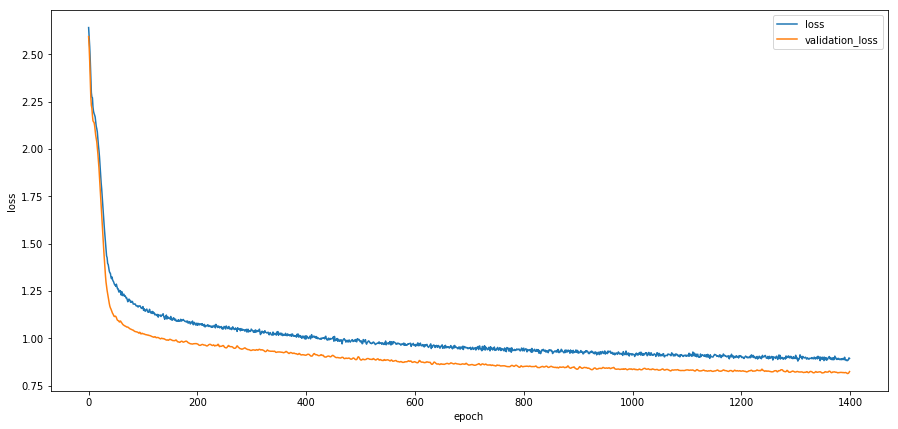

In [73]:
loss = plt.figure(figsize=(15,7))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

In [66]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
xgb = XGBClassifier()
xgb.fit(train_eli5, y_train)
lgbm = LGBMClassifier()
lgbm.fit(train_eli5, y_train)
gb = GradientBoostingClassifier()
gb.fit(train_eli5, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [99]:
# save the model to disk
import pickle
filename = 'xgb.sav'
pickle.dump(xgb, open(filename, 'wb'))
filename = 'lgbm.sav'
pickle.dump(lgbm, open(filename, 'wb'))
filename = 'gb.sav'
pickle.dump(gb, open(filename, 'wb'))

In [74]:
NN_predict_eli5 = model.predict(test_eli5)
xgb_predict_eli5 = xgb.predict_proba(test_eli5)
lgbm_predict_eli5 = lgbm.predict_proba(test_eli5)
gb_predict_eli5 = gb.predict_proba(test_eli5)

In [75]:
NN_predict_pd_eli5 = pd.DataFrame(data=NN_predict_eli5, columns=encoder.classes_)
xgb_predict_pd_eli5 = pd.DataFrame(data=xgb_predict_eli5, columns=xgb.classes_)
lgbm_predict_pd_eli5 = pd.DataFrame(data=lgbm_predict_eli5, columns=lgbm.classes_)
gb_predict_pd_eli5 = pd.DataFrame(data=gb_predict_eli5, columns=gb.classes_)

In [98]:
avg_pd_eli5 = (NN_predict_pd_eli5 + xgb_predict_pd_eli5 + lgbm_predict_pd_eli5) / 3
avg_pd_4_eli5 = (NN_predict_pd_eli5 + xgb_predict_pd_eli5 + lgbm_predict_pd_eli5 + gb_predict_pd_eli5) / 4
w_avg_pd_eli5 = (0.2*NN_predict_pd_eli5 + 0.2*xgb_predict_pd_eli5 + 0.8*lgbm_predict_pd_eli5) / 3
w_avg_pd_4_eli5 = (0.2*NN_predict_pd_eli5 + 0.2*xgb_predict_pd_eli5 + 0.8*lgbm_predict_pd_eli5 + 0.1*gb_predict_pd_eli5) / 4
from sklearn.metrics import log_loss
print("Log_loss for NN: {}".format(log_loss(y_test_dummy_pd, NN_predict_pd_eli5)))
print("Log_loss for lgbm: {}".format(log_loss(y_test_dummy_pd, lgbm_predict_pd_eli5)))
print("Log_loss for xgb: {}".format(log_loss(y_test_dummy_pd, xgb_predict_pd_eli5)))
print("Log_loss for gb: {}".format(log_loss(y_test_dummy_pd, gb_predict_pd_eli5)))
print("Log_loss for avarage(NN,xgb,lgbm): {}".format(log_loss(y_test_dummy_pd, avg_pd_eli5)))
print("Log_loss for avarage(NN,xgb,lgbm,gb): {}".format(log_loss(y_test_dummy_pd, avg_pd_4_eli5)))
print("Log_loss for weighted avarage(NN,xgb,lgbm): {}".format(log_loss(y_test_dummy_pd, w_avg_pd_eli5)))
print("Log_loss for weighted avarage(NN,xgb,lgbm,gb): {}".format(log_loss(y_test_dummy_pd, w_avg_pd_4_eli5)))

Log_loss for NN: 0.824427664922833
Log_loss for lgbm: 0.7633788734719703
Log_loss for xgb: 0.7768886148714561
Log_loss for gb: 0.7888584038544771
Log_loss for avarage(NN,xgb,lgbm): 0.745215357109432
Log_loss for avarage(NN,xgb,lgbm,gb): 0.7437040021396253
Log_loss for weighted avarage(NN,xgb,lgbm): 0.7328897565305001
Log_loss for weighted avarage(NN,xgb,lgbm,gb): 0.7319432507355845


In [ ]:
models_score.to_csv("..\\models_score_logloss_cv5_complete.csv")

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import time
from itertools import combinations

models = [("LogisticRegression", LogisticRegression()), ("DecisionTreeClassifier", DecisionTreeClassifier()), 
          ("KNeighborsClassifier", KNeighborsClassifier()), ("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()),
          ("GaussianNB", GaussianNB()), ("SVC", SVC(probability=True)), ("AdaBoostClassifier", AdaBoostClassifier()), 
          ("GradientBoostingClassifier", GradientBoostingClassifier()), ("RandomForestClassifier", RandomForestClassifier()),
          ("ExtraTreesClassifier", ExtraTreesClassifier()), ("XGBClassifier", XGBClassifier()), ("LGBMClassifier", LGBMClassifier())]

for i in range(len(models)):
    if i == 0:
        for model in models:
            clf = make_pipeline(StandardScaler(), model[1])
            start = time.time()
            scores = cross_val_score(clf, X.values, Y, cv=5, scoring="neg_log_loss")
            end = time.time()
            print("Log Loss: {:0.2f} (+/- {:0.2f}) Model: {} Elapsed time: {}\n".format(scores.mean(), scores.std() * 2, model[0], end-start))
    else:
        combination = [comb for comb in combinations(models, i+1)]
        for comb in combination:
            model = VotingClassifier(comb, voting='soft')
            clf = make_pipeline(StandardScaler(), model)
            start = time.time()
            scores = cross_val_score(clf, X.values, Y, cv=5, scoring="neg_log_loss")
            end = time.time()
            for mod in comb:
                print(mod[0])
            print("Log Loss: {:0.2f} (+/- {:0.2f}) Model: {} Elapsed time: {}\n".format(scores.mean(), scores.std() * 2, 'Soft_voting', end-start))

In [ ]:
import keras.layers.core as core
import keras.layers.convolutional as conv
import keras.models as models
import keras.utils.np_utils as kutils

# The competition datafiles are in the directory ../input
# Read competition data files:
train = pd.read_csv("../input/train.csv").values
test  = pd.read_csv("../input/test.csv").values

nb_epoch = 1 # Change to 100

batch_size = 128
img_rows, img_cols = 28, 28

nb_filters_1 = 32 # 64
nb_filters_2 = 64 # 128
nb_filters_3 = 128 # 256
nb_conv = 3

trainX = train[:, 1:].reshape(train.shape[0], img_rows, img_cols, 1)
trainX = trainX.astype(float)
trainX /= 255.0

trainY = kutils.to_categorical(train[:, 0])
nb_classes = trainY.shape[1]

cnn = models.Sequential()

cnn.add(conv.Convolution2D(nb_filters_1, nb_conv, nb_conv,  activation="relu", input_shape=(28, 28, 1), border_mode='same'))
cnn.add(conv.Convolution2D(nb_filters_1, nb_conv, nb_conv, activation="relu", border_mode='same'))
cnn.add(conv.MaxPooling2D(strides=(2,2)))

cnn.add(conv.Convolution2D(nb_filters_2, nb_conv, nb_conv, activation="relu", border_mode='same'))
cnn.add(conv.Convolution2D(nb_filters_2, nb_conv, nb_conv, activation="relu", border_mode='same'))
cnn.add(conv.MaxPooling2D(strides=(2,2)))

#cnn.add(conv.Convolution2D(nb_filters_3, nb_conv, nb_conv, activation="relu", border_mode='same'))
#cnn.add(conv.Convolution2D(nb_filters_3, nb_conv, nb_conv, activation="relu", border_mode='same'))
#cnn.add(conv.Convolution2D(nb_filters_3, nb_conv, nb_conv, activation="relu", border_mode='same'))
#cnn.add(conv.Convolution2D(nb_filters_3, nb_conv, nb_conv, activation="relu", border_mode='same'))
#cnn.add(conv.MaxPooling2D(strides=(2,2)))

cnn.add(core.Flatten())
cnn.add(core.Dropout(0.2))
cnn.add(core.Dense(128, activation="relu")) # 4096
cnn.add(core.Dense(nb_classes, activation="softmax"))

cnn.summary()
cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

cnn.fit(trainX, trainY, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

testX = test.reshape(test.shape[0], 28, 28, 1)
testX = testX.astype(float)
testX /= 255.0

yPred = cnn.predict_classes(testX)

np.savetxt('mnist-vggnet.csv', np.c_[range(1,len(yPred)+1),yPred], delimiter=',', header = 'ImageId,Label', comments = '', fmt='%d')

In [ ]:
for i in range(len(models)):
    combination = [comb for comb in combinations(models, i+1)]
    for com in combination:
        print("model: {}".format(com))

# Each model mean score with std and computing time (without additional features)
Log Loss: -7.88 (+/- 2.08) Model: ExtraTreesClassifier Elapsed time: 100.08285164833069  
Log Loss: -1.85 (+/- 0.15) Model: LinearDiscriminantAnalysis Elapsed time: 61.01738452911377  
Log Loss: -1.25 (+/- 0.10) Model: XGBClassifier Elapsed time: 6123.167793512344  
Log Loss: -6.99 (+/- 1.44) Model: RandomForestClassifier Elapsed time: 198.34502911567688  
Log Loss: -20.88 (+/- 2.90) Model: DecisionTreeClassifier Elapsed time: 113.53170943260193  
Log Loss: -1.29 (+/- 0.08) Model: GradientBoostingClassifier Elapsed time: 13707.762514591217  
Log Loss: -2.09 (+/- 0.37) Model: AdaBoostClassifier Elapsed time: 1149.7346422672272  
Log Loss: -17.01 (+/- 1.61) Model: KNeighborsClassifier Elapsed time: 4172.4097192287445  
Log Loss: -2.89 (+/- 0.83) Model: GaussianNB Elapsed time: 48.0736665725708  
Log Loss: -1.54 (+/- 0.14) Model: LogisticRegression Elapsed time: 1171.7033350467682

# Each model mean score with std and computing time (with additional features)
Log Loss: -9.08 (+/- 3.65) Model: KNeighborsClassifier Elapsed time: 2.445700168609619  
Log Loss: -3.97 (+/- 1.75) Model: ExtraTreesClassifier Elapsed time: 0.700063943862915  
Log Loss: -0.87 (+/- 0.06) Model: XGBClassifier Elapsed time: 64.45711851119995  
Log Loss: -3.61 (+/- 1.10) Model: RandomForestClassifier Elapsed time: 1.710193395614624  
Log Loss: -1.85 (+/- 0.20) Model: AdaBoostClassifier Elapsed time: 9.25883936882019  
Log Loss: -1.67 (+/- 0.16) Model: LinearDiscriminantAnalysis Elapsed time: 0.3839569091796875  
Log Loss: -0.90 (+/- 0.07) Model: LGBMClassifier Elapsed time: 23.777573823928833  
Log Loss: -14.06 (+/- 1.10) Model: DecisionTreeClassifier Elapsed time: 2.099644660949707  
Log Loss: -11.23 (+/- 4.38) Model: GaussianNB Elapsed time: 0.2790977954864502  
Log Loss: -1.28 (+/- 0.11) Model: LogisticRegression Elapsed time: 8.399703025817871  
Log Loss: -0.89 (+/- 0.05) Model: GradientBoostingClassifier Elapsed time: 136.06629729270935  
Log Loss: -1.17 (+/- 0.28) Model: SVC Elapsed time: 57.43256688117981  
# new features - our_galaxy, distmod, u,i,g,r,z,y  
Log Loss: -1.11 (+/- 0.11) Model: LogisticRegression Elapsed time: 13.523458242416382  
Log Loss: -1.13 (+/- 0.29) Model: SVC Elapsed time: 72.40939736366272  
Log Loss: -12.58 (+/- 5.21) Model: GaussianNB Elapsed time: 0.28937244415283203  
Log Loss: -8.68 (+/- 3.52) Model: KNeighborsClassifier Elapsed time: 3.983812093734741  
Log Loss: -2.02 (+/- 0.00) Model: LinearDiscriminantAnalysis Elapsed time: 0.5558404922485352  
Log Loss: <span style="color:red">-0.87 (+/- 0.06)</span> Model: <span style="color:red">XGBClassifier</span> Elapsed time: <span style="color:red">80.04815411567688</span>  
Log Loss: <span style="color:red">-0.90 (+/- 0.07)</span> Model: <span style="color:red">LGBMClassifier</span> Elapsed time: <span style="color:red">24.492074012756348</span>  
Log Loss: -14.44 (+/- 1.17) Model: DecisionTreeClassifier Elapsed time: 2.0460832118988037  
Log Loss: -4.27 (+/- 3.31) Model: ExtraTreesClassifier Elapsed time: 0.8186759948730469  
Log Loss: -3.59 (+/- 0.78) Model: RandomForestClassifier Elapsed time: 1.828111171722412  
Log Loss: -1.85 (+/- 0.20) Model: AdaBoostClassifier Elapsed time: 10.512624025344849  
Log Loss: <span style="color:red">-0.90 (+/- 0.05)</span> Model: <span style="color:red">GradientBoostingClassifier</span> Elapsed time: <span style="color:red">156.41159415245056</span>

# What need to be done:
+ use GridSearch for best performing algorithms to tune hyperparameters

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
param_grid = {
    'XGB__objective': ['multi:softprob'],
    'XGB__max_depth': [5],
    'XGB__learning_rate': [0.1],
    'XGB__n_estimators': [10, 100, 500, 1000],
    'XGB__max_delta_step': [0, 3, 7, 15],
#     'XGB__reg_lambda': [1, 4, 8, 15],
#     'XGB__reg_alpha': [0, 4, 8, 15],
#     'n_jobs': [4],
#     'XGB__gamma': [0, 5, 10, 50, 100],
#     'XGB__min_child_weight': [0, 4, 8, 10, 15]
#     'subsample': [0.8],
#     'colsample_bytree': [0.8],
#     'seed': [7],
#     'scale_pos_weight': [1]
}
    
num_fold = 5
seed = 7
scoring = 'neg_log_loss'
clf = Pipeline([('Scaler', StandardScaler()), ('XGB', XGBClassifier())])
kfold = StratifiedKFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid_result = grid.fit(X, Y)
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))

Best: -0.8487265807077085 using {'XGB__max_depth': 5}  
-2.1900422162358306 (0.0772518644778715) with: {'XGB__max_depth': 0}  
-1.026233865072045 (0.06263985156946694) with: {'XGB__max_depth': 1}  
-0.8545517713720128 (0.061303972861370584) with: {'XGB__max_depth': 3}  
-0.8487265807077085 (0.05561527264312647) with: {'XGB__max_depth': 5}  
-0.8700926447496418 (0.061571429799284635) with: {'XGB__max_depth': 8}  
-0.8951323761643858 (0.058237473623006276) with: {'XGB__max_depth': 10}  
-0.9429067864463121 (0.06341666326417081) with: {'XGB__max_depth': 40}  
  
Best: -0.8784299195359695 using {'XGB__max_depth': 5, 'XGB__learning_rate': 0.2}  
-2.6390573978424072 (0.0) with: {'XGB__max_depth': 5, 'XGB__learning_rate': 0}  
-0.8784299195359695 (0.055320235312176176) with: {'XGB__max_depth': 5, 'XGB__learning_rate': 0.2}  
-0.994098823913114 (0.07178186295969005) with: {'XGB__max_depth': 5, 'XGB__learning_rate': 0.4}  
-1.2213390914999953 (0.10789418649366185) with: {'XGB__max_depth': 5, 'XGB__learning_rate': 0.8}  
-1.3323646153189768 (0.10978624217778912) with: {'XGB__max_depth': 5, 'XGB__learning_rate': 1.0}  
  
Best: -0.8545517713720128 using {'XGB__n_estimators': 100}  
-1.4592067780738334 (0.04008300688651221) with: {'XGB__n_estimators': 10}  
-0.8545517713720128 (0.061303972861370584) with: {'XGB__n_estimators': 100}  
-0.885109165084866 (0.06469246448219422) with: {'XGB__n_estimators': 500}  
-0.9722584281487732 (0.06992567707591202) with: {'XGB__n_estimators': 1000}  
  
Best: -0.8545517713720128 using {'XGB__max_delta_step': 0}  
-0.8545517713720128 (0.061303972861370584) with: {'XGB__max_delta_step': 0}  
-0.8558057217844818 (0.06031065124182757) with: {'XGB__max_delta_step': 3}  
-0.8545517713720128 (0.061303972861370584) with: {'XGB__max_delta_step': 7}  
-0.8545517713720128 (0.061303972861370584) with: {'XGB__max_delta_step': 15}  
  
Best: -0.8545517713720128 using {'XGB__reg_lambda': 1}  
-0.8545517713720128 (0.061303972861370584) with: {'XGB__reg_lambda': 1}  
-0.8590918962591126 (0.058317127980103) with: {'XGB__reg_lambda': 4}  
-0.862725993370497 (0.057531287973581785) with: {'XGB__reg_lambda': 8}  
-0.8692654956731576 (0.05594342860812531) with: {'XGB__reg_lambda': 15}  
  
Best: -0.8487265807077085 using {'XGB__max_depth': 5}  
-2.1900422162358306 (0.0772518644778715) with: {'XGB__max_depth': 0}  
-1.026233865072045 (0.06263985156946694) with: {'XGB__max_depth': 1}  
-0.8545517713720128 (0.061303972861370584) with: {'XGB__max_depth': 3}  
-0.8487265807077085 (0.05561527264312647) with: {'XGB__max_depth': 5}  
-0.8700926447496418 (0.061571429799284635) with: {'XGB__max_depth': 8}  
-0.8951323761643858 (0.058237473623006276) with: {'XGB__max_depth': 10}  
-0.9429067864463121 (0.06341666326417081) with: {'XGB__max_depth': 40}  
  
Best: -0.8545517713720128 using {'XGB__gamma': 0}  
-0.8545517713720128 (0.061303972861370584) with: {'XGB__gamma': 0}  
-0.903082186807133 (0.058228318902271835) with: {'XGB__gamma': 5}  
-0.9543472573777735 (0.05773443431401045) with: {'XGB__gamma': 10}  
-1.1735887674455294 (0.06174609652657938) with: {'XGB__gamma': 50}  
-1.3107896865336994 (0.07620362674324146) with: {'XGB__gamma': 100}  
  
Best: -0.8553818027633903 using {'XGB__min_child_weight': 0}  
-0.8553818027633903 (0.06031309661220473) with: {'XGB__min_child_weight': 0}  
-0.8562841135000399 (0.05729167488043555) with: {'XGB__min_child_weight': 4}  
-0.8600264071701476 (0.057857319874773466) with: {'XGB__min_child_weight': 8}  
-0.8620729239020234 (0.05773576121093804) with: {'XGB__min_child_weight': 10}  
-0.8661988441960883 (0.059227222532968034) with: {'XGB__min_child_weight': 15}  